In [8]:
# import numpy as np
# import pandas as pd
# from pandas.tseries.offsets import MonthEnd

# # raw_data = pd.read_excel(
# #     "/Users/drest/Downloads/Book2.xlsx",
# #     sheet_name="Country_Avg",
# # )

# # # Unpivot the DataFrame so each year/month is a row, not a column
# # raw_data = raw_data.melt(id_vars=["Unnamed: 0"], var_name="year", value_name="value")
# # raw_data = raw_data.rename(columns={"Unnamed: 0": "month"})

# # raw_data["eom"] = pd.to_datetime(raw_data["year"].astype(str) + "-" + raw_data["month"].astype(str).str.strip() + "-01", format="%Y-%b-%d") + MonthEnd(0)
# # raw_data.drop(columns=["year", "month"], inplace=True)
# # weekly_data = pd.read_parquet(".data/extracted/porkcolombia.parquet.snappy")
# # weekly_data = weekly_data.loc[weekly_data["ts"] >= pd.to_datetime("2023-12-31")]
# # weekly_data["eom"] = weekly_data["ts"] + MonthEnd(0)
# # weekly_data_ = weekly_data.groupby("eom").agg({"average": "mean"}).reset_index().sort_values("eom", ascending=False)
# # combined = raw_data.merge(weekly_data_, on="eom", how="left")
# # combined["price"] = combined[["value", "average"]].mean(axis=1, skipna=True)
# # combined.drop(columns=["value", "average"], inplace=True)
# # combined.sort_values("eom", ascending=False, inplace=True)
# # combined.reset_index(drop=True).to_parquet(".data/extracted/porkcolombia_country_avg.parquet.snappy", index=False)
# country_avg = pd.read_parquet(".data/extracted/porkcolombia_country_avg.parquet.snappy")
# regional_data = pd.read_excel(
#     "/Users/drest/Downloads/Book2.xlsx",
#     sheet_name="Regional",
# )
# regional_data.fillna(method="ffill", inplace=True)
# antioquia = regional_data[["Mes", "Antioquia"]].rename(columns={"Mes": "eom", "Antioquia": "price"})
# antioquia["eom"] = antioquia["eom"] + MonthEnd(0)
# antioquia = antioquia.sort_values("eom", ascending=False).reset_index(drop=True).set_index("eom")
# antioquia.loc[pd.to_datetime("2025-12-31"), "price"] = 8_126
# antioquia.loc[:, "series_id"] = "Antioquia"
# country_avg.loc[:, "series_id"] = "Country_Avg"
# antioquia.reset_index(inplace=True)
# price_data = pd.concat([antioquia, country_avg], ignore_index=True, axis=0).sort_values(["series_id", "eom"], ascending=False).reset_index(drop=True)


# import pandas as pd
# from pandas.tseries.offsets import MonthEnd


# raw_country_production_data = pd.read_excel(
#     "/Users/drest/Downloads/Book2.xlsx",
#     sheet_name="Country_production_avg",
# )

# unpivoted_country_production_data = raw_country_production_data.melt(id_vars=["Mes"], var_name="year", value_name="value").rename(columns={"Mes": "month"})
# unpivoted_country_production_data["eom"] = pd.to_datetime(unpivoted_country_production_data["year"].astype(str) + "-" + unpivoted_country_production_data["month"].astype(str).str.strip() + "-01", format="%Y-%b-%d") + MonthEnd(0)
# unpivoted_country_production_data.drop(columns=["year", "month"], inplace=True)
# unpivoted_country_production_data.rename(columns={"value": "production"}, inplace=True)
# unpivoted_country_production_data.sort_values("eom", ascending=False, inplace=True)
# unpivoted_country_production_data.reset_index(drop=True, inplace=True)
# unpivoted_country_production_data.loc[:, "series_id"] = "Country_Avg"

# from sklearn.preprocessing import PolynomialFeatures
# from sklearn.linear_model import LinearRegression

# # Prepare data for polynomial regression
# country_production_sorted = unpivoted_country_production_data.sort_values("eom").reset_index(drop=True)
# country_production_sorted["numeric_time"] = (country_production_sorted["eom"] - country_production_sorted["eom"].min()).dt.days
# X_train = country_production_sorted["numeric_time"].values.reshape(-1, 1)
# y_train = country_production_sorted["production"].astype(float).values

# # Remove NaN values, if any
# mask_not_nan = ~pd.isna(y_train)
# X_train = X_train[mask_not_nan]
# y_train = y_train[mask_not_nan]

# poly = PolynomialFeatures(degree=3)
# X_poly = poly.fit_transform(X_train)

# model = LinearRegression()
# model.fit(X_poly, y_train)

# # Predict for 2025-12-31
# target_date = pd.to_datetime("2025-12-31")
# target_numeric_time = (target_date - country_production_sorted["eom"].min()).days
# X_pred = poly.transform([[target_numeric_time]])
# production_2025_12_31 = model.predict(X_pred)[0]

# # Optionally, append to DataFrame (if needed for downstream use)
# predicted_row = {
#     "eom": target_date,
#     "production": production_2025_12_31,
#     "series_id": "Country_Avg"
# }
# unpivoted_country_production_data = pd.concat([
#     unpivoted_country_production_data,
#     pd.DataFrame([predicted_row])
# ], ignore_index=True).dropna()

# raw_regional_production_data = pd.read_excel(
#     "/Users/drest/Downloads/Book2.xlsx",
#     sheet_name="Regional_production_avg",
# )

# regional_production_data = raw_regional_production_data.T
# regional_production_data.columns = regional_production_data.iloc[0]
# regional_production_data.drop(regional_production_data.index[0], inplace=True)
# regional_production_data.reset_index(inplace=True)
# regional_production_data.rename(columns={"index": "month"}, inplace=True)
# regional_production_data["eom"] = pd.to_datetime(regional_production_data["month"].astype(str).str.strip()) + MonthEnd(0)
# regional_production_data.drop(columns=["month"], inplace=True)
# regional_production_data = regional_production_data[["eom", "Antioquia"]].rename(columns={"Antioquia": "production"})
# regional_production_data.loc[:, "series_id"] = "Antioquia"

# regional_production_data.columns.name = None
# regional_production_data.index.name = None
# from sklearn.preprocessing import PolynomialFeatures
# from sklearn.linear_model import LinearRegression

# # Prepare data for autoregression (polynomial)
# regional_production_data_sorted = regional_production_data.sort_values("eom").reset_index(drop=True)

# # Use only numeric index as time to predict next value at t+1 (2025-12-31)
# regional_production_data_sorted['numeric_time'] = (regional_production_data_sorted['eom'] - regional_production_data_sorted['eom'].min()).dt.days

# # Use all but last for X_train, and corresponding for y_train
# X_train = regional_production_data_sorted['numeric_time'].values.reshape(-1, 1)
# y_train = regional_production_data_sorted['production'].astype(float).values

# # Remove missing (NaN) production data, just in case
# mask_not_nan = ~pd.isna(y_train)
# X_train = X_train[mask_not_nan]
# y_train = y_train[mask_not_nan]

# # Polynomial features (degree can be changed as needed)
# poly = PolynomialFeatures(degree=3)
# X_poly = poly.fit_transform(X_train)

# model = LinearRegression()
# model.fit(X_poly, y_train)

# # Predict for 2025-12-31
# target_date = pd.to_datetime("2025-12-31")
# target_numeric_time = (target_date - regional_production_data_sorted['eom'].min()).days
# X_pred = poly.transform([[target_numeric_time]])
# predicted_production = model.predict(X_pred)[0]

# # Insert the prediction for 2025-12-31 if it's not there
# if not (regional_production_data_sorted['eom'] == target_date).any():
#     # Insert at the end
#     new_row = pd.DataFrame({
#         'eom': [target_date],
#         'production': [predicted_production],
#         'series_id': ["Antioquia"]
#     })
#     # Ensure columns match (add missing ones if necessary)
#     for col in regional_production_data_sorted.columns:
#         if col not in new_row.columns:
#             new_row[col] = [None]
#     regional_production_data = pd.concat([regional_production_data, new_row[regional_production_data.columns]], ignore_index=True)


# regional_production_data.sort_values("eom", ascending=False, inplace=True)
# regional_production_data.reset_index(drop=True, inplace=True, names=None)
# regional_production_data
# production_data = pd.concat([unpivoted_country_production_data, regional_production_data], ignore_index=True, axis=0).sort_values(["series_id", "eom"], ascending=False).reset_index(drop=True)
# production_data

# combined = pd.merge(price_data, production_data, on=["eom", "series_id"], how="inner")

# raw_consumption_data = pd.read_excel(
#     "/Users/drest/Downloads/Book2.xlsx",
#     sheet_name="Consumption",
# )

# raw_consumption_data
# from sklearn.linear_model import LinearRegression
# import numpy as np

# # Prepare the data for regression
# consumption_df = raw_consumption_data.copy()
# X = consumption_df[['year']].values
# y = consumption_df['per_capita_consumption'].values

# # Fit the linear regression model
# model = LinearRegression()
# model.fit(X, y)

# # Predict per capita consumption for 2025
# year_2025 = np.array([[2025]])
# per_capita_2025 = model.predict(year_2025)[0]

# print(f"Predicted per_capita_consumption for 2025: {per_capita_2025:.2f}")

# raw_consumption_data.loc[len(raw_consumption_data.index)] = pd.Series({"year": 2025, "per_capita_consumption": per_capita_2025})
# raw_consumption_data.sort_values("year", ascending=True, inplace=True)
# raw_consumption_data.reset_index(drop=True, inplace=True)

# import pandas as pd
# import numpy as np
# from pandas.tseries.offsets import MonthEnd

# # Create a monthly date range from the first year to the last year
# monthly_dates = pd.date_range(
#     start=f"{raw_consumption_data['year'].min().astype(int)}-01-01", 
#     end=f"{raw_consumption_data['year'].max().astype(int)}-12-31", 
#     freq='M'
# )
# monthly_consumption_data = pd.DataFrame({
#     'eom': monthly_dates + MonthEnd(0),
#     'year': monthly_dates.year,
# })
# raw_monthly_consumption_data = pd.merge(monthly_consumption_data, raw_consumption_data, on="year", how="left").drop(columns=["year"]).sort_values("eom", ascending=False).reset_index(drop=True)

# regional_monthly_consumption_data = raw_monthly_consumption_data.copy()
# regional_monthly_consumption_data.loc[:, "series_id"] = "Antioquia"
# country_monthly_consumption_data = raw_monthly_consumption_data.copy()
# country_monthly_consumption_data.loc[:, "series_id"] = "Country_Avg"

# consumption_data = pd.concat([regional_monthly_consumption_data, country_monthly_consumption_data], ignore_index=True, axis=0).sort_values(["series_id", "eom"], ascending=False).reset_index(drop=True)
# consumption_data

# combined = pd.merge(combined, consumption_data, on=["eom", "series_id"], how="left")
# combined = combined.loc[combined["eom"] >= pd.to_datetime("2020-01-01")]
# combined.to_parquet(".data/extracted/porkcolombia_combined.parquet.snappy", index=False)
# combined

In [1]:
import pandas as pd
import numpy as np

combined = pd.read_parquet(".data/extracted/porkcolombia_combined.parquet.snappy")
combined["year"] = combined["eom"].dt.year
combined["month"] = combined["eom"].dt.month
combined["time_idx"] = combined.groupby("series_id").cumcount(ascending=False)
combined["price"] = combined["price"].astype(np.float64)
combined["production"] = combined["production"].astype(np.float64)
combined["per_capita_consumption"] = combined["per_capita_consumption"].astype(np.float64)
combined["per_capita_consumption"] = combined["per_capita_consumption"] * combined["price"]
combined.sort_values(["eom"], ascending=True, inplace=True)
combined.reset_index(drop=True, inplace=True)
combined = combined.loc[combined["eom"] >= pd.to_datetime("2020-01-01")]


In [ ]:
from ts_piggies.forecast.tft import TFTConfig, TFTForecastWrapper
from ts_piggies.helpers.scaler import MinMaxScalerWrapper

minmax_scaler = MinMaxScalerWrapper()
combined_scaled = minmax_scaler.fit_transform(combined, ["price", "production", "per_capita_consumption"])

wrapper = TFTForecastWrapper(
    combined_scaled,
    TFTConfig(
        learning_rate=0.003,
        hidden_size=64,
        attention_head_size=8,
        dropout=0.01,
        hidden_continuous_size=64,
        batch_size=32,
        max_epochs=100,
        gradient_clip_val=0.01,
        reduce_on_plateau_patience=10,
    ),
    max_encoder_length=64,
    max_prediction_length=7,
)

result = wrapper.fit_predict(simulations=True)

results = pd.DataFrame({"eom": result.dates, "price": result.mean})

results = minmax_scaler.inverse_transform(results, ["price"])

correction = combined.iloc[-1]["price"] - results.iloc[0]["price"]
results["price"] = results["price"].astype(np.float64) + correction

results

/Users/drest/Library/Caches/pypoetry/virtualenvs/ts-experiments-dYK2w0Zu-py3.12/lib/python3.12/site-packages/lightning/pytorch/utilities/parsing.py:210: Attribute 'loss' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['loss'])`.
/Users/drest/Library/Caches/pypoetry/virtualenvs/ts-experiments-dYK2w0Zu-py3.12/lib/python3.12/site-packages/lightning/pytorch/utilities/parsing.py:210: Attribute 'logging_metrics' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['logging_metrics'])`.
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
/Users/drest/Library/Caches/pypoetry/virtualenvs/ts-experiments-dYK2w0Zu-py3.12/lib/python3.12/site-packages/lightning/pytorch/trainer/configuration_validator.py:70: You defined a `validation_step` but have no `val_dataloader`. Skipping val lo

Epoch 1:   0%|          | 0/1 [00:00<?, ?it/s, train_loss_step=0.178, train_loss_epoch=0.178]        

/Users/drest/Library/Caches/pypoetry/virtualenvs/ts-experiments-dYK2w0Zu-py3.12/lib/python3.12/site-packages/lightning/pytorch/loops/training_epoch_loop.py:500: ReduceLROnPlateau conditioned on metric val_loss which is not available but strict is set to `False`. Skipping learning rate update.


Epoch 99: 100%|██████████| 1/1 [00:00<00:00, 10.76it/s, train_loss_step=0.00412, train_loss_epoch=0.00412]

`Trainer.fit` stopped: `max_epochs=100` reached.


Epoch 99: 100%|██████████| 1/1 [00:00<00:00, 10.65it/s, train_loss_step=0.00412, train_loss_epoch=0.00412]


💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
/Users/drest/Library/Caches/pypoetry/virtualenvs/ts-experiments-dYK2w0Zu-py3.12/lib/python3.12/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:434: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=13` in the `DataLoader` to improve performance.


<bound method DataFrame.mean of                    eom        price
0  2026-01-31T00:00:00  8057.250000
1  2026-02-28T00:00:00  8036.938056
2  2026-03-31T00:00:00  7919.191284
3  2026-04-30T00:00:00  7506.904605
4  2026-05-31T00:00:00  6943.542532
5  2026-06-30T00:00:00  6754.389345
6  2026-07-31T00:00:00  6678.942971>

/Users/drest/Library/Caches/pypoetry/virtualenvs/ts-experiments-dYK2w0Zu-py3.12/lib/python3.12/site-packages/lightning/pytorch/utilities/parsing.py:210: Attribute 'loss' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['loss'])`.
/Users/drest/Library/Caches/pypoetry/virtualenvs/ts-experiments-dYK2w0Zu-py3.12/lib/python3.12/site-packages/lightning/pytorch/utilities/parsing.py:210: Attribute 'logging_metrics' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['logging_metrics'])`.
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores


Training 100 models...
Using probabilistic forecasting with n_simulations=1000

[1/100] Training model with config:
  {'learning_rate': 0.04, 'hidden_size': 512, 'attention_head_size': 8, 'dropout': 0.2, 'hidden_continuous_size': 48, 'batch_size': 32, 'max_epochs': 80, 'gradient_clip_val': 0.15, 'reduce_on_plateau_patience': 8}


/Users/drest/Library/Caches/pypoetry/virtualenvs/ts-experiments-dYK2w0Zu-py3.12/lib/python3.12/site-packages/lightning/pytorch/trainer/configuration_validator.py:70: You defined a `validation_step` but have no `val_dataloader`. Skipping val loop.
/Users/drest/Library/Caches/pypoetry/virtualenvs/ts-experiments-dYK2w0Zu-py3.12/lib/python3.12/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:434: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=13` in the `DataLoader` to improve performance.


Epoch 1:  50%|█████     | 1/2 [00:00<00:00,  5.45it/s, train_loss_step=4.070, train_loss_epoch=0.286]

/Users/drest/Library/Caches/pypoetry/virtualenvs/ts-experiments-dYK2w0Zu-py3.12/lib/python3.12/site-packages/lightning/pytorch/loops/training_epoch_loop.py:500: ReduceLROnPlateau conditioned on metric val_loss which is not available but strict is set to `False`. Skipping learning rate update.


Epoch 79: 100%|██████████| 2/2 [00:00<00:00,  7.53it/s, train_loss_step=0.0239, train_loss_epoch=0.0228]

`Trainer.fit` stopped: `max_epochs=80` reached.


Epoch 79: 100%|██████████| 2/2 [00:00<00:00,  7.51it/s, train_loss_step=0.0239, train_loss_epoch=0.0228]


💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
/Users/drest/Library/Caches/pypoetry/virtualenvs/ts-experiments-dYK2w0Zu-py3.12/lib/python3.12/site-packages/lightning/pytorch/trainer/connectors/logger_connector/logger_connector.py:76: Starting from v1.9.0, `tensorboardX` has been removed as a dependency of the `lightning.pytorch` package, due to potential conflicts with other packages in the ML ecosystem. For this reason, `logger=True` will use `CSVLogger` as the default logger, unless the `tensorboard` or `tensorboardX` packages are found. Please `pip install lightning[extra]` or one of them to enable TensorBoard support by default
/Users/drest/Library/Caches/pypoetry/virtualenvs/ts-experiments-dYK2w0Zu-py3.12/lib/python3.12/site-packages/lightning/pyto

  ✓ Training loss: 0.0228

[2/100] Training model with config:
  {'learning_rate': 0.02, 'hidden_size': 128, 'attention_head_size': 2, 'dropout': 0.2, 'hidden_continuous_size': 64, 'batch_size': 64, 'max_epochs': 80, 'gradient_clip_val': 0.1, 'reduce_on_plateau_patience': 4}
Epoch 2:   0%|          | 0/1 [00:00<?, ?it/s, train_loss_step=0.178, train_loss_epoch=0.178]        

/Users/drest/Library/Caches/pypoetry/virtualenvs/ts-experiments-dYK2w0Zu-py3.12/lib/python3.12/site-packages/lightning/pytorch/loops/training_epoch_loop.py:500: ReduceLROnPlateau conditioned on metric val_loss which is not available but strict is set to `False`. Skipping learning rate update.


Epoch 79: 100%|██████████| 1/1 [00:00<00:00,  7.57it/s, train_loss_step=0.0111, train_loss_epoch=0.0111]

`Trainer.fit` stopped: `max_epochs=80` reached.


Epoch 79: 100%|██████████| 1/1 [00:00<00:00,  7.52it/s, train_loss_step=0.0111, train_loss_epoch=0.0111]


💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
/Users/drest/Library/Caches/pypoetry/virtualenvs/ts-experiments-dYK2w0Zu-py3.12/lib/python3.12/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:434: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=13` in the `DataLoader` to improve performance.
/Users/drest/Library/Caches/pypoetry/virtualenvs/ts-experiments-dYK2w0Zu-py3.12/lib/python3.12/site-packages/lightning/pytorch/utilities/parsing.py:210: Attribute 'loss' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['loss'])`.
/Users/drest/Li

  ✓ Training loss: 0.0111

[3/100] Training model with config:
  {'learning_rate': 0.015, 'hidden_size': 64, 'attention_head_size': 8, 'dropout': 0.05, 'hidden_continuous_size': 16, 'batch_size': 64, 'max_epochs': 150, 'gradient_clip_val': 0.05, 'reduce_on_plateau_patience': 6}
Epoch 2:   0%|          | 0/1 [00:00<?, ?it/s, train_loss_step=0.0765, train_loss_epoch=0.0765]        

/Users/drest/Library/Caches/pypoetry/virtualenvs/ts-experiments-dYK2w0Zu-py3.12/lib/python3.12/site-packages/lightning/pytorch/loops/training_epoch_loop.py:500: ReduceLROnPlateau conditioned on metric val_loss which is not available but strict is set to `False`. Skipping learning rate update.


Epoch 149: 100%|██████████| 1/1 [00:00<00:00,  6.92it/s, train_loss_step=0.00498, train_loss_epoch=0.00498]

`Trainer.fit` stopped: `max_epochs=150` reached.


Epoch 149: 100%|██████████| 1/1 [00:00<00:00,  6.88it/s, train_loss_step=0.00498, train_loss_epoch=0.00498]


💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
/Users/drest/Library/Caches/pypoetry/virtualenvs/ts-experiments-dYK2w0Zu-py3.12/lib/python3.12/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:434: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=13` in the `DataLoader` to improve performance.
/Users/drest/Library/Caches/pypoetry/virtualenvs/ts-experiments-dYK2w0Zu-py3.12/lib/python3.12/site-packages/lightning/pytorch/utilities/parsing.py:210: Attribute 'loss' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['loss'])`.
/Users/drest/Li

  ✓ Training loss: 0.0050

[4/100] Training model with config:
  {'learning_rate': 0.02, 'hidden_size': 512, 'attention_head_size': 4, 'dropout': 0.15, 'hidden_continuous_size': 32, 'batch_size': 32, 'max_epochs': 120, 'gradient_clip_val': 0.2, 'reduce_on_plateau_patience': 4}
Epoch 1:  50%|█████     | 1/2 [00:00<00:00,  8.16it/s, train_loss_step=0.785, train_loss_epoch=0.282]

/Users/drest/Library/Caches/pypoetry/virtualenvs/ts-experiments-dYK2w0Zu-py3.12/lib/python3.12/site-packages/lightning/pytorch/loops/training_epoch_loop.py:500: ReduceLROnPlateau conditioned on metric val_loss which is not available but strict is set to `False`. Skipping learning rate update.


Epoch 119: 100%|██████████| 2/2 [00:00<00:00,  8.41it/s, train_loss_step=0.00356, train_loss_epoch=0.00362]

`Trainer.fit` stopped: `max_epochs=120` reached.


Epoch 119: 100%|██████████| 2/2 [00:00<00:00,  8.38it/s, train_loss_step=0.00356, train_loss_epoch=0.00362]


💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
/Users/drest/Library/Caches/pypoetry/virtualenvs/ts-experiments-dYK2w0Zu-py3.12/lib/python3.12/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:434: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=13` in the `DataLoader` to improve performance.
/Users/drest/Library/Caches/pypoetry/virtualenvs/ts-experiments-dYK2w0Zu-py3.12/lib/python3.12/site-packages/lightning/pytorch/utilities/parsing.py:210: Attribute 'loss' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['loss'])`.
/Users/drest/Li

  ✓ Training loss: 0.0036

[5/100] Training model with config:
  {'learning_rate': 0.02, 'hidden_size': 512, 'attention_head_size': 4, 'dropout': 0.2, 'hidden_continuous_size': 32, 'batch_size': 64, 'max_epochs': 250, 'gradient_clip_val': 0.2, 'reduce_on_plateau_patience': 4}
Epoch 2:   0%|          | 0/1 [00:00<?, ?it/s, train_loss_step=0.583, train_loss_epoch=0.583]        

/Users/drest/Library/Caches/pypoetry/virtualenvs/ts-experiments-dYK2w0Zu-py3.12/lib/python3.12/site-packages/lightning/pytorch/loops/training_epoch_loop.py:500: ReduceLROnPlateau conditioned on metric val_loss which is not available but strict is set to `False`. Skipping learning rate update.


Epoch 249: 100%|██████████| 1/1 [00:00<00:00,  6.76it/s, train_loss_step=0.00573, train_loss_epoch=0.00573]

`Trainer.fit` stopped: `max_epochs=250` reached.


Epoch 249: 100%|██████████| 1/1 [00:00<00:00,  6.72it/s, train_loss_step=0.00573, train_loss_epoch=0.00573]


💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
/Users/drest/Library/Caches/pypoetry/virtualenvs/ts-experiments-dYK2w0Zu-py3.12/lib/python3.12/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:434: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=13` in the `DataLoader` to improve performance.
/Users/drest/Library/Caches/pypoetry/virtualenvs/ts-experiments-dYK2w0Zu-py3.12/lib/python3.12/site-packages/lightning/pytorch/utilities/parsing.py:210: Attribute 'loss' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['loss'])`.
/Users/drest/Li

  ✓ Training loss: 0.0057

[6/100] Training model with config:
  {'learning_rate': 0.005, 'hidden_size': 512, 'attention_head_size': 6, 'dropout': 0.1, 'hidden_continuous_size': 48, 'batch_size': 32, 'max_epochs': 80, 'gradient_clip_val': 0.2, 'reduce_on_plateau_patience': 4}
Epoch 1:  50%|█████     | 1/2 [00:00<00:00,  7.60it/s, train_loss_step=0.293, train_loss_epoch=0.290]

/Users/drest/Library/Caches/pypoetry/virtualenvs/ts-experiments-dYK2w0Zu-py3.12/lib/python3.12/site-packages/lightning/pytorch/loops/training_epoch_loop.py:500: ReduceLROnPlateau conditioned on metric val_loss which is not available but strict is set to `False`. Skipping learning rate update.


Epoch 79: 100%|██████████| 2/2 [00:00<00:00,  8.01it/s, train_loss_step=0.0231, train_loss_epoch=0.0233] 

`Trainer.fit` stopped: `max_epochs=80` reached.


Epoch 79: 100%|██████████| 2/2 [00:00<00:00,  7.98it/s, train_loss_step=0.0231, train_loss_epoch=0.0233]


💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
/Users/drest/Library/Caches/pypoetry/virtualenvs/ts-experiments-dYK2w0Zu-py3.12/lib/python3.12/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:434: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=13` in the `DataLoader` to improve performance.
/Users/drest/Library/Caches/pypoetry/virtualenvs/ts-experiments-dYK2w0Zu-py3.12/lib/python3.12/site-packages/lightning/pytorch/utilities/parsing.py:210: Attribute 'loss' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['loss'])`.
/Users/drest/Li

  ✓ Training loss: 0.0233

[7/100] Training model with config:
  {'learning_rate': 0.03, 'hidden_size': 128, 'attention_head_size': 8, 'dropout': 0.15, 'hidden_continuous_size': 16, 'batch_size': 128, 'max_epochs': 100, 'gradient_clip_val': 0.2, 'reduce_on_plateau_patience': 4}
Epoch 2:   0%|          | 0/1 [00:00<?, ?it/s, train_loss_step=0.193, train_loss_epoch=0.193]        

/Users/drest/Library/Caches/pypoetry/virtualenvs/ts-experiments-dYK2w0Zu-py3.12/lib/python3.12/site-packages/lightning/pytorch/loops/training_epoch_loop.py:500: ReduceLROnPlateau conditioned on metric val_loss which is not available but strict is set to `False`. Skipping learning rate update.


Epoch 99: 100%|██████████| 1/1 [00:00<00:00,  7.76it/s, train_loss_step=0.0185, train_loss_epoch=0.0185]

`Trainer.fit` stopped: `max_epochs=100` reached.


Epoch 99: 100%|██████████| 1/1 [00:00<00:00,  7.71it/s, train_loss_step=0.0185, train_loss_epoch=0.0185]


💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
/Users/drest/Library/Caches/pypoetry/virtualenvs/ts-experiments-dYK2w0Zu-py3.12/lib/python3.12/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:434: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=13` in the `DataLoader` to improve performance.
/Users/drest/Library/Caches/pypoetry/virtualenvs/ts-experiments-dYK2w0Zu-py3.12/lib/python3.12/site-packages/lightning/pytorch/utilities/parsing.py:210: Attribute 'loss' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['loss'])`.
/Users/drest/Li

  ✓ Training loss: 0.0185

[8/100] Training model with config:
  {'learning_rate': 0.025, 'hidden_size': 128, 'attention_head_size': 4, 'dropout': 0.15, 'hidden_continuous_size': 16, 'batch_size': 128, 'max_epochs': 120, 'gradient_clip_val': 0.15, 'reduce_on_plateau_patience': 8}
Epoch 2:   0%|          | 0/1 [00:00<?, ?it/s, train_loss_step=0.170, train_loss_epoch=0.170]        

/Users/drest/Library/Caches/pypoetry/virtualenvs/ts-experiments-dYK2w0Zu-py3.12/lib/python3.12/site-packages/lightning/pytorch/loops/training_epoch_loop.py:500: ReduceLROnPlateau conditioned on metric val_loss which is not available but strict is set to `False`. Skipping learning rate update.


Epoch 119: 100%|██████████| 1/1 [00:00<00:00,  7.00it/s, train_loss_step=0.00674, train_loss_epoch=0.00674]

`Trainer.fit` stopped: `max_epochs=120` reached.


Epoch 119: 100%|██████████| 1/1 [00:00<00:00,  6.96it/s, train_loss_step=0.00674, train_loss_epoch=0.00674]


💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
/Users/drest/Library/Caches/pypoetry/virtualenvs/ts-experiments-dYK2w0Zu-py3.12/lib/python3.12/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:434: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=13` in the `DataLoader` to improve performance.
/Users/drest/Library/Caches/pypoetry/virtualenvs/ts-experiments-dYK2w0Zu-py3.12/lib/python3.12/site-packages/lightning/pytorch/utilities/parsing.py:210: Attribute 'loss' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['loss'])`.
/Users/drest/Li

  ✓ Training loss: 0.0067

[9/100] Training model with config:
  {'learning_rate': 0.01, 'hidden_size': 512, 'attention_head_size': 2, 'dropout': 0.25, 'hidden_continuous_size': 16, 'batch_size': 64, 'max_epochs': 120, 'gradient_clip_val': 0.15, 'reduce_on_plateau_patience': 8}
Epoch 2:   0%|          | 0/1 [00:00<?, ?it/s, train_loss_step=0.320, train_loss_epoch=0.320]        

/Users/drest/Library/Caches/pypoetry/virtualenvs/ts-experiments-dYK2w0Zu-py3.12/lib/python3.12/site-packages/lightning/pytorch/loops/training_epoch_loop.py:500: ReduceLROnPlateau conditioned on metric val_loss which is not available but strict is set to `False`. Skipping learning rate update.


Epoch 119: 100%|██████████| 1/1 [00:00<00:00,  6.52it/s, train_loss_step=0.0244, train_loss_epoch=0.0244]

`Trainer.fit` stopped: `max_epochs=120` reached.


Epoch 119: 100%|██████████| 1/1 [00:00<00:00,  6.48it/s, train_loss_step=0.0244, train_loss_epoch=0.0244]


💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
/Users/drest/Library/Caches/pypoetry/virtualenvs/ts-experiments-dYK2w0Zu-py3.12/lib/python3.12/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:434: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=13` in the `DataLoader` to improve performance.
/Users/drest/Library/Caches/pypoetry/virtualenvs/ts-experiments-dYK2w0Zu-py3.12/lib/python3.12/site-packages/lightning/pytorch/utilities/parsing.py:210: Attribute 'loss' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['loss'])`.
/Users/drest/Li

  ✓ Training loss: 0.0244

[10/100] Training model with config:
  {'learning_rate': 0.025, 'hidden_size': 64, 'attention_head_size': 6, 'dropout': 0.1, 'hidden_continuous_size': 64, 'batch_size': 32, 'max_epochs': 150, 'gradient_clip_val': 0.15, 'reduce_on_plateau_patience': 4}
Epoch 1:  50%|█████     | 1/2 [00:00<00:00,  6.90it/s, train_loss_step=0.202, train_loss_epoch=0.131]

/Users/drest/Library/Caches/pypoetry/virtualenvs/ts-experiments-dYK2w0Zu-py3.12/lib/python3.12/site-packages/lightning/pytorch/loops/training_epoch_loop.py:500: ReduceLROnPlateau conditioned on metric val_loss which is not available but strict is set to `False`. Skipping learning rate update.


Epoch 149: 100%|██████████| 2/2 [00:00<00:00,  9.55it/s, train_loss_step=0.0033, train_loss_epoch=0.00377] 

`Trainer.fit` stopped: `max_epochs=150` reached.


Epoch 149: 100%|██████████| 2/2 [00:00<00:00,  9.51it/s, train_loss_step=0.0033, train_loss_epoch=0.00377]


💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
/Users/drest/Library/Caches/pypoetry/virtualenvs/ts-experiments-dYK2w0Zu-py3.12/lib/python3.12/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:434: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=13` in the `DataLoader` to improve performance.
/Users/drest/Library/Caches/pypoetry/virtualenvs/ts-experiments-dYK2w0Zu-py3.12/lib/python3.12/site-packages/lightning/pytorch/utilities/parsing.py:210: Attribute 'loss' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['loss'])`.
/Users/drest/Li

  ✓ Training loss: 0.0038

[11/100] Training model with config:
  {'learning_rate': 0.015, 'hidden_size': 128, 'attention_head_size': 8, 'dropout': 0.2, 'hidden_continuous_size': 32, 'batch_size': 128, 'max_epochs': 150, 'gradient_clip_val': 0.1, 'reduce_on_plateau_patience': 6}
Epoch 2:   0%|          | 0/1 [00:00<?, ?it/s, train_loss_step=0.133, train_loss_epoch=0.133]        

/Users/drest/Library/Caches/pypoetry/virtualenvs/ts-experiments-dYK2w0Zu-py3.12/lib/python3.12/site-packages/lightning/pytorch/loops/training_epoch_loop.py:500: ReduceLROnPlateau conditioned on metric val_loss which is not available but strict is set to `False`. Skipping learning rate update.


Epoch 149: 100%|██████████| 1/1 [00:00<00:00,  7.24it/s, train_loss_step=0.00509, train_loss_epoch=0.00509]

`Trainer.fit` stopped: `max_epochs=150` reached.


Epoch 149: 100%|██████████| 1/1 [00:00<00:00,  7.19it/s, train_loss_step=0.00509, train_loss_epoch=0.00509]


💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
/Users/drest/Library/Caches/pypoetry/virtualenvs/ts-experiments-dYK2w0Zu-py3.12/lib/python3.12/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:434: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=13` in the `DataLoader` to improve performance.
/Users/drest/Library/Caches/pypoetry/virtualenvs/ts-experiments-dYK2w0Zu-py3.12/lib/python3.12/site-packages/lightning/pytorch/utilities/parsing.py:210: Attribute 'loss' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['loss'])`.
/Users/drest/Li

  ✓ Training loss: 0.0051

[12/100] Training model with config:
  {'learning_rate': 0.03, 'hidden_size': 128, 'attention_head_size': 6, 'dropout': 0.15, 'hidden_continuous_size': 48, 'batch_size': 128, 'max_epochs': 100, 'gradient_clip_val': 0.15, 'reduce_on_plateau_patience': 4}
Epoch 2:   0%|          | 0/1 [00:00<?, ?it/s, train_loss_step=0.190, train_loss_epoch=0.190]        

/Users/drest/Library/Caches/pypoetry/virtualenvs/ts-experiments-dYK2w0Zu-py3.12/lib/python3.12/site-packages/lightning/pytorch/loops/training_epoch_loop.py:500: ReduceLROnPlateau conditioned on metric val_loss which is not available but strict is set to `False`. Skipping learning rate update.


Epoch 99: 100%|██████████| 1/1 [00:00<00:00,  7.40it/s, train_loss_step=0.0258, train_loss_epoch=0.0258]

`Trainer.fit` stopped: `max_epochs=100` reached.


Epoch 99: 100%|██████████| 1/1 [00:00<00:00,  7.35it/s, train_loss_step=0.0258, train_loss_epoch=0.0258]


💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
/Users/drest/Library/Caches/pypoetry/virtualenvs/ts-experiments-dYK2w0Zu-py3.12/lib/python3.12/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:434: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=13` in the `DataLoader` to improve performance.
/Users/drest/Library/Caches/pypoetry/virtualenvs/ts-experiments-dYK2w0Zu-py3.12/lib/python3.12/site-packages/lightning/pytorch/utilities/parsing.py:210: Attribute 'loss' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['loss'])`.
/Users/drest/Li

  ✓ Training loss: 0.0258

[13/100] Training model with config:
  {'learning_rate': 0.04, 'hidden_size': 512, 'attention_head_size': 4, 'dropout': 0.05, 'hidden_continuous_size': 16, 'batch_size': 32, 'max_epochs': 150, 'gradient_clip_val': 0.05, 'reduce_on_plateau_patience': 6}
Epoch 1:  50%|█████     | 1/2 [00:00<00:00,  6.59it/s, train_loss_step=0.837, train_loss_epoch=0.330]

/Users/drest/Library/Caches/pypoetry/virtualenvs/ts-experiments-dYK2w0Zu-py3.12/lib/python3.12/site-packages/lightning/pytorch/loops/training_epoch_loop.py:500: ReduceLROnPlateau conditioned on metric val_loss which is not available but strict is set to `False`. Skipping learning rate update.


Epoch 149: 100%|██████████| 2/2 [00:00<00:00,  8.06it/s, train_loss_step=0.0112, train_loss_epoch=0.0085]  

`Trainer.fit` stopped: `max_epochs=150` reached.


Epoch 149: 100%|██████████| 2/2 [00:00<00:00,  8.03it/s, train_loss_step=0.0112, train_loss_epoch=0.0085]


💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
/Users/drest/Library/Caches/pypoetry/virtualenvs/ts-experiments-dYK2w0Zu-py3.12/lib/python3.12/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:434: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=13` in the `DataLoader` to improve performance.
/Users/drest/Library/Caches/pypoetry/virtualenvs/ts-experiments-dYK2w0Zu-py3.12/lib/python3.12/site-packages/lightning/pytorch/utilities/parsing.py:210: Attribute 'loss' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['loss'])`.
/Users/drest/Li

  ✓ Training loss: 0.0085

[14/100] Training model with config:
  {'learning_rate': 0.005, 'hidden_size': 128, 'attention_head_size': 2, 'dropout': 0.1, 'hidden_continuous_size': 16, 'batch_size': 64, 'max_epochs': 150, 'gradient_clip_val': 0.05, 'reduce_on_plateau_patience': 6}
Epoch 2:   0%|          | 0/1 [00:00<?, ?it/s, train_loss_step=0.0704, train_loss_epoch=0.0704]        

/Users/drest/Library/Caches/pypoetry/virtualenvs/ts-experiments-dYK2w0Zu-py3.12/lib/python3.12/site-packages/lightning/pytorch/loops/training_epoch_loop.py:500: ReduceLROnPlateau conditioned on metric val_loss which is not available but strict is set to `False`. Skipping learning rate update.


Epoch 149: 100%|██████████| 1/1 [00:00<00:00,  6.65it/s, train_loss_step=0.00456, train_loss_epoch=0.00456]

`Trainer.fit` stopped: `max_epochs=150` reached.


Epoch 149: 100%|██████████| 1/1 [00:00<00:00,  6.61it/s, train_loss_step=0.00456, train_loss_epoch=0.00456]


💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
/Users/drest/Library/Caches/pypoetry/virtualenvs/ts-experiments-dYK2w0Zu-py3.12/lib/python3.12/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:434: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=13` in the `DataLoader` to improve performance.
/Users/drest/Library/Caches/pypoetry/virtualenvs/ts-experiments-dYK2w0Zu-py3.12/lib/python3.12/site-packages/lightning/pytorch/utilities/parsing.py:210: Attribute 'loss' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['loss'])`.
/Users/drest/Li

  ✓ Training loss: 0.0046

[15/100] Training model with config:
  {'learning_rate': 0.005, 'hidden_size': 512, 'attention_head_size': 6, 'dropout': 0.25, 'hidden_continuous_size': 16, 'batch_size': 32, 'max_epochs': 250, 'gradient_clip_val': 0.1, 'reduce_on_plateau_patience': 8}
Epoch 1:  50%|█████     | 1/2 [00:00<00:00,  8.84it/s, train_loss_step=0.332, train_loss_epoch=0.200]

/Users/drest/Library/Caches/pypoetry/virtualenvs/ts-experiments-dYK2w0Zu-py3.12/lib/python3.12/site-packages/lightning/pytorch/loops/training_epoch_loop.py:500: ReduceLROnPlateau conditioned on metric val_loss which is not available but strict is set to `False`. Skipping learning rate update.


Epoch 249: 100%|██████████| 2/2 [00:00<00:00,  8.08it/s, train_loss_step=0.00861, train_loss_epoch=0.00609]

`Trainer.fit` stopped: `max_epochs=250` reached.


Epoch 249: 100%|██████████| 2/2 [00:00<00:00,  8.06it/s, train_loss_step=0.00861, train_loss_epoch=0.00609]


💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
/Users/drest/Library/Caches/pypoetry/virtualenvs/ts-experiments-dYK2w0Zu-py3.12/lib/python3.12/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:434: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=13` in the `DataLoader` to improve performance.
/Users/drest/Library/Caches/pypoetry/virtualenvs/ts-experiments-dYK2w0Zu-py3.12/lib/python3.12/site-packages/lightning/pytorch/utilities/parsing.py:210: Attribute 'loss' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['loss'])`.
/Users/drest/Li

  ✓ Training loss: 0.0061

[16/100] Training model with config:
  {'learning_rate': 0.025, 'hidden_size': 256, 'attention_head_size': 2, 'dropout': 0.2, 'hidden_continuous_size': 32, 'batch_size': 128, 'max_epochs': 100, 'gradient_clip_val': 0.15, 'reduce_on_plateau_patience': 8}
Epoch 2:   0%|          | 0/1 [00:00<?, ?it/s, train_loss_step=0.213, train_loss_epoch=0.213]        

/Users/drest/Library/Caches/pypoetry/virtualenvs/ts-experiments-dYK2w0Zu-py3.12/lib/python3.12/site-packages/lightning/pytorch/loops/training_epoch_loop.py:500: ReduceLROnPlateau conditioned on metric val_loss which is not available but strict is set to `False`. Skipping learning rate update.


Epoch 99: 100%|██████████| 1/1 [00:00<00:00,  7.60it/s, train_loss_step=0.0301, train_loss_epoch=0.0301]

`Trainer.fit` stopped: `max_epochs=100` reached.


Epoch 99: 100%|██████████| 1/1 [00:00<00:00,  7.54it/s, train_loss_step=0.0301, train_loss_epoch=0.0301]


💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
/Users/drest/Library/Caches/pypoetry/virtualenvs/ts-experiments-dYK2w0Zu-py3.12/lib/python3.12/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:434: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=13` in the `DataLoader` to improve performance.
/Users/drest/Library/Caches/pypoetry/virtualenvs/ts-experiments-dYK2w0Zu-py3.12/lib/python3.12/site-packages/lightning/pytorch/utilities/parsing.py:210: Attribute 'loss' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['loss'])`.
/Users/drest/Li

  ✓ Training loss: 0.0301

[17/100] Training model with config:
  {'learning_rate': 0.03, 'hidden_size': 64, 'attention_head_size': 8, 'dropout': 0.2, 'hidden_continuous_size': 32, 'batch_size': 64, 'max_epochs': 250, 'gradient_clip_val': 0.1, 'reduce_on_plateau_patience': 6}
Epoch 2:   0%|          | 0/1 [00:00<?, ?it/s, train_loss_step=0.0872, train_loss_epoch=0.0872]        

/Users/drest/Library/Caches/pypoetry/virtualenvs/ts-experiments-dYK2w0Zu-py3.12/lib/python3.12/site-packages/lightning/pytorch/loops/training_epoch_loop.py:500: ReduceLROnPlateau conditioned on metric val_loss which is not available but strict is set to `False`. Skipping learning rate update.


Epoch 249: 100%|██████████| 1/1 [00:00<00:00,  7.52it/s, train_loss_step=0.00319, train_loss_epoch=0.00319]

`Trainer.fit` stopped: `max_epochs=250` reached.


Epoch 249: 100%|██████████| 1/1 [00:00<00:00,  7.47it/s, train_loss_step=0.00319, train_loss_epoch=0.00319]


💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
/Users/drest/Library/Caches/pypoetry/virtualenvs/ts-experiments-dYK2w0Zu-py3.12/lib/python3.12/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:434: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=13` in the `DataLoader` to improve performance.
/Users/drest/Library/Caches/pypoetry/virtualenvs/ts-experiments-dYK2w0Zu-py3.12/lib/python3.12/site-packages/lightning/pytorch/utilities/parsing.py:210: Attribute 'loss' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['loss'])`.
/Users/drest/Li

  ✓ Training loss: 0.0032

[18/100] Training model with config:
  {'learning_rate': 0.03, 'hidden_size': 64, 'attention_head_size': 6, 'dropout': 0.25, 'hidden_continuous_size': 48, 'batch_size': 64, 'max_epochs': 80, 'gradient_clip_val': 0.05, 'reduce_on_plateau_patience': 8}
Epoch 2:   0%|          | 0/1 [00:00<?, ?it/s, train_loss_step=0.0988, train_loss_epoch=0.0988]        

/Users/drest/Library/Caches/pypoetry/virtualenvs/ts-experiments-dYK2w0Zu-py3.12/lib/python3.12/site-packages/lightning/pytorch/loops/training_epoch_loop.py:500: ReduceLROnPlateau conditioned on metric val_loss which is not available but strict is set to `False`. Skipping learning rate update.


Epoch 79: 100%|██████████| 1/1 [00:00<00:00,  7.33it/s, train_loss_step=0.0143, train_loss_epoch=0.0143]

`Trainer.fit` stopped: `max_epochs=80` reached.


Epoch 79: 100%|██████████| 1/1 [00:00<00:00,  7.28it/s, train_loss_step=0.0143, train_loss_epoch=0.0143]


💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
/Users/drest/Library/Caches/pypoetry/virtualenvs/ts-experiments-dYK2w0Zu-py3.12/lib/python3.12/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:434: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=13` in the `DataLoader` to improve performance.
/Users/drest/Library/Caches/pypoetry/virtualenvs/ts-experiments-dYK2w0Zu-py3.12/lib/python3.12/site-packages/lightning/pytorch/utilities/parsing.py:210: Attribute 'loss' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['loss'])`.
/Users/drest/Li

  ✓ Training loss: 0.0143

[19/100] Training model with config:
  {'learning_rate': 0.025, 'hidden_size': 64, 'attention_head_size': 2, 'dropout': 0.1, 'hidden_continuous_size': 32, 'batch_size': 32, 'max_epochs': 120, 'gradient_clip_val': 0.05, 'reduce_on_plateau_patience': 8}
Epoch 1:  50%|█████     | 1/2 [00:00<00:00,  7.51it/s, train_loss_step=0.137, train_loss_epoch=0.168]

/Users/drest/Library/Caches/pypoetry/virtualenvs/ts-experiments-dYK2w0Zu-py3.12/lib/python3.12/site-packages/lightning/pytorch/loops/training_epoch_loop.py:500: ReduceLROnPlateau conditioned on metric val_loss which is not available but strict is set to `False`. Skipping learning rate update.


Epoch 119: 100%|██████████| 2/2 [00:00<00:00,  8.67it/s, train_loss_step=0.00495, train_loss_epoch=0.00567]

`Trainer.fit` stopped: `max_epochs=120` reached.


Epoch 119: 100%|██████████| 2/2 [00:00<00:00,  8.63it/s, train_loss_step=0.00495, train_loss_epoch=0.00567]


💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
/Users/drest/Library/Caches/pypoetry/virtualenvs/ts-experiments-dYK2w0Zu-py3.12/lib/python3.12/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:434: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=13` in the `DataLoader` to improve performance.
/Users/drest/Library/Caches/pypoetry/virtualenvs/ts-experiments-dYK2w0Zu-py3.12/lib/python3.12/site-packages/lightning/pytorch/utilities/parsing.py:210: Attribute 'loss' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['loss'])`.
/Users/drest/Li

  ✓ Training loss: 0.0057

[20/100] Training model with config:
  {'learning_rate': 0.025, 'hidden_size': 128, 'attention_head_size': 2, 'dropout': 0.25, 'hidden_continuous_size': 64, 'batch_size': 64, 'max_epochs': 100, 'gradient_clip_val': 0.2, 'reduce_on_plateau_patience': 6}
Epoch 2:   0%|          | 0/1 [00:00<?, ?it/s, train_loss_step=0.112, train_loss_epoch=0.112]        

/Users/drest/Library/Caches/pypoetry/virtualenvs/ts-experiments-dYK2w0Zu-py3.12/lib/python3.12/site-packages/lightning/pytorch/loops/training_epoch_loop.py:500: ReduceLROnPlateau conditioned on metric val_loss which is not available but strict is set to `False`. Skipping learning rate update.


Epoch 99: 100%|██████████| 1/1 [00:00<00:00,  7.69it/s, train_loss_step=0.0305, train_loss_epoch=0.0305]

`Trainer.fit` stopped: `max_epochs=100` reached.


Epoch 99: 100%|██████████| 1/1 [00:00<00:00,  7.64it/s, train_loss_step=0.0305, train_loss_epoch=0.0305]


💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
/Users/drest/Library/Caches/pypoetry/virtualenvs/ts-experiments-dYK2w0Zu-py3.12/lib/python3.12/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:434: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=13` in the `DataLoader` to improve performance.
/Users/drest/Library/Caches/pypoetry/virtualenvs/ts-experiments-dYK2w0Zu-py3.12/lib/python3.12/site-packages/lightning/pytorch/utilities/parsing.py:210: Attribute 'loss' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['loss'])`.
/Users/drest/Li

  ✓ Training loss: 0.0305

[21/100] Training model with config:
  {'learning_rate': 0.03, 'hidden_size': 128, 'attention_head_size': 2, 'dropout': 0.2, 'hidden_continuous_size': 48, 'batch_size': 128, 'max_epochs': 80, 'gradient_clip_val': 0.15, 'reduce_on_plateau_patience': 4}
Epoch 2:   0%|          | 0/1 [00:00<?, ?it/s, train_loss_step=0.177, train_loss_epoch=0.177]        

/Users/drest/Library/Caches/pypoetry/virtualenvs/ts-experiments-dYK2w0Zu-py3.12/lib/python3.12/site-packages/lightning/pytorch/loops/training_epoch_loop.py:500: ReduceLROnPlateau conditioned on metric val_loss which is not available but strict is set to `False`. Skipping learning rate update.


Epoch 79: 100%|██████████| 1/1 [00:00<00:00,  8.82it/s, train_loss_step=0.0294, train_loss_epoch=0.0294]

`Trainer.fit` stopped: `max_epochs=80` reached.


Epoch 79: 100%|██████████| 1/1 [00:00<00:00,  8.75it/s, train_loss_step=0.0294, train_loss_epoch=0.0294]


💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
/Users/drest/Library/Caches/pypoetry/virtualenvs/ts-experiments-dYK2w0Zu-py3.12/lib/python3.12/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:434: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=13` in the `DataLoader` to improve performance.
/Users/drest/Library/Caches/pypoetry/virtualenvs/ts-experiments-dYK2w0Zu-py3.12/lib/python3.12/site-packages/lightning/pytorch/utilities/parsing.py:210: Attribute 'loss' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['loss'])`.
/Users/drest/Li

  ✓ Training loss: 0.0294

[22/100] Training model with config:
  {'learning_rate': 0.005, 'hidden_size': 64, 'attention_head_size': 8, 'dropout': 0.2, 'hidden_continuous_size': 64, 'batch_size': 32, 'max_epochs': 80, 'gradient_clip_val': 0.05, 'reduce_on_plateau_patience': 4}
Epoch 1:  50%|█████     | 1/2 [00:00<00:00,  9.42it/s, train_loss_step=0.071, train_loss_epoch=0.133]

/Users/drest/Library/Caches/pypoetry/virtualenvs/ts-experiments-dYK2w0Zu-py3.12/lib/python3.12/site-packages/lightning/pytorch/loops/training_epoch_loop.py:500: ReduceLROnPlateau conditioned on metric val_loss which is not available but strict is set to `False`. Skipping learning rate update.


Epoch 79: 100%|██████████| 2/2 [00:00<00:00,  9.97it/s, train_loss_step=0.00469, train_loss_epoch=0.00505]

`Trainer.fit` stopped: `max_epochs=80` reached.


Epoch 79: 100%|██████████| 2/2 [00:00<00:00,  9.93it/s, train_loss_step=0.00469, train_loss_epoch=0.00505]


💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
/Users/drest/Library/Caches/pypoetry/virtualenvs/ts-experiments-dYK2w0Zu-py3.12/lib/python3.12/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:434: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=13` in the `DataLoader` to improve performance.
/Users/drest/Library/Caches/pypoetry/virtualenvs/ts-experiments-dYK2w0Zu-py3.12/lib/python3.12/site-packages/lightning/pytorch/utilities/parsing.py:210: Attribute 'loss' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['loss'])`.
/Users/drest/Li

  ✓ Training loss: 0.0051

[23/100] Training model with config:
  {'learning_rate': 0.01, 'hidden_size': 512, 'attention_head_size': 6, 'dropout': 0.15, 'hidden_continuous_size': 16, 'batch_size': 32, 'max_epochs': 80, 'gradient_clip_val': 0.1, 'reduce_on_plateau_patience': 4}
Epoch 1:  50%|█████     | 1/2 [00:00<00:00,  7.28it/s, train_loss_step=0.240, train_loss_epoch=0.309]

/Users/drest/Library/Caches/pypoetry/virtualenvs/ts-experiments-dYK2w0Zu-py3.12/lib/python3.12/site-packages/lightning/pytorch/loops/training_epoch_loop.py:500: ReduceLROnPlateau conditioned on metric val_loss which is not available but strict is set to `False`. Skipping learning rate update.


Epoch 79: 100%|██████████| 2/2 [00:00<00:00,  7.98it/s, train_loss_step=0.0106, train_loss_epoch=0.00935]

`Trainer.fit` stopped: `max_epochs=80` reached.


Epoch 79: 100%|██████████| 2/2 [00:00<00:00,  7.93it/s, train_loss_step=0.0106, train_loss_epoch=0.00935]


💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
/Users/drest/Library/Caches/pypoetry/virtualenvs/ts-experiments-dYK2w0Zu-py3.12/lib/python3.12/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:434: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=13` in the `DataLoader` to improve performance.
/Users/drest/Library/Caches/pypoetry/virtualenvs/ts-experiments-dYK2w0Zu-py3.12/lib/python3.12/site-packages/lightning/pytorch/utilities/parsing.py:210: Attribute 'loss' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['loss'])`.
/Users/drest/Li

  ✓ Training loss: 0.0094

[24/100] Training model with config:
  {'learning_rate': 0.04, 'hidden_size': 128, 'attention_head_size': 8, 'dropout': 0.05, 'hidden_continuous_size': 32, 'batch_size': 32, 'max_epochs': 120, 'gradient_clip_val': 0.2, 'reduce_on_plateau_patience': 6}
Epoch 1:  50%|█████     | 1/2 [00:00<00:00,  7.88it/s, train_loss_step=0.968, train_loss_epoch=0.194]

/Users/drest/Library/Caches/pypoetry/virtualenvs/ts-experiments-dYK2w0Zu-py3.12/lib/python3.12/site-packages/lightning/pytorch/loops/training_epoch_loop.py:500: ReduceLROnPlateau conditioned on metric val_loss which is not available but strict is set to `False`. Skipping learning rate update.


Epoch 119: 100%|██████████| 2/2 [00:00<00:00,  7.91it/s, train_loss_step=0.0127, train_loss_epoch=0.00998] 

`Trainer.fit` stopped: `max_epochs=120` reached.


Epoch 119: 100%|██████████| 2/2 [00:00<00:00,  7.88it/s, train_loss_step=0.0127, train_loss_epoch=0.00998]


💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
/Users/drest/Library/Caches/pypoetry/virtualenvs/ts-experiments-dYK2w0Zu-py3.12/lib/python3.12/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:434: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=13` in the `DataLoader` to improve performance.
/Users/drest/Library/Caches/pypoetry/virtualenvs/ts-experiments-dYK2w0Zu-py3.12/lib/python3.12/site-packages/lightning/pytorch/utilities/parsing.py:210: Attribute 'loss' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['loss'])`.
/Users/drest/Li

  ✓ Training loss: 0.0100

[25/100] Training model with config:
  {'learning_rate': 0.03, 'hidden_size': 64, 'attention_head_size': 2, 'dropout': 0.15, 'hidden_continuous_size': 32, 'batch_size': 64, 'max_epochs': 120, 'gradient_clip_val': 0.05, 'reduce_on_plateau_patience': 6}
Epoch 2:   0%|          | 0/1 [00:00<?, ?it/s, train_loss_step=0.113, train_loss_epoch=0.113]        

/Users/drest/Library/Caches/pypoetry/virtualenvs/ts-experiments-dYK2w0Zu-py3.12/lib/python3.12/site-packages/lightning/pytorch/loops/training_epoch_loop.py:500: ReduceLROnPlateau conditioned on metric val_loss which is not available but strict is set to `False`. Skipping learning rate update.


Epoch 119: 100%|██████████| 1/1 [00:00<00:00,  8.13it/s, train_loss_step=0.00525, train_loss_epoch=0.00525]

`Trainer.fit` stopped: `max_epochs=120` reached.


Epoch 119: 100%|██████████| 1/1 [00:00<00:00,  8.06it/s, train_loss_step=0.00525, train_loss_epoch=0.00525]


💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
/Users/drest/Library/Caches/pypoetry/virtualenvs/ts-experiments-dYK2w0Zu-py3.12/lib/python3.12/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:434: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=13` in the `DataLoader` to improve performance.
/Users/drest/Library/Caches/pypoetry/virtualenvs/ts-experiments-dYK2w0Zu-py3.12/lib/python3.12/site-packages/lightning/pytorch/utilities/parsing.py:210: Attribute 'loss' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['loss'])`.
/Users/drest/Li

  ✓ Training loss: 0.0053

[26/100] Training model with config:
  {'learning_rate': 0.03, 'hidden_size': 64, 'attention_head_size': 8, 'dropout': 0.1, 'hidden_continuous_size': 48, 'batch_size': 128, 'max_epochs': 250, 'gradient_clip_val': 0.05, 'reduce_on_plateau_patience': 6}
Epoch 2:   0%|          | 0/1 [00:00<?, ?it/s, train_loss_step=0.0807, train_loss_epoch=0.0807]        

/Users/drest/Library/Caches/pypoetry/virtualenvs/ts-experiments-dYK2w0Zu-py3.12/lib/python3.12/site-packages/lightning/pytorch/loops/training_epoch_loop.py:500: ReduceLROnPlateau conditioned on metric val_loss which is not available but strict is set to `False`. Skipping learning rate update.


Epoch 249: 100%|██████████| 1/1 [00:00<00:00,  7.34it/s, train_loss_step=0.00583, train_loss_epoch=0.00583]

`Trainer.fit` stopped: `max_epochs=250` reached.


Epoch 249: 100%|██████████| 1/1 [00:00<00:00,  7.29it/s, train_loss_step=0.00583, train_loss_epoch=0.00583]


💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
/Users/drest/Library/Caches/pypoetry/virtualenvs/ts-experiments-dYK2w0Zu-py3.12/lib/python3.12/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:434: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=13` in the `DataLoader` to improve performance.
/Users/drest/Library/Caches/pypoetry/virtualenvs/ts-experiments-dYK2w0Zu-py3.12/lib/python3.12/site-packages/lightning/pytorch/utilities/parsing.py:210: Attribute 'loss' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['loss'])`.
/Users/drest/Li

  ✓ Training loss: 0.0058

[27/100] Training model with config:
  {'learning_rate': 0.005, 'hidden_size': 512, 'attention_head_size': 2, 'dropout': 0.2, 'hidden_continuous_size': 48, 'batch_size': 64, 'max_epochs': 120, 'gradient_clip_val': 0.1, 'reduce_on_plateau_patience': 4}
Epoch 2:   0%|          | 0/1 [00:00<?, ?it/s, train_loss_step=0.273, train_loss_epoch=0.273]        

/Users/drest/Library/Caches/pypoetry/virtualenvs/ts-experiments-dYK2w0Zu-py3.12/lib/python3.12/site-packages/lightning/pytorch/loops/training_epoch_loop.py:500: ReduceLROnPlateau conditioned on metric val_loss which is not available but strict is set to `False`. Skipping learning rate update.


Epoch 119: 100%|██████████| 1/1 [00:00<00:00,  6.61it/s, train_loss_step=0.0188, train_loss_epoch=0.0188]

`Trainer.fit` stopped: `max_epochs=120` reached.


Epoch 119: 100%|██████████| 1/1 [00:00<00:00,  6.57it/s, train_loss_step=0.0188, train_loss_epoch=0.0188]


💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
/Users/drest/Library/Caches/pypoetry/virtualenvs/ts-experiments-dYK2w0Zu-py3.12/lib/python3.12/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:434: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=13` in the `DataLoader` to improve performance.
/Users/drest/Library/Caches/pypoetry/virtualenvs/ts-experiments-dYK2w0Zu-py3.12/lib/python3.12/site-packages/lightning/pytorch/utilities/parsing.py:210: Attribute 'loss' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['loss'])`.
/Users/drest/Li

  ✓ Training loss: 0.0188

[28/100] Training model with config:
  {'learning_rate': 0.015, 'hidden_size': 128, 'attention_head_size': 2, 'dropout': 0.05, 'hidden_continuous_size': 16, 'batch_size': 128, 'max_epochs': 100, 'gradient_clip_val': 0.1, 'reduce_on_plateau_patience': 4}
Epoch 2:   0%|          | 0/1 [00:00<?, ?it/s, train_loss_step=0.108, train_loss_epoch=0.108]        

/Users/drest/Library/Caches/pypoetry/virtualenvs/ts-experiments-dYK2w0Zu-py3.12/lib/python3.12/site-packages/lightning/pytorch/loops/training_epoch_loop.py:500: ReduceLROnPlateau conditioned on metric val_loss which is not available but strict is set to `False`. Skipping learning rate update.


Epoch 99: 100%|██████████| 1/1 [00:00<00:00,  8.10it/s, train_loss_step=0.010, train_loss_epoch=0.010]    

`Trainer.fit` stopped: `max_epochs=100` reached.


Epoch 99: 100%|██████████| 1/1 [00:00<00:00,  8.03it/s, train_loss_step=0.010, train_loss_epoch=0.010]


💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
/Users/drest/Library/Caches/pypoetry/virtualenvs/ts-experiments-dYK2w0Zu-py3.12/lib/python3.12/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:434: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=13` in the `DataLoader` to improve performance.
/Users/drest/Library/Caches/pypoetry/virtualenvs/ts-experiments-dYK2w0Zu-py3.12/lib/python3.12/site-packages/lightning/pytorch/utilities/parsing.py:210: Attribute 'loss' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['loss'])`.
/Users/drest/Li

  ✓ Training loss: 0.0100

[29/100] Training model with config:
  {'learning_rate': 0.04, 'hidden_size': 256, 'attention_head_size': 4, 'dropout': 0.15, 'hidden_continuous_size': 32, 'batch_size': 32, 'max_epochs': 150, 'gradient_clip_val': 0.1, 'reduce_on_plateau_patience': 4}
Epoch 1:  50%|█████     | 1/2 [00:00<00:00,  7.75it/s, train_loss_step=2.070, train_loss_epoch=0.270]

/Users/drest/Library/Caches/pypoetry/virtualenvs/ts-experiments-dYK2w0Zu-py3.12/lib/python3.12/site-packages/lightning/pytorch/loops/training_epoch_loop.py:500: ReduceLROnPlateau conditioned on metric val_loss which is not available but strict is set to `False`. Skipping learning rate update.


Epoch 149: 100%|██████████| 2/2 [00:00<00:00,  7.96it/s, train_loss_step=0.0136, train_loss_epoch=0.0132]

`Trainer.fit` stopped: `max_epochs=150` reached.


Epoch 149: 100%|██████████| 2/2 [00:00<00:00,  7.93it/s, train_loss_step=0.0136, train_loss_epoch=0.0132]


💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
/Users/drest/Library/Caches/pypoetry/virtualenvs/ts-experiments-dYK2w0Zu-py3.12/lib/python3.12/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:434: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=13` in the `DataLoader` to improve performance.
/Users/drest/Library/Caches/pypoetry/virtualenvs/ts-experiments-dYK2w0Zu-py3.12/lib/python3.12/site-packages/lightning/pytorch/utilities/parsing.py:210: Attribute 'loss' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['loss'])`.
/Users/drest/Li

  ✓ Training loss: 0.0132

[30/100] Training model with config:
  {'learning_rate': 0.005, 'hidden_size': 64, 'attention_head_size': 2, 'dropout': 0.1, 'hidden_continuous_size': 32, 'batch_size': 32, 'max_epochs': 150, 'gradient_clip_val': 0.05, 'reduce_on_plateau_patience': 4}
Epoch 1:  50%|█████     | 1/2 [00:00<00:00,  7.67it/s, train_loss_step=0.056, train_loss_epoch=0.190] 

/Users/drest/Library/Caches/pypoetry/virtualenvs/ts-experiments-dYK2w0Zu-py3.12/lib/python3.12/site-packages/lightning/pytorch/loops/training_epoch_loop.py:500: ReduceLROnPlateau conditioned on metric val_loss which is not available but strict is set to `False`. Skipping learning rate update.


Epoch 149: 100%|██████████| 2/2 [00:00<00:00,  8.61it/s, train_loss_step=0.00313, train_loss_epoch=0.00305]

`Trainer.fit` stopped: `max_epochs=150` reached.


Epoch 149: 100%|██████████| 2/2 [00:00<00:00,  8.58it/s, train_loss_step=0.00313, train_loss_epoch=0.00305]


💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
/Users/drest/Library/Caches/pypoetry/virtualenvs/ts-experiments-dYK2w0Zu-py3.12/lib/python3.12/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:434: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=13` in the `DataLoader` to improve performance.
/Users/drest/Library/Caches/pypoetry/virtualenvs/ts-experiments-dYK2w0Zu-py3.12/lib/python3.12/site-packages/lightning/pytorch/utilities/parsing.py:210: Attribute 'loss' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['loss'])`.
/Users/drest/Li

  ✓ Training loss: 0.0031

[31/100] Training model with config:
  {'learning_rate': 0.025, 'hidden_size': 512, 'attention_head_size': 4, 'dropout': 0.1, 'hidden_continuous_size': 16, 'batch_size': 32, 'max_epochs': 120, 'gradient_clip_val': 0.15, 'reduce_on_plateau_patience': 8}
Epoch 1:  50%|█████     | 1/2 [00:00<00:00,  8.33it/s, train_loss_step=3.590, train_loss_epoch=0.286]

/Users/drest/Library/Caches/pypoetry/virtualenvs/ts-experiments-dYK2w0Zu-py3.12/lib/python3.12/site-packages/lightning/pytorch/loops/training_epoch_loop.py:500: ReduceLROnPlateau conditioned on metric val_loss which is not available but strict is set to `False`. Skipping learning rate update.


Epoch 119: 100%|██████████| 2/2 [00:00<00:00,  8.58it/s, train_loss_step=0.0127, train_loss_epoch=0.0122]  

`Trainer.fit` stopped: `max_epochs=120` reached.


Epoch 119: 100%|██████████| 2/2 [00:00<00:00,  8.54it/s, train_loss_step=0.0127, train_loss_epoch=0.0122]


💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
/Users/drest/Library/Caches/pypoetry/virtualenvs/ts-experiments-dYK2w0Zu-py3.12/lib/python3.12/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:434: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=13` in the `DataLoader` to improve performance.
/Users/drest/Library/Caches/pypoetry/virtualenvs/ts-experiments-dYK2w0Zu-py3.12/lib/python3.12/site-packages/lightning/pytorch/utilities/parsing.py:210: Attribute 'loss' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['loss'])`.
/Users/drest/Li

  ✓ Training loss: 0.0122

[32/100] Training model with config:
  {'learning_rate': 0.015, 'hidden_size': 512, 'attention_head_size': 8, 'dropout': 0.05, 'hidden_continuous_size': 32, 'batch_size': 64, 'max_epochs': 150, 'gradient_clip_val': 0.05, 'reduce_on_plateau_patience': 4}
Epoch 2:   0%|          | 0/1 [00:00<?, ?it/s, train_loss_step=0.227, train_loss_epoch=0.227]        

/Users/drest/Library/Caches/pypoetry/virtualenvs/ts-experiments-dYK2w0Zu-py3.12/lib/python3.12/site-packages/lightning/pytorch/loops/training_epoch_loop.py:500: ReduceLROnPlateau conditioned on metric val_loss which is not available but strict is set to `False`. Skipping learning rate update.


Epoch 149: 100%|██████████| 1/1 [00:00<00:00,  6.25it/s, train_loss_step=0.0112, train_loss_epoch=0.0112]

`Trainer.fit` stopped: `max_epochs=150` reached.


Epoch 149: 100%|██████████| 1/1 [00:00<00:00,  6.21it/s, train_loss_step=0.0112, train_loss_epoch=0.0112]


💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
/Users/drest/Library/Caches/pypoetry/virtualenvs/ts-experiments-dYK2w0Zu-py3.12/lib/python3.12/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:434: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=13` in the `DataLoader` to improve performance.
/Users/drest/Library/Caches/pypoetry/virtualenvs/ts-experiments-dYK2w0Zu-py3.12/lib/python3.12/site-packages/lightning/pytorch/utilities/parsing.py:210: Attribute 'loss' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['loss'])`.
/Users/drest/Li

  ✓ Training loss: 0.0112

[33/100] Training model with config:
  {'learning_rate': 0.025, 'hidden_size': 256, 'attention_head_size': 6, 'dropout': 0.25, 'hidden_continuous_size': 48, 'batch_size': 64, 'max_epochs': 100, 'gradient_clip_val': 0.1, 'reduce_on_plateau_patience': 8}
Epoch 1:   0%|          | 0/1 [00:00<?, ?it/s, train_loss_step=0.189, train_loss_epoch=0.189]        

/Users/drest/Library/Caches/pypoetry/virtualenvs/ts-experiments-dYK2w0Zu-py3.12/lib/python3.12/site-packages/lightning/pytorch/loops/training_epoch_loop.py:500: ReduceLROnPlateau conditioned on metric val_loss which is not available but strict is set to `False`. Skipping learning rate update.


Epoch 99: 100%|██████████| 1/1 [00:00<00:00,  6.85it/s, train_loss_step=0.0272, train_loss_epoch=0.0272]

`Trainer.fit` stopped: `max_epochs=100` reached.


Epoch 99: 100%|██████████| 1/1 [00:00<00:00,  6.80it/s, train_loss_step=0.0272, train_loss_epoch=0.0272]


💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
/Users/drest/Library/Caches/pypoetry/virtualenvs/ts-experiments-dYK2w0Zu-py3.12/lib/python3.12/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:434: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=13` in the `DataLoader` to improve performance.
/Users/drest/Library/Caches/pypoetry/virtualenvs/ts-experiments-dYK2w0Zu-py3.12/lib/python3.12/site-packages/lightning/pytorch/utilities/parsing.py:210: Attribute 'loss' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['loss'])`.
/Users/drest/Li

  ✓ Training loss: 0.0272

[34/100] Training model with config:
  {'learning_rate': 0.005, 'hidden_size': 128, 'attention_head_size': 4, 'dropout': 0.15, 'hidden_continuous_size': 48, 'batch_size': 32, 'max_epochs': 100, 'gradient_clip_val': 0.15, 'reduce_on_plateau_patience': 8}
Epoch 1:  50%|█████     | 1/2 [00:00<00:00,  8.21it/s, train_loss_step=0.143, train_loss_epoch=0.104] 

/Users/drest/Library/Caches/pypoetry/virtualenvs/ts-experiments-dYK2w0Zu-py3.12/lib/python3.12/site-packages/lightning/pytorch/loops/training_epoch_loop.py:500: ReduceLROnPlateau conditioned on metric val_loss which is not available but strict is set to `False`. Skipping learning rate update.


Epoch 99: 100%|██████████| 2/2 [00:00<00:00,  8.09it/s, train_loss_step=0.00408, train_loss_epoch=0.00433]

`Trainer.fit` stopped: `max_epochs=100` reached.


Epoch 99: 100%|██████████| 2/2 [00:00<00:00,  8.06it/s, train_loss_step=0.00408, train_loss_epoch=0.00433]


💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
/Users/drest/Library/Caches/pypoetry/virtualenvs/ts-experiments-dYK2w0Zu-py3.12/lib/python3.12/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:434: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=13` in the `DataLoader` to improve performance.
/Users/drest/Library/Caches/pypoetry/virtualenvs/ts-experiments-dYK2w0Zu-py3.12/lib/python3.12/site-packages/lightning/pytorch/utilities/parsing.py:210: Attribute 'loss' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['loss'])`.
/Users/drest/Li

  ✓ Training loss: 0.0043

[35/100] Training model with config:
  {'learning_rate': 0.015, 'hidden_size': 512, 'attention_head_size': 8, 'dropout': 0.05, 'hidden_continuous_size': 32, 'batch_size': 128, 'max_epochs': 250, 'gradient_clip_val': 0.05, 'reduce_on_plateau_patience': 6}
Epoch 2:   0%|          | 0/1 [00:00<?, ?it/s, train_loss_step=0.386, train_loss_epoch=0.386]        

/Users/drest/Library/Caches/pypoetry/virtualenvs/ts-experiments-dYK2w0Zu-py3.12/lib/python3.12/site-packages/lightning/pytorch/loops/training_epoch_loop.py:500: ReduceLROnPlateau conditioned on metric val_loss which is not available but strict is set to `False`. Skipping learning rate update.


Epoch 249: 100%|██████████| 1/1 [00:00<00:00,  6.04it/s, train_loss_step=0.00356, train_loss_epoch=0.00356]

`Trainer.fit` stopped: `max_epochs=250` reached.


Epoch 249: 100%|██████████| 1/1 [00:00<00:00,  6.01it/s, train_loss_step=0.00356, train_loss_epoch=0.00356]


💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
/Users/drest/Library/Caches/pypoetry/virtualenvs/ts-experiments-dYK2w0Zu-py3.12/lib/python3.12/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:434: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=13` in the `DataLoader` to improve performance.
/Users/drest/Library/Caches/pypoetry/virtualenvs/ts-experiments-dYK2w0Zu-py3.12/lib/python3.12/site-packages/lightning/pytorch/utilities/parsing.py:210: Attribute 'loss' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['loss'])`.
/Users/drest/Li

  ✓ Training loss: 0.0036

[36/100] Training model with config:
  {'learning_rate': 0.04, 'hidden_size': 64, 'attention_head_size': 6, 'dropout': 0.25, 'hidden_continuous_size': 32, 'batch_size': 128, 'max_epochs': 250, 'gradient_clip_val': 0.05, 'reduce_on_plateau_patience': 6}
Epoch 2:   0%|          | 0/1 [00:00<?, ?it/s, train_loss_step=0.0998, train_loss_epoch=0.0998]        

/Users/drest/Library/Caches/pypoetry/virtualenvs/ts-experiments-dYK2w0Zu-py3.12/lib/python3.12/site-packages/lightning/pytorch/loops/training_epoch_loop.py:500: ReduceLROnPlateau conditioned on metric val_loss which is not available but strict is set to `False`. Skipping learning rate update.


Epoch 249: 100%|██████████| 1/1 [00:00<00:00,  7.11it/s, train_loss_step=0.00495, train_loss_epoch=0.00495]

`Trainer.fit` stopped: `max_epochs=250` reached.


Epoch 249: 100%|██████████| 1/1 [00:00<00:00,  7.06it/s, train_loss_step=0.00495, train_loss_epoch=0.00495]


💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
/Users/drest/Library/Caches/pypoetry/virtualenvs/ts-experiments-dYK2w0Zu-py3.12/lib/python3.12/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:434: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=13` in the `DataLoader` to improve performance.
/Users/drest/Library/Caches/pypoetry/virtualenvs/ts-experiments-dYK2w0Zu-py3.12/lib/python3.12/site-packages/lightning/pytorch/utilities/parsing.py:210: Attribute 'loss' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['loss'])`.
/Users/drest/Li

  ✓ Training loss: 0.0049

[37/100] Training model with config:
  {'learning_rate': 0.04, 'hidden_size': 64, 'attention_head_size': 8, 'dropout': 0.15, 'hidden_continuous_size': 64, 'batch_size': 128, 'max_epochs': 250, 'gradient_clip_val': 0.2, 'reduce_on_plateau_patience': 4}
Epoch 2:   0%|          | 0/1 [00:00<?, ?it/s, train_loss_step=0.0953, train_loss_epoch=0.0953]        

/Users/drest/Library/Caches/pypoetry/virtualenvs/ts-experiments-dYK2w0Zu-py3.12/lib/python3.12/site-packages/lightning/pytorch/loops/training_epoch_loop.py:500: ReduceLROnPlateau conditioned on metric val_loss which is not available but strict is set to `False`. Skipping learning rate update.


Epoch 249: 100%|██████████| 1/1 [00:00<00:00, 10.86it/s, train_loss_step=0.0287, train_loss_epoch=0.0287]  

`Trainer.fit` stopped: `max_epochs=250` reached.


Epoch 249: 100%|██████████| 1/1 [00:00<00:00, 10.75it/s, train_loss_step=0.0287, train_loss_epoch=0.0287]


💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
/Users/drest/Library/Caches/pypoetry/virtualenvs/ts-experiments-dYK2w0Zu-py3.12/lib/python3.12/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:434: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=13` in the `DataLoader` to improve performance.
/Users/drest/Library/Caches/pypoetry/virtualenvs/ts-experiments-dYK2w0Zu-py3.12/lib/python3.12/site-packages/lightning/pytorch/utilities/parsing.py:210: Attribute 'loss' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['loss'])`.
/Users/drest/Li

  ✓ Training loss: 0.0287

[38/100] Training model with config:
  {'learning_rate': 0.04, 'hidden_size': 128, 'attention_head_size': 2, 'dropout': 0.25, 'hidden_continuous_size': 48, 'batch_size': 32, 'max_epochs': 250, 'gradient_clip_val': 0.1, 'reduce_on_plateau_patience': 6}
Epoch 1:  50%|█████     | 1/2 [00:00<00:00,  8.89it/s, train_loss_step=1.070, train_loss_epoch=0.176]

/Users/drest/Library/Caches/pypoetry/virtualenvs/ts-experiments-dYK2w0Zu-py3.12/lib/python3.12/site-packages/lightning/pytorch/loops/training_epoch_loop.py:500: ReduceLROnPlateau conditioned on metric val_loss which is not available but strict is set to `False`. Skipping learning rate update.


Epoch 249: 100%|██████████| 2/2 [00:00<00:00,  8.07it/s, train_loss_step=0.0031, train_loss_epoch=0.00302] 

`Trainer.fit` stopped: `max_epochs=250` reached.


Epoch 249: 100%|██████████| 2/2 [00:00<00:00,  8.04it/s, train_loss_step=0.0031, train_loss_epoch=0.00302]


💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
/Users/drest/Library/Caches/pypoetry/virtualenvs/ts-experiments-dYK2w0Zu-py3.12/lib/python3.12/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:434: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=13` in the `DataLoader` to improve performance.
/Users/drest/Library/Caches/pypoetry/virtualenvs/ts-experiments-dYK2w0Zu-py3.12/lib/python3.12/site-packages/lightning/pytorch/utilities/parsing.py:210: Attribute 'loss' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['loss'])`.
/Users/drest/Li

  ✓ Training loss: 0.0030

[39/100] Training model with config:
  {'learning_rate': 0.015, 'hidden_size': 256, 'attention_head_size': 6, 'dropout': 0.15, 'hidden_continuous_size': 64, 'batch_size': 32, 'max_epochs': 120, 'gradient_clip_val': 0.05, 'reduce_on_plateau_patience': 6}
Epoch 1:  50%|█████     | 1/2 [00:00<00:00,  7.13it/s, train_loss_step=0.212, train_loss_epoch=0.244]

/Users/drest/Library/Caches/pypoetry/virtualenvs/ts-experiments-dYK2w0Zu-py3.12/lib/python3.12/site-packages/lightning/pytorch/loops/training_epoch_loop.py:500: ReduceLROnPlateau conditioned on metric val_loss which is not available but strict is set to `False`. Skipping learning rate update.


Epoch 119: 100%|██████████| 2/2 [00:00<00:00,  8.78it/s, train_loss_step=0.00724, train_loss_epoch=0.00772]

`Trainer.fit` stopped: `max_epochs=120` reached.


Epoch 119: 100%|██████████| 2/2 [00:00<00:00,  8.74it/s, train_loss_step=0.00724, train_loss_epoch=0.00772]


💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
/Users/drest/Library/Caches/pypoetry/virtualenvs/ts-experiments-dYK2w0Zu-py3.12/lib/python3.12/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:434: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=13` in the `DataLoader` to improve performance.
/Users/drest/Library/Caches/pypoetry/virtualenvs/ts-experiments-dYK2w0Zu-py3.12/lib/python3.12/site-packages/lightning/pytorch/utilities/parsing.py:210: Attribute 'loss' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['loss'])`.
/Users/drest/Li

  ✓ Training loss: 0.0077

[40/100] Training model with config:
  {'learning_rate': 0.005, 'hidden_size': 512, 'attention_head_size': 6, 'dropout': 0.05, 'hidden_continuous_size': 32, 'batch_size': 32, 'max_epochs': 80, 'gradient_clip_val': 0.2, 'reduce_on_plateau_patience': 8}
Epoch 1:  50%|█████     | 1/2 [00:00<00:00,  8.07it/s, train_loss_step=0.395, train_loss_epoch=0.157]

/Users/drest/Library/Caches/pypoetry/virtualenvs/ts-experiments-dYK2w0Zu-py3.12/lib/python3.12/site-packages/lightning/pytorch/loops/training_epoch_loop.py:500: ReduceLROnPlateau conditioned on metric val_loss which is not available but strict is set to `False`. Skipping learning rate update.


Epoch 79: 100%|██████████| 2/2 [00:00<00:00,  8.09it/s, train_loss_step=0.0152, train_loss_epoch=0.0147]

`Trainer.fit` stopped: `max_epochs=80` reached.


Epoch 79: 100%|██████████| 2/2 [00:00<00:00,  8.05it/s, train_loss_step=0.0152, train_loss_epoch=0.0147]


💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
/Users/drest/Library/Caches/pypoetry/virtualenvs/ts-experiments-dYK2w0Zu-py3.12/lib/python3.12/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:434: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=13` in the `DataLoader` to improve performance.
/Users/drest/Library/Caches/pypoetry/virtualenvs/ts-experiments-dYK2w0Zu-py3.12/lib/python3.12/site-packages/lightning/pytorch/utilities/parsing.py:210: Attribute 'loss' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['loss'])`.
/Users/drest/Li

  ✓ Training loss: 0.0147

[41/100] Training model with config:
  {'learning_rate': 0.025, 'hidden_size': 256, 'attention_head_size': 4, 'dropout': 0.05, 'hidden_continuous_size': 32, 'batch_size': 64, 'max_epochs': 120, 'gradient_clip_val': 0.15, 'reduce_on_plateau_patience': 6}
Epoch 2:   0%|          | 0/1 [00:00<?, ?it/s, train_loss_step=0.241, train_loss_epoch=0.241]        

/Users/drest/Library/Caches/pypoetry/virtualenvs/ts-experiments-dYK2w0Zu-py3.12/lib/python3.12/site-packages/lightning/pytorch/loops/training_epoch_loop.py:500: ReduceLROnPlateau conditioned on metric val_loss which is not available but strict is set to `False`. Skipping learning rate update.


Epoch 119: 100%|██████████| 1/1 [00:00<00:00,  7.43it/s, train_loss_step=0.0293, train_loss_epoch=0.0293]

`Trainer.fit` stopped: `max_epochs=120` reached.


Epoch 119: 100%|██████████| 1/1 [00:00<00:00,  7.38it/s, train_loss_step=0.0293, train_loss_epoch=0.0293]


💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
/Users/drest/Library/Caches/pypoetry/virtualenvs/ts-experiments-dYK2w0Zu-py3.12/lib/python3.12/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:434: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=13` in the `DataLoader` to improve performance.
/Users/drest/Library/Caches/pypoetry/virtualenvs/ts-experiments-dYK2w0Zu-py3.12/lib/python3.12/site-packages/lightning/pytorch/utilities/parsing.py:210: Attribute 'loss' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['loss'])`.
/Users/drest/Li

  ✓ Training loss: 0.0293

[42/100] Training model with config:
  {'learning_rate': 0.02, 'hidden_size': 256, 'attention_head_size': 6, 'dropout': 0.15, 'hidden_continuous_size': 48, 'batch_size': 32, 'max_epochs': 120, 'gradient_clip_val': 0.1, 'reduce_on_plateau_patience': 4}
Epoch 1:  50%|█████     | 1/2 [00:00<00:00,  8.07it/s, train_loss_step=0.520, train_loss_epoch=0.199]

/Users/drest/Library/Caches/pypoetry/virtualenvs/ts-experiments-dYK2w0Zu-py3.12/lib/python3.12/site-packages/lightning/pytorch/loops/training_epoch_loop.py:500: ReduceLROnPlateau conditioned on metric val_loss which is not available but strict is set to `False`. Skipping learning rate update.


Epoch 119: 100%|██████████| 2/2 [00:00<00:00,  8.05it/s, train_loss_step=0.00432, train_loss_epoch=0.00479]

`Trainer.fit` stopped: `max_epochs=120` reached.


Epoch 119: 100%|██████████| 2/2 [00:00<00:00,  8.01it/s, train_loss_step=0.00432, train_loss_epoch=0.00479]


💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
/Users/drest/Library/Caches/pypoetry/virtualenvs/ts-experiments-dYK2w0Zu-py3.12/lib/python3.12/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:434: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=13` in the `DataLoader` to improve performance.
/Users/drest/Library/Caches/pypoetry/virtualenvs/ts-experiments-dYK2w0Zu-py3.12/lib/python3.12/site-packages/lightning/pytorch/utilities/parsing.py:210: Attribute 'loss' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['loss'])`.
/Users/drest/Li

  ✓ Training loss: 0.0048

[43/100] Training model with config:
  {'learning_rate': 0.005, 'hidden_size': 64, 'attention_head_size': 2, 'dropout': 0.05, 'hidden_continuous_size': 32, 'batch_size': 64, 'max_epochs': 120, 'gradient_clip_val': 0.2, 'reduce_on_plateau_patience': 8}
Epoch 1:   0%|          | 0/1 [00:00<?, ?it/s, train_loss_step=0.147, train_loss_epoch=0.147]        

/Users/drest/Library/Caches/pypoetry/virtualenvs/ts-experiments-dYK2w0Zu-py3.12/lib/python3.12/site-packages/lightning/pytorch/loops/training_epoch_loop.py:500: ReduceLROnPlateau conditioned on metric val_loss which is not available but strict is set to `False`. Skipping learning rate update.


Epoch 119: 100%|██████████| 1/1 [00:00<00:00,  7.54it/s, train_loss_step=0.00762, train_loss_epoch=0.00762]

`Trainer.fit` stopped: `max_epochs=120` reached.


Epoch 119: 100%|██████████| 1/1 [00:00<00:00,  7.49it/s, train_loss_step=0.00762, train_loss_epoch=0.00762]


💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
/Users/drest/Library/Caches/pypoetry/virtualenvs/ts-experiments-dYK2w0Zu-py3.12/lib/python3.12/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:434: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=13` in the `DataLoader` to improve performance.
/Users/drest/Library/Caches/pypoetry/virtualenvs/ts-experiments-dYK2w0Zu-py3.12/lib/python3.12/site-packages/lightning/pytorch/utilities/parsing.py:210: Attribute 'loss' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['loss'])`.
/Users/drest/Li

  ✓ Training loss: 0.0076

[44/100] Training model with config:
  {'learning_rate': 0.025, 'hidden_size': 256, 'attention_head_size': 8, 'dropout': 0.1, 'hidden_continuous_size': 48, 'batch_size': 64, 'max_epochs': 250, 'gradient_clip_val': 0.2, 'reduce_on_plateau_patience': 8}
Epoch 2:   0%|          | 0/1 [00:00<?, ?it/s, train_loss_step=0.233, train_loss_epoch=0.233]        

/Users/drest/Library/Caches/pypoetry/virtualenvs/ts-experiments-dYK2w0Zu-py3.12/lib/python3.12/site-packages/lightning/pytorch/loops/training_epoch_loop.py:500: ReduceLROnPlateau conditioned on metric val_loss which is not available but strict is set to `False`. Skipping learning rate update.


Epoch 249: 100%|██████████| 1/1 [00:00<00:00,  7.01it/s, train_loss_step=0.00883, train_loss_epoch=0.00883]

`Trainer.fit` stopped: `max_epochs=250` reached.


Epoch 249: 100%|██████████| 1/1 [00:00<00:00,  6.97it/s, train_loss_step=0.00883, train_loss_epoch=0.00883]


💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
/Users/drest/Library/Caches/pypoetry/virtualenvs/ts-experiments-dYK2w0Zu-py3.12/lib/python3.12/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:434: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=13` in the `DataLoader` to improve performance.
/Users/drest/Library/Caches/pypoetry/virtualenvs/ts-experiments-dYK2w0Zu-py3.12/lib/python3.12/site-packages/lightning/pytorch/utilities/parsing.py:210: Attribute 'loss' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['loss'])`.
/Users/drest/Li

  ✓ Training loss: 0.0088

[45/100] Training model with config:
  {'learning_rate': 0.02, 'hidden_size': 128, 'attention_head_size': 6, 'dropout': 0.05, 'hidden_continuous_size': 48, 'batch_size': 64, 'max_epochs': 100, 'gradient_clip_val': 0.15, 'reduce_on_plateau_patience': 8}
Epoch 2:   0%|          | 0/1 [00:00<?, ?it/s, train_loss_step=0.191, train_loss_epoch=0.191]        

/Users/drest/Library/Caches/pypoetry/virtualenvs/ts-experiments-dYK2w0Zu-py3.12/lib/python3.12/site-packages/lightning/pytorch/loops/training_epoch_loop.py:500: ReduceLROnPlateau conditioned on metric val_loss which is not available but strict is set to `False`. Skipping learning rate update.


Epoch 99: 100%|██████████| 1/1 [00:00<00:00,  6.82it/s, train_loss_step=0.00751, train_loss_epoch=0.00751]

`Trainer.fit` stopped: `max_epochs=100` reached.


Epoch 99: 100%|██████████| 1/1 [00:00<00:00,  6.77it/s, train_loss_step=0.00751, train_loss_epoch=0.00751]


💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
/Users/drest/Library/Caches/pypoetry/virtualenvs/ts-experiments-dYK2w0Zu-py3.12/lib/python3.12/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:434: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=13` in the `DataLoader` to improve performance.
/Users/drest/Library/Caches/pypoetry/virtualenvs/ts-experiments-dYK2w0Zu-py3.12/lib/python3.12/site-packages/lightning/pytorch/utilities/parsing.py:210: Attribute 'loss' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['loss'])`.
/Users/drest/Li

  ✓ Training loss: 0.0075

[46/100] Training model with config:
  {'learning_rate': 0.025, 'hidden_size': 64, 'attention_head_size': 8, 'dropout': 0.1, 'hidden_continuous_size': 32, 'batch_size': 128, 'max_epochs': 250, 'gradient_clip_val': 0.05, 'reduce_on_plateau_patience': 8}
Epoch 2:   0%|          | 0/1 [00:00<?, ?it/s, train_loss_step=0.113, train_loss_epoch=0.113]        

/Users/drest/Library/Caches/pypoetry/virtualenvs/ts-experiments-dYK2w0Zu-py3.12/lib/python3.12/site-packages/lightning/pytorch/loops/training_epoch_loop.py:500: ReduceLROnPlateau conditioned on metric val_loss which is not available but strict is set to `False`. Skipping learning rate update.


Epoch 249: 100%|██████████| 1/1 [00:00<00:00,  7.65it/s, train_loss_step=0.00319, train_loss_epoch=0.00319]

`Trainer.fit` stopped: `max_epochs=250` reached.


Epoch 249: 100%|██████████| 1/1 [00:00<00:00,  7.59it/s, train_loss_step=0.00319, train_loss_epoch=0.00319]


💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
/Users/drest/Library/Caches/pypoetry/virtualenvs/ts-experiments-dYK2w0Zu-py3.12/lib/python3.12/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:434: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=13` in the `DataLoader` to improve performance.
/Users/drest/Library/Caches/pypoetry/virtualenvs/ts-experiments-dYK2w0Zu-py3.12/lib/python3.12/site-packages/lightning/pytorch/utilities/parsing.py:210: Attribute 'loss' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['loss'])`.
/Users/drest/Li

  ✓ Training loss: 0.0032

[47/100] Training model with config:
  {'learning_rate': 0.02, 'hidden_size': 64, 'attention_head_size': 6, 'dropout': 0.25, 'hidden_continuous_size': 48, 'batch_size': 64, 'max_epochs': 80, 'gradient_clip_val': 0.1, 'reduce_on_plateau_patience': 8}
Epoch 2:   0%|          | 0/1 [00:00<?, ?it/s, train_loss_step=0.0927, train_loss_epoch=0.0927]        

/Users/drest/Library/Caches/pypoetry/virtualenvs/ts-experiments-dYK2w0Zu-py3.12/lib/python3.12/site-packages/lightning/pytorch/loops/training_epoch_loop.py:500: ReduceLROnPlateau conditioned on metric val_loss which is not available but strict is set to `False`. Skipping learning rate update.


Epoch 79: 100%|██████████| 1/1 [00:00<00:00,  7.39it/s, train_loss_step=0.00947, train_loss_epoch=0.00947]

`Trainer.fit` stopped: `max_epochs=80` reached.


Epoch 79: 100%|██████████| 1/1 [00:00<00:00,  7.34it/s, train_loss_step=0.00947, train_loss_epoch=0.00947]


💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
/Users/drest/Library/Caches/pypoetry/virtualenvs/ts-experiments-dYK2w0Zu-py3.12/lib/python3.12/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:434: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=13` in the `DataLoader` to improve performance.
/Users/drest/Library/Caches/pypoetry/virtualenvs/ts-experiments-dYK2w0Zu-py3.12/lib/python3.12/site-packages/lightning/pytorch/utilities/parsing.py:210: Attribute 'loss' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['loss'])`.
/Users/drest/Li

  ✓ Training loss: 0.0095

[48/100] Training model with config:
  {'learning_rate': 0.04, 'hidden_size': 512, 'attention_head_size': 2, 'dropout': 0.15, 'hidden_continuous_size': 16, 'batch_size': 32, 'max_epochs': 250, 'gradient_clip_val': 0.15, 'reduce_on_plateau_patience': 4}
Epoch 1:  50%|█████     | 1/2 [00:00<00:00,  8.38it/s, train_loss_step=0.666, train_loss_epoch=0.365]

/Users/drest/Library/Caches/pypoetry/virtualenvs/ts-experiments-dYK2w0Zu-py3.12/lib/python3.12/site-packages/lightning/pytorch/loops/training_epoch_loop.py:500: ReduceLROnPlateau conditioned on metric val_loss which is not available but strict is set to `False`. Skipping learning rate update.


Epoch 249: 100%|██████████| 2/2 [00:00<00:00,  8.39it/s, train_loss_step=0.0311, train_loss_epoch=0.0319]  

`Trainer.fit` stopped: `max_epochs=250` reached.


Epoch 249: 100%|██████████| 2/2 [00:00<00:00,  8.36it/s, train_loss_step=0.0311, train_loss_epoch=0.0319]


💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
/Users/drest/Library/Caches/pypoetry/virtualenvs/ts-experiments-dYK2w0Zu-py3.12/lib/python3.12/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:434: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=13` in the `DataLoader` to improve performance.
/Users/drest/Library/Caches/pypoetry/virtualenvs/ts-experiments-dYK2w0Zu-py3.12/lib/python3.12/site-packages/lightning/pytorch/utilities/parsing.py:210: Attribute 'loss' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['loss'])`.
/Users/drest/Li

  ✓ Training loss: 0.0319

[49/100] Training model with config:
  {'learning_rate': 0.04, 'hidden_size': 64, 'attention_head_size': 2, 'dropout': 0.05, 'hidden_continuous_size': 32, 'batch_size': 128, 'max_epochs': 250, 'gradient_clip_val': 0.05, 'reduce_on_plateau_patience': 4}
Epoch 2:   0%|          | 0/1 [00:00<?, ?it/s, train_loss_step=0.0768, train_loss_epoch=0.0768]        

/Users/drest/Library/Caches/pypoetry/virtualenvs/ts-experiments-dYK2w0Zu-py3.12/lib/python3.12/site-packages/lightning/pytorch/loops/training_epoch_loop.py:500: ReduceLROnPlateau conditioned on metric val_loss which is not available but strict is set to `False`. Skipping learning rate update.


Epoch 249: 100%|██████████| 1/1 [00:00<00:00,  7.73it/s, train_loss_step=0.00469, train_loss_epoch=0.00469]

`Trainer.fit` stopped: `max_epochs=250` reached.


Epoch 249: 100%|██████████| 1/1 [00:00<00:00,  7.68it/s, train_loss_step=0.00469, train_loss_epoch=0.00469]


💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
/Users/drest/Library/Caches/pypoetry/virtualenvs/ts-experiments-dYK2w0Zu-py3.12/lib/python3.12/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:434: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=13` in the `DataLoader` to improve performance.
/Users/drest/Library/Caches/pypoetry/virtualenvs/ts-experiments-dYK2w0Zu-py3.12/lib/python3.12/site-packages/lightning/pytorch/utilities/parsing.py:210: Attribute 'loss' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['loss'])`.
/Users/drest/Li

  ✓ Training loss: 0.0047

[50/100] Training model with config:
  {'learning_rate': 0.005, 'hidden_size': 64, 'attention_head_size': 8, 'dropout': 0.2, 'hidden_continuous_size': 64, 'batch_size': 128, 'max_epochs': 150, 'gradient_clip_val': 0.1, 'reduce_on_plateau_patience': 8}
Epoch 1:   0%|          | 0/1 [00:00<?, ?it/s, train_loss_step=0.213, train_loss_epoch=0.213]        

/Users/drest/Library/Caches/pypoetry/virtualenvs/ts-experiments-dYK2w0Zu-py3.12/lib/python3.12/site-packages/lightning/pytorch/loops/training_epoch_loop.py:500: ReduceLROnPlateau conditioned on metric val_loss which is not available but strict is set to `False`. Skipping learning rate update.


Epoch 149: 100%|██████████| 1/1 [00:00<00:00, 10.83it/s, train_loss_step=0.00666, train_loss_epoch=0.00666]

`Trainer.fit` stopped: `max_epochs=150` reached.


Epoch 149: 100%|██████████| 1/1 [00:00<00:00, 10.71it/s, train_loss_step=0.00666, train_loss_epoch=0.00666]


💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
/Users/drest/Library/Caches/pypoetry/virtualenvs/ts-experiments-dYK2w0Zu-py3.12/lib/python3.12/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:434: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=13` in the `DataLoader` to improve performance.
/Users/drest/Library/Caches/pypoetry/virtualenvs/ts-experiments-dYK2w0Zu-py3.12/lib/python3.12/site-packages/lightning/pytorch/utilities/parsing.py:210: Attribute 'loss' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['loss'])`.
/Users/drest/Li

  ✓ Training loss: 0.0067

[51/100] Training model with config:
  {'learning_rate': 0.01, 'hidden_size': 512, 'attention_head_size': 8, 'dropout': 0.1, 'hidden_continuous_size': 64, 'batch_size': 128, 'max_epochs': 250, 'gradient_clip_val': 0.05, 'reduce_on_plateau_patience': 8}
Epoch 2:   0%|          | 0/1 [00:00<?, ?it/s, train_loss_step=0.233, train_loss_epoch=0.233]        

/Users/drest/Library/Caches/pypoetry/virtualenvs/ts-experiments-dYK2w0Zu-py3.12/lib/python3.12/site-packages/lightning/pytorch/loops/training_epoch_loop.py:500: ReduceLROnPlateau conditioned on metric val_loss which is not available but strict is set to `False`. Skipping learning rate update.


Epoch 249: 100%|██████████| 1/1 [00:00<00:00,  6.08it/s, train_loss_step=0.0137, train_loss_epoch=0.0137]  

`Trainer.fit` stopped: `max_epochs=250` reached.


Epoch 249: 100%|██████████| 1/1 [00:00<00:00,  6.04it/s, train_loss_step=0.0137, train_loss_epoch=0.0137]


💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
/Users/drest/Library/Caches/pypoetry/virtualenvs/ts-experiments-dYK2w0Zu-py3.12/lib/python3.12/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:434: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=13` in the `DataLoader` to improve performance.
/Users/drest/Library/Caches/pypoetry/virtualenvs/ts-experiments-dYK2w0Zu-py3.12/lib/python3.12/site-packages/lightning/pytorch/utilities/parsing.py:210: Attribute 'loss' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['loss'])`.
/Users/drest/Li

  ✓ Training loss: 0.0137

[52/100] Training model with config:
  {'learning_rate': 0.03, 'hidden_size': 64, 'attention_head_size': 4, 'dropout': 0.25, 'hidden_continuous_size': 64, 'batch_size': 64, 'max_epochs': 80, 'gradient_clip_val': 0.15, 'reduce_on_plateau_patience': 4}
Epoch 2:   0%|          | 0/1 [00:00<?, ?it/s, train_loss_step=0.108, train_loss_epoch=0.108]        

/Users/drest/Library/Caches/pypoetry/virtualenvs/ts-experiments-dYK2w0Zu-py3.12/lib/python3.12/site-packages/lightning/pytorch/loops/training_epoch_loop.py:500: ReduceLROnPlateau conditioned on metric val_loss which is not available but strict is set to `False`. Skipping learning rate update.


Epoch 79: 100%|██████████| 1/1 [00:00<00:00,  8.20it/s, train_loss_step=0.014, train_loss_epoch=0.014]  

`Trainer.fit` stopped: `max_epochs=80` reached.


Epoch 79: 100%|██████████| 1/1 [00:00<00:00,  8.13it/s, train_loss_step=0.014, train_loss_epoch=0.014]


💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
/Users/drest/Library/Caches/pypoetry/virtualenvs/ts-experiments-dYK2w0Zu-py3.12/lib/python3.12/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:434: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=13` in the `DataLoader` to improve performance.
/Users/drest/Library/Caches/pypoetry/virtualenvs/ts-experiments-dYK2w0Zu-py3.12/lib/python3.12/site-packages/lightning/pytorch/utilities/parsing.py:210: Attribute 'loss' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['loss'])`.
/Users/drest/Li

  ✓ Training loss: 0.0140

[53/100] Training model with config:
  {'learning_rate': 0.025, 'hidden_size': 128, 'attention_head_size': 6, 'dropout': 0.1, 'hidden_continuous_size': 16, 'batch_size': 128, 'max_epochs': 80, 'gradient_clip_val': 0.05, 'reduce_on_plateau_patience': 4}
Epoch 2:   0%|          | 0/1 [00:00<?, ?it/s, train_loss_step=0.166, train_loss_epoch=0.166]        

/Users/drest/Library/Caches/pypoetry/virtualenvs/ts-experiments-dYK2w0Zu-py3.12/lib/python3.12/site-packages/lightning/pytorch/loops/training_epoch_loop.py:500: ReduceLROnPlateau conditioned on metric val_loss which is not available but strict is set to `False`. Skipping learning rate update.


Epoch 79: 100%|██████████| 1/1 [00:00<00:00,  7.35it/s, train_loss_step=0.0153, train_loss_epoch=0.0153]

`Trainer.fit` stopped: `max_epochs=80` reached.


Epoch 79: 100%|██████████| 1/1 [00:00<00:00,  7.30it/s, train_loss_step=0.0153, train_loss_epoch=0.0153]


💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
/Users/drest/Library/Caches/pypoetry/virtualenvs/ts-experiments-dYK2w0Zu-py3.12/lib/python3.12/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:434: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=13` in the `DataLoader` to improve performance.
/Users/drest/Library/Caches/pypoetry/virtualenvs/ts-experiments-dYK2w0Zu-py3.12/lib/python3.12/site-packages/lightning/pytorch/utilities/parsing.py:210: Attribute 'loss' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['loss'])`.
/Users/drest/Li

  ✓ Training loss: 0.0153

[54/100] Training model with config:
  {'learning_rate': 0.03, 'hidden_size': 128, 'attention_head_size': 4, 'dropout': 0.05, 'hidden_continuous_size': 64, 'batch_size': 128, 'max_epochs': 250, 'gradient_clip_val': 0.1, 'reduce_on_plateau_patience': 8}
Epoch 1:   0%|          | 0/1 [00:00<?, ?it/s, train_loss_step=0.200, train_loss_epoch=0.200]        

/Users/drest/Library/Caches/pypoetry/virtualenvs/ts-experiments-dYK2w0Zu-py3.12/lib/python3.12/site-packages/lightning/pytorch/loops/training_epoch_loop.py:500: ReduceLROnPlateau conditioned on metric val_loss which is not available but strict is set to `False`. Skipping learning rate update.


Epoch 249: 100%|██████████| 1/1 [00:00<00:00,  7.45it/s, train_loss_step=0.00494, train_loss_epoch=0.00494]

`Trainer.fit` stopped: `max_epochs=250` reached.


Epoch 249: 100%|██████████| 1/1 [00:00<00:00,  7.40it/s, train_loss_step=0.00494, train_loss_epoch=0.00494]


💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
/Users/drest/Library/Caches/pypoetry/virtualenvs/ts-experiments-dYK2w0Zu-py3.12/lib/python3.12/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:434: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=13` in the `DataLoader` to improve performance.
/Users/drest/Library/Caches/pypoetry/virtualenvs/ts-experiments-dYK2w0Zu-py3.12/lib/python3.12/site-packages/lightning/pytorch/utilities/parsing.py:210: Attribute 'loss' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['loss'])`.
/Users/drest/Li

  ✓ Training loss: 0.0049

[55/100] Training model with config:
  {'learning_rate': 0.015, 'hidden_size': 64, 'attention_head_size': 6, 'dropout': 0.25, 'hidden_continuous_size': 32, 'batch_size': 32, 'max_epochs': 150, 'gradient_clip_val': 0.1, 'reduce_on_plateau_patience': 6}
Epoch 1:  50%|█████     | 1/2 [00:00<00:00,  8.78it/s, train_loss_step=0.166, train_loss_epoch=0.133] 

/Users/drest/Library/Caches/pypoetry/virtualenvs/ts-experiments-dYK2w0Zu-py3.12/lib/python3.12/site-packages/lightning/pytorch/loops/training_epoch_loop.py:500: ReduceLROnPlateau conditioned on metric val_loss which is not available but strict is set to `False`. Skipping learning rate update.


Epoch 149: 100%|██████████| 2/2 [00:00<00:00,  8.58it/s, train_loss_step=0.00438, train_loss_epoch=0.00555]

`Trainer.fit` stopped: `max_epochs=150` reached.


Epoch 149: 100%|██████████| 2/2 [00:00<00:00,  8.55it/s, train_loss_step=0.00438, train_loss_epoch=0.00555]


💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
/Users/drest/Library/Caches/pypoetry/virtualenvs/ts-experiments-dYK2w0Zu-py3.12/lib/python3.12/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:434: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=13` in the `DataLoader` to improve performance.
/Users/drest/Library/Caches/pypoetry/virtualenvs/ts-experiments-dYK2w0Zu-py3.12/lib/python3.12/site-packages/lightning/pytorch/utilities/parsing.py:210: Attribute 'loss' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['loss'])`.
/Users/drest/Li

  ✓ Training loss: 0.0056

[56/100] Training model with config:
  {'learning_rate': 0.01, 'hidden_size': 512, 'attention_head_size': 2, 'dropout': 0.2, 'hidden_continuous_size': 48, 'batch_size': 128, 'max_epochs': 100, 'gradient_clip_val': 0.1, 'reduce_on_plateau_patience': 8}
Epoch 2:   0%|          | 0/1 [00:00<?, ?it/s, train_loss_step=0.305, train_loss_epoch=0.305]        

/Users/drest/Library/Caches/pypoetry/virtualenvs/ts-experiments-dYK2w0Zu-py3.12/lib/python3.12/site-packages/lightning/pytorch/loops/training_epoch_loop.py:500: ReduceLROnPlateau conditioned on metric val_loss which is not available but strict is set to `False`. Skipping learning rate update.


Epoch 99: 100%|██████████| 1/1 [00:00<00:00,  6.39it/s, train_loss_step=0.035, train_loss_epoch=0.035]  

`Trainer.fit` stopped: `max_epochs=100` reached.


Epoch 99: 100%|██████████| 1/1 [00:00<00:00,  6.35it/s, train_loss_step=0.035, train_loss_epoch=0.035]


💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
/Users/drest/Library/Caches/pypoetry/virtualenvs/ts-experiments-dYK2w0Zu-py3.12/lib/python3.12/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:434: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=13` in the `DataLoader` to improve performance.
/Users/drest/Library/Caches/pypoetry/virtualenvs/ts-experiments-dYK2w0Zu-py3.12/lib/python3.12/site-packages/lightning/pytorch/utilities/parsing.py:210: Attribute 'loss' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['loss'])`.
/Users/drest/Li

  ✓ Training loss: 0.0350

[57/100] Training model with config:
  {'learning_rate': 0.02, 'hidden_size': 128, 'attention_head_size': 6, 'dropout': 0.1, 'hidden_continuous_size': 48, 'batch_size': 128, 'max_epochs': 150, 'gradient_clip_val': 0.15, 'reduce_on_plateau_patience': 4}
Epoch 2:   0%|          | 0/1 [00:00<?, ?it/s, train_loss_step=0.123, train_loss_epoch=0.123]        

/Users/drest/Library/Caches/pypoetry/virtualenvs/ts-experiments-dYK2w0Zu-py3.12/lib/python3.12/site-packages/lightning/pytorch/loops/training_epoch_loop.py:500: ReduceLROnPlateau conditioned on metric val_loss which is not available but strict is set to `False`. Skipping learning rate update.


Epoch 149: 100%|██████████| 1/1 [00:00<00:00,  7.15it/s, train_loss_step=0.00481, train_loss_epoch=0.00481]

`Trainer.fit` stopped: `max_epochs=150` reached.


Epoch 149: 100%|██████████| 1/1 [00:00<00:00,  7.10it/s, train_loss_step=0.00481, train_loss_epoch=0.00481]


💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
/Users/drest/Library/Caches/pypoetry/virtualenvs/ts-experiments-dYK2w0Zu-py3.12/lib/python3.12/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:434: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=13` in the `DataLoader` to improve performance.
/Users/drest/Library/Caches/pypoetry/virtualenvs/ts-experiments-dYK2w0Zu-py3.12/lib/python3.12/site-packages/lightning/pytorch/utilities/parsing.py:210: Attribute 'loss' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['loss'])`.
/Users/drest/Li

  ✓ Training loss: 0.0048

[58/100] Training model with config:
  {'learning_rate': 0.01, 'hidden_size': 128, 'attention_head_size': 4, 'dropout': 0.05, 'hidden_continuous_size': 48, 'batch_size': 128, 'max_epochs': 150, 'gradient_clip_val': 0.2, 'reduce_on_plateau_patience': 4}
Epoch 1:   0%|          | 0/1 [00:00<?, ?it/s, train_loss_step=0.239, train_loss_epoch=0.239]        

/Users/drest/Library/Caches/pypoetry/virtualenvs/ts-experiments-dYK2w0Zu-py3.12/lib/python3.12/site-packages/lightning/pytorch/loops/training_epoch_loop.py:500: ReduceLROnPlateau conditioned on metric val_loss which is not available but strict is set to `False`. Skipping learning rate update.


Epoch 149: 100%|██████████| 1/1 [00:00<00:00,  7.93it/s, train_loss_step=0.00829, train_loss_epoch=0.00829]

`Trainer.fit` stopped: `max_epochs=150` reached.


Epoch 149: 100%|██████████| 1/1 [00:00<00:00,  7.87it/s, train_loss_step=0.00829, train_loss_epoch=0.00829]


💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
/Users/drest/Library/Caches/pypoetry/virtualenvs/ts-experiments-dYK2w0Zu-py3.12/lib/python3.12/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:434: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=13` in the `DataLoader` to improve performance.
/Users/drest/Library/Caches/pypoetry/virtualenvs/ts-experiments-dYK2w0Zu-py3.12/lib/python3.12/site-packages/lightning/pytorch/utilities/parsing.py:210: Attribute 'loss' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['loss'])`.
/Users/drest/Li

  ✓ Training loss: 0.0083

[59/100] Training model with config:
  {'learning_rate': 0.04, 'hidden_size': 256, 'attention_head_size': 2, 'dropout': 0.25, 'hidden_continuous_size': 64, 'batch_size': 128, 'max_epochs': 120, 'gradient_clip_val': 0.1, 'reduce_on_plateau_patience': 4}
Epoch 2:   0%|          | 0/1 [00:00<?, ?it/s, train_loss_step=0.244, train_loss_epoch=0.244]        

/Users/drest/Library/Caches/pypoetry/virtualenvs/ts-experiments-dYK2w0Zu-py3.12/lib/python3.12/site-packages/lightning/pytorch/loops/training_epoch_loop.py:500: ReduceLROnPlateau conditioned on metric val_loss which is not available but strict is set to `False`. Skipping learning rate update.


Epoch 119: 100%|██████████| 1/1 [00:00<00:00,  6.94it/s, train_loss_step=0.0185, train_loss_epoch=0.0185]

`Trainer.fit` stopped: `max_epochs=120` reached.


Epoch 119: 100%|██████████| 1/1 [00:00<00:00,  6.90it/s, train_loss_step=0.0185, train_loss_epoch=0.0185]


💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
/Users/drest/Library/Caches/pypoetry/virtualenvs/ts-experiments-dYK2w0Zu-py3.12/lib/python3.12/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:434: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=13` in the `DataLoader` to improve performance.
/Users/drest/Library/Caches/pypoetry/virtualenvs/ts-experiments-dYK2w0Zu-py3.12/lib/python3.12/site-packages/lightning/pytorch/utilities/parsing.py:210: Attribute 'loss' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['loss'])`.
/Users/drest/Li

  ✓ Training loss: 0.0185

[60/100] Training model with config:
  {'learning_rate': 0.02, 'hidden_size': 128, 'attention_head_size': 2, 'dropout': 0.25, 'hidden_continuous_size': 16, 'batch_size': 128, 'max_epochs': 80, 'gradient_clip_val': 0.05, 'reduce_on_plateau_patience': 6}
Epoch 2:   0%|          | 0/1 [00:00<?, ?it/s, train_loss_step=0.145, train_loss_epoch=0.145]        

/Users/drest/Library/Caches/pypoetry/virtualenvs/ts-experiments-dYK2w0Zu-py3.12/lib/python3.12/site-packages/lightning/pytorch/loops/training_epoch_loop.py:500: ReduceLROnPlateau conditioned on metric val_loss which is not available but strict is set to `False`. Skipping learning rate update.


Epoch 79: 100%|██████████| 1/1 [00:00<00:00,  6.90it/s, train_loss_step=0.0128, train_loss_epoch=0.0128]

`Trainer.fit` stopped: `max_epochs=80` reached.


Epoch 79: 100%|██████████| 1/1 [00:00<00:00,  6.85it/s, train_loss_step=0.0128, train_loss_epoch=0.0128]


💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
/Users/drest/Library/Caches/pypoetry/virtualenvs/ts-experiments-dYK2w0Zu-py3.12/lib/python3.12/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:434: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=13` in the `DataLoader` to improve performance.
/Users/drest/Library/Caches/pypoetry/virtualenvs/ts-experiments-dYK2w0Zu-py3.12/lib/python3.12/site-packages/lightning/pytorch/utilities/parsing.py:210: Attribute 'loss' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['loss'])`.
/Users/drest/Li

  ✓ Training loss: 0.0128

[61/100] Training model with config:
  {'learning_rate': 0.015, 'hidden_size': 512, 'attention_head_size': 4, 'dropout': 0.25, 'hidden_continuous_size': 48, 'batch_size': 32, 'max_epochs': 80, 'gradient_clip_val': 0.2, 'reduce_on_plateau_patience': 8}
Epoch 1:  50%|█████     | 1/2 [00:00<00:00,  7.78it/s, train_loss_step=0.760, train_loss_epoch=0.217]

/Users/drest/Library/Caches/pypoetry/virtualenvs/ts-experiments-dYK2w0Zu-py3.12/lib/python3.12/site-packages/lightning/pytorch/loops/training_epoch_loop.py:500: ReduceLROnPlateau conditioned on metric val_loss which is not available but strict is set to `False`. Skipping learning rate update.


Epoch 79: 100%|██████████| 2/2 [00:00<00:00,  8.10it/s, train_loss_step=0.0174, train_loss_epoch=0.0157]

`Trainer.fit` stopped: `max_epochs=80` reached.


Epoch 79: 100%|██████████| 2/2 [00:00<00:00,  8.07it/s, train_loss_step=0.0174, train_loss_epoch=0.0157]


💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
/Users/drest/Library/Caches/pypoetry/virtualenvs/ts-experiments-dYK2w0Zu-py3.12/lib/python3.12/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:434: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=13` in the `DataLoader` to improve performance.
/Users/drest/Library/Caches/pypoetry/virtualenvs/ts-experiments-dYK2w0Zu-py3.12/lib/python3.12/site-packages/lightning/pytorch/utilities/parsing.py:210: Attribute 'loss' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['loss'])`.
/Users/drest/Li

  ✓ Training loss: 0.0157

[62/100] Training model with config:
  {'learning_rate': 0.005, 'hidden_size': 128, 'attention_head_size': 6, 'dropout': 0.15, 'hidden_continuous_size': 64, 'batch_size': 64, 'max_epochs': 80, 'gradient_clip_val': 0.05, 'reduce_on_plateau_patience': 4}
Epoch 2:   0%|          | 0/1 [00:00<?, ?it/s, train_loss_step=0.0604, train_loss_epoch=0.0604]        

/Users/drest/Library/Caches/pypoetry/virtualenvs/ts-experiments-dYK2w0Zu-py3.12/lib/python3.12/site-packages/lightning/pytorch/loops/training_epoch_loop.py:500: ReduceLROnPlateau conditioned on metric val_loss which is not available but strict is set to `False`. Skipping learning rate update.


Epoch 79: 100%|██████████| 1/1 [00:00<00:00,  7.09it/s, train_loss_step=0.00862, train_loss_epoch=0.00862]

`Trainer.fit` stopped: `max_epochs=80` reached.


Epoch 79: 100%|██████████| 1/1 [00:00<00:00,  7.04it/s, train_loss_step=0.00862, train_loss_epoch=0.00862]


💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
/Users/drest/Library/Caches/pypoetry/virtualenvs/ts-experiments-dYK2w0Zu-py3.12/lib/python3.12/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:434: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=13` in the `DataLoader` to improve performance.
/Users/drest/Library/Caches/pypoetry/virtualenvs/ts-experiments-dYK2w0Zu-py3.12/lib/python3.12/site-packages/lightning/pytorch/utilities/parsing.py:210: Attribute 'loss' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['loss'])`.
/Users/drest/Li

  ✓ Training loss: 0.0086

[63/100] Training model with config:
  {'learning_rate': 0.01, 'hidden_size': 64, 'attention_head_size': 6, 'dropout': 0.05, 'hidden_continuous_size': 16, 'batch_size': 128, 'max_epochs': 100, 'gradient_clip_val': 0.2, 'reduce_on_plateau_patience': 6}
Epoch 2:   0%|          | 0/1 [00:00<?, ?it/s, train_loss_step=0.0556, train_loss_epoch=0.0556]        

/Users/drest/Library/Caches/pypoetry/virtualenvs/ts-experiments-dYK2w0Zu-py3.12/lib/python3.12/site-packages/lightning/pytorch/loops/training_epoch_loop.py:500: ReduceLROnPlateau conditioned on metric val_loss which is not available but strict is set to `False`. Skipping learning rate update.


Epoch 99: 100%|██████████| 1/1 [00:00<00:00,  7.37it/s, train_loss_step=0.0092, train_loss_epoch=0.0092]  

`Trainer.fit` stopped: `max_epochs=100` reached.


Epoch 99: 100%|██████████| 1/1 [00:00<00:00,  7.32it/s, train_loss_step=0.0092, train_loss_epoch=0.0092]


💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
/Users/drest/Library/Caches/pypoetry/virtualenvs/ts-experiments-dYK2w0Zu-py3.12/lib/python3.12/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:434: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=13` in the `DataLoader` to improve performance.
/Users/drest/Library/Caches/pypoetry/virtualenvs/ts-experiments-dYK2w0Zu-py3.12/lib/python3.12/site-packages/lightning/pytorch/utilities/parsing.py:210: Attribute 'loss' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['loss'])`.
/Users/drest/Li

  ✓ Training loss: 0.0092

[64/100] Training model with config:
  {'learning_rate': 0.02, 'hidden_size': 64, 'attention_head_size': 2, 'dropout': 0.05, 'hidden_continuous_size': 32, 'batch_size': 32, 'max_epochs': 150, 'gradient_clip_val': 0.2, 'reduce_on_plateau_patience': 8}
Epoch 1:  50%|█████     | 1/2 [00:00<00:00,  7.97it/s, train_loss_step=0.154, train_loss_epoch=0.096] 

/Users/drest/Library/Caches/pypoetry/virtualenvs/ts-experiments-dYK2w0Zu-py3.12/lib/python3.12/site-packages/lightning/pytorch/loops/training_epoch_loop.py:500: ReduceLROnPlateau conditioned on metric val_loss which is not available but strict is set to `False`. Skipping learning rate update.


Epoch 149: 100%|██████████| 2/2 [00:00<00:00,  8.15it/s, train_loss_step=0.00375, train_loss_epoch=0.00342]

`Trainer.fit` stopped: `max_epochs=150` reached.


Epoch 149: 100%|██████████| 2/2 [00:00<00:00,  8.12it/s, train_loss_step=0.00375, train_loss_epoch=0.00342]


💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
/Users/drest/Library/Caches/pypoetry/virtualenvs/ts-experiments-dYK2w0Zu-py3.12/lib/python3.12/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:434: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=13` in the `DataLoader` to improve performance.
/Users/drest/Library/Caches/pypoetry/virtualenvs/ts-experiments-dYK2w0Zu-py3.12/lib/python3.12/site-packages/lightning/pytorch/utilities/parsing.py:210: Attribute 'loss' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['loss'])`.
/Users/drest/Li

  ✓ Training loss: 0.0034

[65/100] Training model with config:
  {'learning_rate': 0.025, 'hidden_size': 128, 'attention_head_size': 8, 'dropout': 0.2, 'hidden_continuous_size': 32, 'batch_size': 32, 'max_epochs': 80, 'gradient_clip_val': 0.05, 'reduce_on_plateau_patience': 4}
Epoch 1:  50%|█████     | 1/2 [00:00<00:00,  8.47it/s, train_loss_step=0.228, train_loss_epoch=0.189]

/Users/drest/Library/Caches/pypoetry/virtualenvs/ts-experiments-dYK2w0Zu-py3.12/lib/python3.12/site-packages/lightning/pytorch/loops/training_epoch_loop.py:500: ReduceLROnPlateau conditioned on metric val_loss which is not available but strict is set to `False`. Skipping learning rate update.


Epoch 79: 100%|██████████| 2/2 [00:00<00:00,  7.73it/s, train_loss_step=0.00566, train_loss_epoch=0.0061] 

`Trainer.fit` stopped: `max_epochs=80` reached.


Epoch 79: 100%|██████████| 2/2 [00:00<00:00,  7.70it/s, train_loss_step=0.00566, train_loss_epoch=0.0061]


💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
/Users/drest/Library/Caches/pypoetry/virtualenvs/ts-experiments-dYK2w0Zu-py3.12/lib/python3.12/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:434: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=13` in the `DataLoader` to improve performance.
/Users/drest/Library/Caches/pypoetry/virtualenvs/ts-experiments-dYK2w0Zu-py3.12/lib/python3.12/site-packages/lightning/pytorch/utilities/parsing.py:210: Attribute 'loss' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['loss'])`.
/Users/drest/Li

  ✓ Training loss: 0.0061

[66/100] Training model with config:
  {'learning_rate': 0.03, 'hidden_size': 64, 'attention_head_size': 8, 'dropout': 0.1, 'hidden_continuous_size': 64, 'batch_size': 128, 'max_epochs': 250, 'gradient_clip_val': 0.2, 'reduce_on_plateau_patience': 6}
Epoch 1:   0%|          | 0/1 [00:00<?, ?it/s, train_loss_step=0.168, train_loss_epoch=0.168]        

/Users/drest/Library/Caches/pypoetry/virtualenvs/ts-experiments-dYK2w0Zu-py3.12/lib/python3.12/site-packages/lightning/pytorch/loops/training_epoch_loop.py:500: ReduceLROnPlateau conditioned on metric val_loss which is not available but strict is set to `False`. Skipping learning rate update.


Epoch 249: 100%|██████████| 1/1 [00:00<00:00,  9.32it/s, train_loss_step=0.00423, train_loss_epoch=0.00423]

`Trainer.fit` stopped: `max_epochs=250` reached.


Epoch 249: 100%|██████████| 1/1 [00:00<00:00,  9.24it/s, train_loss_step=0.00423, train_loss_epoch=0.00423]


💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
/Users/drest/Library/Caches/pypoetry/virtualenvs/ts-experiments-dYK2w0Zu-py3.12/lib/python3.12/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:434: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=13` in the `DataLoader` to improve performance.
/Users/drest/Library/Caches/pypoetry/virtualenvs/ts-experiments-dYK2w0Zu-py3.12/lib/python3.12/site-packages/lightning/pytorch/utilities/parsing.py:210: Attribute 'loss' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['loss'])`.
/Users/drest/Li

  ✓ Training loss: 0.0042

[67/100] Training model with config:
  {'learning_rate': 0.04, 'hidden_size': 128, 'attention_head_size': 8, 'dropout': 0.05, 'hidden_continuous_size': 32, 'batch_size': 128, 'max_epochs': 80, 'gradient_clip_val': 0.1, 'reduce_on_plateau_patience': 8}
Epoch 2:   0%|          | 0/1 [00:00<?, ?it/s, train_loss_step=0.173, train_loss_epoch=0.173]        

/Users/drest/Library/Caches/pypoetry/virtualenvs/ts-experiments-dYK2w0Zu-py3.12/lib/python3.12/site-packages/lightning/pytorch/loops/training_epoch_loop.py:500: ReduceLROnPlateau conditioned on metric val_loss which is not available but strict is set to `False`. Skipping learning rate update.


Epoch 79: 100%|██████████| 1/1 [00:00<00:00,  7.49it/s, train_loss_step=0.00924, train_loss_epoch=0.00924]

`Trainer.fit` stopped: `max_epochs=80` reached.


Epoch 79: 100%|██████████| 1/1 [00:00<00:00,  7.44it/s, train_loss_step=0.00924, train_loss_epoch=0.00924]


💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
/Users/drest/Library/Caches/pypoetry/virtualenvs/ts-experiments-dYK2w0Zu-py3.12/lib/python3.12/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:434: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=13` in the `DataLoader` to improve performance.
/Users/drest/Library/Caches/pypoetry/virtualenvs/ts-experiments-dYK2w0Zu-py3.12/lib/python3.12/site-packages/lightning/pytorch/utilities/parsing.py:210: Attribute 'loss' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['loss'])`.
/Users/drest/Li

  ✓ Training loss: 0.0092

[68/100] Training model with config:
  {'learning_rate': 0.005, 'hidden_size': 64, 'attention_head_size': 6, 'dropout': 0.25, 'hidden_continuous_size': 16, 'batch_size': 128, 'max_epochs': 100, 'gradient_clip_val': 0.1, 'reduce_on_plateau_patience': 4}
Epoch 2:   0%|          | 0/1 [00:00<?, ?it/s, train_loss_step=0.0889, train_loss_epoch=0.0889]        

/Users/drest/Library/Caches/pypoetry/virtualenvs/ts-experiments-dYK2w0Zu-py3.12/lib/python3.12/site-packages/lightning/pytorch/loops/training_epoch_loop.py:500: ReduceLROnPlateau conditioned on metric val_loss which is not available but strict is set to `False`. Skipping learning rate update.


Epoch 99: 100%|██████████| 1/1 [00:00<00:00,  7.40it/s, train_loss_step=0.00573, train_loss_epoch=0.00573]

`Trainer.fit` stopped: `max_epochs=100` reached.


Epoch 99: 100%|██████████| 1/1 [00:00<00:00,  7.34it/s, train_loss_step=0.00573, train_loss_epoch=0.00573]


💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
/Users/drest/Library/Caches/pypoetry/virtualenvs/ts-experiments-dYK2w0Zu-py3.12/lib/python3.12/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:434: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=13` in the `DataLoader` to improve performance.
/Users/drest/Library/Caches/pypoetry/virtualenvs/ts-experiments-dYK2w0Zu-py3.12/lib/python3.12/site-packages/lightning/pytorch/utilities/parsing.py:210: Attribute 'loss' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['loss'])`.
/Users/drest/Li

  ✓ Training loss: 0.0057

[69/100] Training model with config:
  {'learning_rate': 0.02, 'hidden_size': 128, 'attention_head_size': 2, 'dropout': 0.2, 'hidden_continuous_size': 64, 'batch_size': 128, 'max_epochs': 150, 'gradient_clip_val': 0.05, 'reduce_on_plateau_patience': 8}
Epoch 2:   0%|          | 0/1 [00:00<?, ?it/s, train_loss_step=0.147, train_loss_epoch=0.147]        

/Users/drest/Library/Caches/pypoetry/virtualenvs/ts-experiments-dYK2w0Zu-py3.12/lib/python3.12/site-packages/lightning/pytorch/loops/training_epoch_loop.py:500: ReduceLROnPlateau conditioned on metric val_loss which is not available but strict is set to `False`. Skipping learning rate update.


Epoch 149: 100%|██████████| 1/1 [00:00<00:00,  7.41it/s, train_loss_step=0.0084, train_loss_epoch=0.0084]  

`Trainer.fit` stopped: `max_epochs=150` reached.


Epoch 149: 100%|██████████| 1/1 [00:00<00:00,  7.36it/s, train_loss_step=0.0084, train_loss_epoch=0.0084]


💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
/Users/drest/Library/Caches/pypoetry/virtualenvs/ts-experiments-dYK2w0Zu-py3.12/lib/python3.12/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:434: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=13` in the `DataLoader` to improve performance.
/Users/drest/Library/Caches/pypoetry/virtualenvs/ts-experiments-dYK2w0Zu-py3.12/lib/python3.12/site-packages/lightning/pytorch/utilities/parsing.py:210: Attribute 'loss' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['loss'])`.
/Users/drest/Li

  ✓ Training loss: 0.0084

[70/100] Training model with config:
  {'learning_rate': 0.04, 'hidden_size': 512, 'attention_head_size': 2, 'dropout': 0.2, 'hidden_continuous_size': 48, 'batch_size': 128, 'max_epochs': 100, 'gradient_clip_val': 0.2, 'reduce_on_plateau_patience': 6}
Epoch 2:   0%|          | 0/1 [00:00<?, ?it/s, train_loss_step=0.504, train_loss_epoch=0.504]        

/Users/drest/Library/Caches/pypoetry/virtualenvs/ts-experiments-dYK2w0Zu-py3.12/lib/python3.12/site-packages/lightning/pytorch/loops/training_epoch_loop.py:500: ReduceLROnPlateau conditioned on metric val_loss which is not available but strict is set to `False`. Skipping learning rate update.


Epoch 99: 100%|██████████| 1/1 [00:00<00:00,  6.28it/s, train_loss_step=0.0479, train_loss_epoch=0.0479]

`Trainer.fit` stopped: `max_epochs=100` reached.


Epoch 99: 100%|██████████| 1/1 [00:00<00:00,  6.24it/s, train_loss_step=0.0479, train_loss_epoch=0.0479]


💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
/Users/drest/Library/Caches/pypoetry/virtualenvs/ts-experiments-dYK2w0Zu-py3.12/lib/python3.12/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:434: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=13` in the `DataLoader` to improve performance.
/Users/drest/Library/Caches/pypoetry/virtualenvs/ts-experiments-dYK2w0Zu-py3.12/lib/python3.12/site-packages/lightning/pytorch/utilities/parsing.py:210: Attribute 'loss' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['loss'])`.
/Users/drest/Li

  ✓ Training loss: 0.0479

[71/100] Training model with config:
  {'learning_rate': 0.03, 'hidden_size': 512, 'attention_head_size': 2, 'dropout': 0.15, 'hidden_continuous_size': 16, 'batch_size': 64, 'max_epochs': 120, 'gradient_clip_val': 0.05, 'reduce_on_plateau_patience': 4}
Epoch 2:   0%|          | 0/1 [00:00<?, ?it/s, train_loss_step=0.580, train_loss_epoch=0.580]        

/Users/drest/Library/Caches/pypoetry/virtualenvs/ts-experiments-dYK2w0Zu-py3.12/lib/python3.12/site-packages/lightning/pytorch/loops/training_epoch_loop.py:500: ReduceLROnPlateau conditioned on metric val_loss which is not available but strict is set to `False`. Skipping learning rate update.


Epoch 119: 100%|██████████| 1/1 [00:00<00:00,  6.59it/s, train_loss_step=0.0238, train_loss_epoch=0.0238]

`Trainer.fit` stopped: `max_epochs=120` reached.


Epoch 119: 100%|██████████| 1/1 [00:00<00:00,  6.54it/s, train_loss_step=0.0238, train_loss_epoch=0.0238]


💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
/Users/drest/Library/Caches/pypoetry/virtualenvs/ts-experiments-dYK2w0Zu-py3.12/lib/python3.12/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:434: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=13` in the `DataLoader` to improve performance.
/Users/drest/Library/Caches/pypoetry/virtualenvs/ts-experiments-dYK2w0Zu-py3.12/lib/python3.12/site-packages/lightning/pytorch/utilities/parsing.py:210: Attribute 'loss' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['loss'])`.
/Users/drest/Li

  ✓ Training loss: 0.0238

[72/100] Training model with config:
  {'learning_rate': 0.025, 'hidden_size': 64, 'attention_head_size': 4, 'dropout': 0.1, 'hidden_continuous_size': 32, 'batch_size': 128, 'max_epochs': 150, 'gradient_clip_val': 0.15, 'reduce_on_plateau_patience': 4}
Epoch 2:   0%|          | 0/1 [00:00<?, ?it/s, train_loss_step=0.133, train_loss_epoch=0.133]        

/Users/drest/Library/Caches/pypoetry/virtualenvs/ts-experiments-dYK2w0Zu-py3.12/lib/python3.12/site-packages/lightning/pytorch/loops/training_epoch_loop.py:500: ReduceLROnPlateau conditioned on metric val_loss which is not available but strict is set to `False`. Skipping learning rate update.


Epoch 149: 100%|██████████| 1/1 [00:00<00:00,  7.52it/s, train_loss_step=0.00671, train_loss_epoch=0.00671]

`Trainer.fit` stopped: `max_epochs=150` reached.


Epoch 149: 100%|██████████| 1/1 [00:00<00:00,  7.46it/s, train_loss_step=0.00671, train_loss_epoch=0.00671]


💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
/Users/drest/Library/Caches/pypoetry/virtualenvs/ts-experiments-dYK2w0Zu-py3.12/lib/python3.12/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:434: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=13` in the `DataLoader` to improve performance.
/Users/drest/Library/Caches/pypoetry/virtualenvs/ts-experiments-dYK2w0Zu-py3.12/lib/python3.12/site-packages/lightning/pytorch/utilities/parsing.py:210: Attribute 'loss' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['loss'])`.
/Users/drest/Li

  ✓ Training loss: 0.0067

[73/100] Training model with config:
  {'learning_rate': 0.04, 'hidden_size': 512, 'attention_head_size': 4, 'dropout': 0.05, 'hidden_continuous_size': 64, 'batch_size': 128, 'max_epochs': 150, 'gradient_clip_val': 0.15, 'reduce_on_plateau_patience': 4}
Epoch 2:   0%|          | 0/1 [00:00<?, ?it/s, train_loss_step=0.572, train_loss_epoch=0.572]        

/Users/drest/Library/Caches/pypoetry/virtualenvs/ts-experiments-dYK2w0Zu-py3.12/lib/python3.12/site-packages/lightning/pytorch/loops/training_epoch_loop.py:500: ReduceLROnPlateau conditioned on metric val_loss which is not available but strict is set to `False`. Skipping learning rate update.


Epoch 149: 100%|██████████| 1/1 [00:00<00:00,  6.15it/s, train_loss_step=0.0376, train_loss_epoch=0.0376]

`Trainer.fit` stopped: `max_epochs=150` reached.


Epoch 149: 100%|██████████| 1/1 [00:00<00:00,  6.12it/s, train_loss_step=0.0376, train_loss_epoch=0.0376]


💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
/Users/drest/Library/Caches/pypoetry/virtualenvs/ts-experiments-dYK2w0Zu-py3.12/lib/python3.12/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:434: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=13` in the `DataLoader` to improve performance.
/Users/drest/Library/Caches/pypoetry/virtualenvs/ts-experiments-dYK2w0Zu-py3.12/lib/python3.12/site-packages/lightning/pytorch/utilities/parsing.py:210: Attribute 'loss' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['loss'])`.
/Users/drest/Li

  ✓ Training loss: 0.0376

[74/100] Training model with config:
  {'learning_rate': 0.005, 'hidden_size': 256, 'attention_head_size': 6, 'dropout': 0.2, 'hidden_continuous_size': 32, 'batch_size': 32, 'max_epochs': 100, 'gradient_clip_val': 0.1, 'reduce_on_plateau_patience': 6}
Epoch 1:  50%|█████     | 1/2 [00:00<00:00,  7.44it/s, train_loss_step=0.372, train_loss_epoch=0.141]

/Users/drest/Library/Caches/pypoetry/virtualenvs/ts-experiments-dYK2w0Zu-py3.12/lib/python3.12/site-packages/lightning/pytorch/loops/training_epoch_loop.py:500: ReduceLROnPlateau conditioned on metric val_loss which is not available but strict is set to `False`. Skipping learning rate update.


Epoch 99: 100%|██████████| 2/2 [00:00<00:00,  7.99it/s, train_loss_step=0.00618, train_loss_epoch=0.00519]

`Trainer.fit` stopped: `max_epochs=100` reached.


Epoch 99: 100%|██████████| 2/2 [00:00<00:00,  7.96it/s, train_loss_step=0.00618, train_loss_epoch=0.00519]


💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
/Users/drest/Library/Caches/pypoetry/virtualenvs/ts-experiments-dYK2w0Zu-py3.12/lib/python3.12/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:434: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=13` in the `DataLoader` to improve performance.
/Users/drest/Library/Caches/pypoetry/virtualenvs/ts-experiments-dYK2w0Zu-py3.12/lib/python3.12/site-packages/lightning/pytorch/utilities/parsing.py:210: Attribute 'loss' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['loss'])`.
/Users/drest/Li

  ✓ Training loss: 0.0052

[75/100] Training model with config:
  {'learning_rate': 0.015, 'hidden_size': 256, 'attention_head_size': 2, 'dropout': 0.2, 'hidden_continuous_size': 16, 'batch_size': 32, 'max_epochs': 250, 'gradient_clip_val': 0.15, 'reduce_on_plateau_patience': 8}
Epoch 1:  50%|█████     | 1/2 [00:00<00:00,  8.12it/s, train_loss_step=0.428, train_loss_epoch=0.221]

/Users/drest/Library/Caches/pypoetry/virtualenvs/ts-experiments-dYK2w0Zu-py3.12/lib/python3.12/site-packages/lightning/pytorch/loops/training_epoch_loop.py:500: ReduceLROnPlateau conditioned on metric val_loss which is not available but strict is set to `False`. Skipping learning rate update.


Epoch 249: 100%|██████████| 2/2 [00:00<00:00,  8.55it/s, train_loss_step=0.00248, train_loss_epoch=0.00237]

`Trainer.fit` stopped: `max_epochs=250` reached.


Epoch 249: 100%|██████████| 2/2 [00:00<00:00,  8.52it/s, train_loss_step=0.00248, train_loss_epoch=0.00237]


💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
/Users/drest/Library/Caches/pypoetry/virtualenvs/ts-experiments-dYK2w0Zu-py3.12/lib/python3.12/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:434: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=13` in the `DataLoader` to improve performance.
/Users/drest/Library/Caches/pypoetry/virtualenvs/ts-experiments-dYK2w0Zu-py3.12/lib/python3.12/site-packages/lightning/pytorch/utilities/parsing.py:210: Attribute 'loss' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['loss'])`.
/Users/drest/Li

  ✓ Training loss: 0.0024

[76/100] Training model with config:
  {'learning_rate': 0.02, 'hidden_size': 64, 'attention_head_size': 4, 'dropout': 0.25, 'hidden_continuous_size': 64, 'batch_size': 128, 'max_epochs': 120, 'gradient_clip_val': 0.15, 'reduce_on_plateau_patience': 4}
Epoch 1:   0%|          | 0/1 [00:00<?, ?it/s, train_loss_step=0.248, train_loss_epoch=0.248]        

/Users/drest/Library/Caches/pypoetry/virtualenvs/ts-experiments-dYK2w0Zu-py3.12/lib/python3.12/site-packages/lightning/pytorch/loops/training_epoch_loop.py:500: ReduceLROnPlateau conditioned on metric val_loss which is not available but strict is set to `False`. Skipping learning rate update.


Epoch 119: 100%|██████████| 1/1 [00:00<00:00,  9.08it/s, train_loss_step=0.00593, train_loss_epoch=0.00593]

`Trainer.fit` stopped: `max_epochs=120` reached.


Epoch 119: 100%|██████████| 1/1 [00:00<00:00,  9.00it/s, train_loss_step=0.00593, train_loss_epoch=0.00593]


💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
/Users/drest/Library/Caches/pypoetry/virtualenvs/ts-experiments-dYK2w0Zu-py3.12/lib/python3.12/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:434: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=13` in the `DataLoader` to improve performance.
/Users/drest/Library/Caches/pypoetry/virtualenvs/ts-experiments-dYK2w0Zu-py3.12/lib/python3.12/site-packages/lightning/pytorch/utilities/parsing.py:210: Attribute 'loss' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['loss'])`.
/Users/drest/Li

  ✓ Training loss: 0.0059

[77/100] Training model with config:
  {'learning_rate': 0.03, 'hidden_size': 256, 'attention_head_size': 4, 'dropout': 0.1, 'hidden_continuous_size': 64, 'batch_size': 128, 'max_epochs': 120, 'gradient_clip_val': 0.15, 'reduce_on_plateau_patience': 8}
Epoch 2:   0%|          | 0/1 [00:00<?, ?it/s, train_loss_step=0.300, train_loss_epoch=0.300]        

/Users/drest/Library/Caches/pypoetry/virtualenvs/ts-experiments-dYK2w0Zu-py3.12/lib/python3.12/site-packages/lightning/pytorch/loops/training_epoch_loop.py:500: ReduceLROnPlateau conditioned on metric val_loss which is not available but strict is set to `False`. Skipping learning rate update.


Epoch 119: 100%|██████████| 1/1 [00:00<00:00,  6.97it/s, train_loss_step=0.0173, train_loss_epoch=0.0173]

`Trainer.fit` stopped: `max_epochs=120` reached.


Epoch 119: 100%|██████████| 1/1 [00:00<00:00,  6.93it/s, train_loss_step=0.0173, train_loss_epoch=0.0173]


💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
/Users/drest/Library/Caches/pypoetry/virtualenvs/ts-experiments-dYK2w0Zu-py3.12/lib/python3.12/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:434: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=13` in the `DataLoader` to improve performance.
/Users/drest/Library/Caches/pypoetry/virtualenvs/ts-experiments-dYK2w0Zu-py3.12/lib/python3.12/site-packages/lightning/pytorch/utilities/parsing.py:210: Attribute 'loss' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['loss'])`.
/Users/drest/Li

  ✓ Training loss: 0.0173

[78/100] Training model with config:
  {'learning_rate': 0.025, 'hidden_size': 128, 'attention_head_size': 2, 'dropout': 0.2, 'hidden_continuous_size': 32, 'batch_size': 128, 'max_epochs': 150, 'gradient_clip_val': 0.2, 'reduce_on_plateau_patience': 8}
Epoch 2:   0%|          | 0/1 [00:00<?, ?it/s, train_loss_step=0.173, train_loss_epoch=0.173]        

/Users/drest/Library/Caches/pypoetry/virtualenvs/ts-experiments-dYK2w0Zu-py3.12/lib/python3.12/site-packages/lightning/pytorch/loops/training_epoch_loop.py:500: ReduceLROnPlateau conditioned on metric val_loss which is not available but strict is set to `False`. Skipping learning rate update.


Epoch 149: 100%|██████████| 1/1 [00:00<00:00,  7.18it/s, train_loss_step=0.00407, train_loss_epoch=0.00407]

`Trainer.fit` stopped: `max_epochs=150` reached.


Epoch 149: 100%|██████████| 1/1 [00:00<00:00,  7.13it/s, train_loss_step=0.00407, train_loss_epoch=0.00407]


💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
/Users/drest/Library/Caches/pypoetry/virtualenvs/ts-experiments-dYK2w0Zu-py3.12/lib/python3.12/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:434: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=13` in the `DataLoader` to improve performance.
/Users/drest/Library/Caches/pypoetry/virtualenvs/ts-experiments-dYK2w0Zu-py3.12/lib/python3.12/site-packages/lightning/pytorch/utilities/parsing.py:210: Attribute 'loss' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['loss'])`.
/Users/drest/Li

  ✓ Training loss: 0.0041

[79/100] Training model with config:
  {'learning_rate': 0.02, 'hidden_size': 256, 'attention_head_size': 2, 'dropout': 0.05, 'hidden_continuous_size': 32, 'batch_size': 128, 'max_epochs': 250, 'gradient_clip_val': 0.2, 'reduce_on_plateau_patience': 4}
Epoch 2:   0%|          | 0/1 [00:00<?, ?it/s, train_loss_step=0.115, train_loss_epoch=0.115]        

/Users/drest/Library/Caches/pypoetry/virtualenvs/ts-experiments-dYK2w0Zu-py3.12/lib/python3.12/site-packages/lightning/pytorch/loops/training_epoch_loop.py:500: ReduceLROnPlateau conditioned on metric val_loss which is not available but strict is set to `False`. Skipping learning rate update.


Epoch 249: 100%|██████████| 1/1 [00:00<00:00,  7.10it/s, train_loss_step=0.0039, train_loss_epoch=0.0039]  

`Trainer.fit` stopped: `max_epochs=250` reached.


Epoch 249: 100%|██████████| 1/1 [00:00<00:00,  7.06it/s, train_loss_step=0.0039, train_loss_epoch=0.0039]


💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
/Users/drest/Library/Caches/pypoetry/virtualenvs/ts-experiments-dYK2w0Zu-py3.12/lib/python3.12/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:434: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=13` in the `DataLoader` to improve performance.
/Users/drest/Library/Caches/pypoetry/virtualenvs/ts-experiments-dYK2w0Zu-py3.12/lib/python3.12/site-packages/lightning/pytorch/utilities/parsing.py:210: Attribute 'loss' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['loss'])`.
/Users/drest/Li

  ✓ Training loss: 0.0039

[80/100] Training model with config:
  {'learning_rate': 0.025, 'hidden_size': 512, 'attention_head_size': 6, 'dropout': 0.15, 'hidden_continuous_size': 32, 'batch_size': 32, 'max_epochs': 100, 'gradient_clip_val': 0.05, 'reduce_on_plateau_patience': 4}
Epoch 1:  50%|█████     | 1/2 [00:00<00:00,  6.80it/s, train_loss_step=0.283, train_loss_epoch=0.264]

/Users/drest/Library/Caches/pypoetry/virtualenvs/ts-experiments-dYK2w0Zu-py3.12/lib/python3.12/site-packages/lightning/pytorch/loops/training_epoch_loop.py:500: ReduceLROnPlateau conditioned on metric val_loss which is not available but strict is set to `False`. Skipping learning rate update.


Epoch 99: 100%|██████████| 2/2 [00:00<00:00,  8.30it/s, train_loss_step=0.00962, train_loss_epoch=0.00975]

`Trainer.fit` stopped: `max_epochs=100` reached.


Epoch 99: 100%|██████████| 2/2 [00:00<00:00,  8.27it/s, train_loss_step=0.00962, train_loss_epoch=0.00975]


💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
/Users/drest/Library/Caches/pypoetry/virtualenvs/ts-experiments-dYK2w0Zu-py3.12/lib/python3.12/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:434: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=13` in the `DataLoader` to improve performance.
/Users/drest/Library/Caches/pypoetry/virtualenvs/ts-experiments-dYK2w0Zu-py3.12/lib/python3.12/site-packages/lightning/pytorch/utilities/parsing.py:210: Attribute 'loss' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['loss'])`.
/Users/drest/Li

  ✓ Training loss: 0.0098

[81/100] Training model with config:
  {'learning_rate': 0.015, 'hidden_size': 256, 'attention_head_size': 4, 'dropout': 0.1, 'hidden_continuous_size': 16, 'batch_size': 64, 'max_epochs': 150, 'gradient_clip_val': 0.15, 'reduce_on_plateau_patience': 4}
Epoch 2:   0%|          | 0/1 [00:00<?, ?it/s, train_loss_step=0.255, train_loss_epoch=0.255]        

/Users/drest/Library/Caches/pypoetry/virtualenvs/ts-experiments-dYK2w0Zu-py3.12/lib/python3.12/site-packages/lightning/pytorch/loops/training_epoch_loop.py:500: ReduceLROnPlateau conditioned on metric val_loss which is not available but strict is set to `False`. Skipping learning rate update.


Epoch 149: 100%|██████████| 1/1 [00:00<00:00,  7.16it/s, train_loss_step=0.0112, train_loss_epoch=0.0112]  

`Trainer.fit` stopped: `max_epochs=150` reached.


Epoch 149: 100%|██████████| 1/1 [00:00<00:00,  7.12it/s, train_loss_step=0.0112, train_loss_epoch=0.0112]


💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
/Users/drest/Library/Caches/pypoetry/virtualenvs/ts-experiments-dYK2w0Zu-py3.12/lib/python3.12/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:434: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=13` in the `DataLoader` to improve performance.
/Users/drest/Library/Caches/pypoetry/virtualenvs/ts-experiments-dYK2w0Zu-py3.12/lib/python3.12/site-packages/lightning/pytorch/utilities/parsing.py:210: Attribute 'loss' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['loss'])`.
/Users/drest/Li

  ✓ Training loss: 0.0112

[82/100] Training model with config:
  {'learning_rate': 0.01, 'hidden_size': 64, 'attention_head_size': 4, 'dropout': 0.2, 'hidden_continuous_size': 16, 'batch_size': 64, 'max_epochs': 80, 'gradient_clip_val': 0.1, 'reduce_on_plateau_patience': 6}
Epoch 2:   0%|          | 0/1 [00:00<?, ?it/s, train_loss_step=0.0724, train_loss_epoch=0.0724]        

/Users/drest/Library/Caches/pypoetry/virtualenvs/ts-experiments-dYK2w0Zu-py3.12/lib/python3.12/site-packages/lightning/pytorch/loops/training_epoch_loop.py:500: ReduceLROnPlateau conditioned on metric val_loss which is not available but strict is set to `False`. Skipping learning rate update.


Epoch 79: 100%|██████████| 1/1 [00:00<00:00,  7.01it/s, train_loss_step=0.00554, train_loss_epoch=0.00554]

`Trainer.fit` stopped: `max_epochs=80` reached.


Epoch 79: 100%|██████████| 1/1 [00:00<00:00,  6.97it/s, train_loss_step=0.00554, train_loss_epoch=0.00554]


💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
/Users/drest/Library/Caches/pypoetry/virtualenvs/ts-experiments-dYK2w0Zu-py3.12/lib/python3.12/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:434: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=13` in the `DataLoader` to improve performance.
/Users/drest/Library/Caches/pypoetry/virtualenvs/ts-experiments-dYK2w0Zu-py3.12/lib/python3.12/site-packages/lightning/pytorch/utilities/parsing.py:210: Attribute 'loss' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['loss'])`.
/Users/drest/Li

  ✓ Training loss: 0.0055

[83/100] Training model with config:
  {'learning_rate': 0.04, 'hidden_size': 256, 'attention_head_size': 6, 'dropout': 0.15, 'hidden_continuous_size': 16, 'batch_size': 32, 'max_epochs': 250, 'gradient_clip_val': 0.1, 'reduce_on_plateau_patience': 4}
Epoch 1:  50%|█████     | 1/2 [00:00<00:00,  6.24it/s, train_loss_step=0.340, train_loss_epoch=0.228]

/Users/drest/Library/Caches/pypoetry/virtualenvs/ts-experiments-dYK2w0Zu-py3.12/lib/python3.12/site-packages/lightning/pytorch/loops/training_epoch_loop.py:500: ReduceLROnPlateau conditioned on metric val_loss which is not available but strict is set to `False`. Skipping learning rate update.


Epoch 249: 100%|██████████| 2/2 [00:00<00:00,  6.70it/s, train_loss_step=0.00349, train_loss_epoch=0.00422]

`Trainer.fit` stopped: `max_epochs=250` reached.


Epoch 249: 100%|██████████| 2/2 [00:00<00:00,  6.67it/s, train_loss_step=0.00349, train_loss_epoch=0.00422]


💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
/Users/drest/Library/Caches/pypoetry/virtualenvs/ts-experiments-dYK2w0Zu-py3.12/lib/python3.12/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:434: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=13` in the `DataLoader` to improve performance.
/Users/drest/Library/Caches/pypoetry/virtualenvs/ts-experiments-dYK2w0Zu-py3.12/lib/python3.12/site-packages/lightning/pytorch/utilities/parsing.py:210: Attribute 'loss' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['loss'])`.
/Users/drest/Li

  ✓ Training loss: 0.0042

[84/100] Training model with config:
  {'learning_rate': 0.03, 'hidden_size': 64, 'attention_head_size': 2, 'dropout': 0.1, 'hidden_continuous_size': 16, 'batch_size': 32, 'max_epochs': 120, 'gradient_clip_val': 0.2, 'reduce_on_plateau_patience': 8}
Epoch 1:  50%|█████     | 1/2 [00:00<00:00,  8.76it/s, train_loss_step=0.136, train_loss_epoch=0.123]

/Users/drest/Library/Caches/pypoetry/virtualenvs/ts-experiments-dYK2w0Zu-py3.12/lib/python3.12/site-packages/lightning/pytorch/loops/training_epoch_loop.py:500: ReduceLROnPlateau conditioned on metric val_loss which is not available but strict is set to `False`. Skipping learning rate update.


Epoch 119: 100%|██████████| 2/2 [00:00<00:00,  8.85it/s, train_loss_step=0.00362, train_loss_epoch=0.00342]

`Trainer.fit` stopped: `max_epochs=120` reached.


Epoch 119: 100%|██████████| 2/2 [00:00<00:00,  8.81it/s, train_loss_step=0.00362, train_loss_epoch=0.00342]


💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
/Users/drest/Library/Caches/pypoetry/virtualenvs/ts-experiments-dYK2w0Zu-py3.12/lib/python3.12/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:434: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=13` in the `DataLoader` to improve performance.
/Users/drest/Library/Caches/pypoetry/virtualenvs/ts-experiments-dYK2w0Zu-py3.12/lib/python3.12/site-packages/lightning/pytorch/utilities/parsing.py:210: Attribute 'loss' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['loss'])`.
/Users/drest/Li

  ✓ Training loss: 0.0034

[85/100] Training model with config:
  {'learning_rate': 0.015, 'hidden_size': 256, 'attention_head_size': 6, 'dropout': 0.1, 'hidden_continuous_size': 64, 'batch_size': 128, 'max_epochs': 150, 'gradient_clip_val': 0.05, 'reduce_on_plateau_patience': 6}
Epoch 2:   0%|          | 0/1 [00:00<?, ?it/s, train_loss_step=0.202, train_loss_epoch=0.202]        

/Users/drest/Library/Caches/pypoetry/virtualenvs/ts-experiments-dYK2w0Zu-py3.12/lib/python3.12/site-packages/lightning/pytorch/loops/training_epoch_loop.py:500: ReduceLROnPlateau conditioned on metric val_loss which is not available but strict is set to `False`. Skipping learning rate update.


Epoch 149: 100%|██████████| 1/1 [00:00<00:00,  7.44it/s, train_loss_step=0.0136, train_loss_epoch=0.0136]  

`Trainer.fit` stopped: `max_epochs=150` reached.


Epoch 149: 100%|██████████| 1/1 [00:00<00:00,  7.39it/s, train_loss_step=0.0136, train_loss_epoch=0.0136]


💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
/Users/drest/Library/Caches/pypoetry/virtualenvs/ts-experiments-dYK2w0Zu-py3.12/lib/python3.12/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:434: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=13` in the `DataLoader` to improve performance.
/Users/drest/Library/Caches/pypoetry/virtualenvs/ts-experiments-dYK2w0Zu-py3.12/lib/python3.12/site-packages/lightning/pytorch/utilities/parsing.py:210: Attribute 'loss' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['loss'])`.
/Users/drest/Li

  ✓ Training loss: 0.0136

[86/100] Training model with config:
  {'learning_rate': 0.03, 'hidden_size': 128, 'attention_head_size': 8, 'dropout': 0.05, 'hidden_continuous_size': 48, 'batch_size': 32, 'max_epochs': 80, 'gradient_clip_val': 0.2, 'reduce_on_plateau_patience': 8}
Epoch 1:  50%|█████     | 1/2 [00:00<00:00,  7.81it/s, train_loss_step=0.646, train_loss_epoch=0.147] 

/Users/drest/Library/Caches/pypoetry/virtualenvs/ts-experiments-dYK2w0Zu-py3.12/lib/python3.12/site-packages/lightning/pytorch/loops/training_epoch_loop.py:500: ReduceLROnPlateau conditioned on metric val_loss which is not available but strict is set to `False`. Skipping learning rate update.


Epoch 79: 100%|██████████| 2/2 [00:00<00:00,  7.93it/s, train_loss_step=0.00959, train_loss_epoch=0.00851]

`Trainer.fit` stopped: `max_epochs=80` reached.


Epoch 79: 100%|██████████| 2/2 [00:00<00:00,  7.90it/s, train_loss_step=0.00959, train_loss_epoch=0.00851]


💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
/Users/drest/Library/Caches/pypoetry/virtualenvs/ts-experiments-dYK2w0Zu-py3.12/lib/python3.12/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:434: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=13` in the `DataLoader` to improve performance.
/Users/drest/Library/Caches/pypoetry/virtualenvs/ts-experiments-dYK2w0Zu-py3.12/lib/python3.12/site-packages/lightning/pytorch/utilities/parsing.py:210: Attribute 'loss' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['loss'])`.
/Users/drest/Li

  ✓ Training loss: 0.0085

[87/100] Training model with config:
  {'learning_rate': 0.015, 'hidden_size': 64, 'attention_head_size': 2, 'dropout': 0.1, 'hidden_continuous_size': 16, 'batch_size': 128, 'max_epochs': 120, 'gradient_clip_val': 0.1, 'reduce_on_plateau_patience': 6}
Epoch 2:   0%|          | 0/1 [00:00<?, ?it/s, train_loss_step=0.0879, train_loss_epoch=0.0879]        

/Users/drest/Library/Caches/pypoetry/virtualenvs/ts-experiments-dYK2w0Zu-py3.12/lib/python3.12/site-packages/lightning/pytorch/loops/training_epoch_loop.py:500: ReduceLROnPlateau conditioned on metric val_loss which is not available but strict is set to `False`. Skipping learning rate update.


Epoch 119: 100%|██████████| 1/1 [00:00<00:00,  8.25it/s, train_loss_step=0.00519, train_loss_epoch=0.00519]

`Trainer.fit` stopped: `max_epochs=120` reached.


Epoch 119: 100%|██████████| 1/1 [00:00<00:00,  8.18it/s, train_loss_step=0.00519, train_loss_epoch=0.00519]


💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
/Users/drest/Library/Caches/pypoetry/virtualenvs/ts-experiments-dYK2w0Zu-py3.12/lib/python3.12/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:434: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=13` in the `DataLoader` to improve performance.
/Users/drest/Library/Caches/pypoetry/virtualenvs/ts-experiments-dYK2w0Zu-py3.12/lib/python3.12/site-packages/lightning/pytorch/utilities/parsing.py:210: Attribute 'loss' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['loss'])`.
/Users/drest/Li

  ✓ Training loss: 0.0052

[88/100] Training model with config:
  {'learning_rate': 0.04, 'hidden_size': 128, 'attention_head_size': 6, 'dropout': 0.1, 'hidden_continuous_size': 32, 'batch_size': 32, 'max_epochs': 100, 'gradient_clip_val': 0.1, 'reduce_on_plateau_patience': 4}
Epoch 1:  50%|█████     | 1/2 [00:00<00:00,  8.47it/s, train_loss_step=0.233, train_loss_epoch=0.186]

/Users/drest/Library/Caches/pypoetry/virtualenvs/ts-experiments-dYK2w0Zu-py3.12/lib/python3.12/site-packages/lightning/pytorch/loops/training_epoch_loop.py:500: ReduceLROnPlateau conditioned on metric val_loss which is not available but strict is set to `False`. Skipping learning rate update.


Epoch 99: 100%|██████████| 2/2 [00:00<00:00,  8.32it/s, train_loss_step=0.00573, train_loss_epoch=0.00528]

`Trainer.fit` stopped: `max_epochs=100` reached.


Epoch 99: 100%|██████████| 2/2 [00:00<00:00,  8.29it/s, train_loss_step=0.00573, train_loss_epoch=0.00528]


💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
/Users/drest/Library/Caches/pypoetry/virtualenvs/ts-experiments-dYK2w0Zu-py3.12/lib/python3.12/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:434: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=13` in the `DataLoader` to improve performance.
/Users/drest/Library/Caches/pypoetry/virtualenvs/ts-experiments-dYK2w0Zu-py3.12/lib/python3.12/site-packages/lightning/pytorch/utilities/parsing.py:210: Attribute 'loss' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['loss'])`.
/Users/drest/Li

  ✓ Training loss: 0.0053

[89/100] Training model with config:
  {'learning_rate': 0.04, 'hidden_size': 64, 'attention_head_size': 4, 'dropout': 0.25, 'hidden_continuous_size': 64, 'batch_size': 128, 'max_epochs': 80, 'gradient_clip_val': 0.1, 'reduce_on_plateau_patience': 6}
Epoch 1:   0%|          | 0/1 [00:00<?, ?it/s, train_loss_step=0.230, train_loss_epoch=0.230]        

/Users/drest/Library/Caches/pypoetry/virtualenvs/ts-experiments-dYK2w0Zu-py3.12/lib/python3.12/site-packages/lightning/pytorch/loops/training_epoch_loop.py:500: ReduceLROnPlateau conditioned on metric val_loss which is not available but strict is set to `False`. Skipping learning rate update.


Epoch 79: 100%|██████████| 1/1 [00:00<00:00, 11.24it/s, train_loss_step=0.0206, train_loss_epoch=0.0206]

`Trainer.fit` stopped: `max_epochs=80` reached.


Epoch 79: 100%|██████████| 1/1 [00:00<00:00, 11.13it/s, train_loss_step=0.0206, train_loss_epoch=0.0206]


💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
/Users/drest/Library/Caches/pypoetry/virtualenvs/ts-experiments-dYK2w0Zu-py3.12/lib/python3.12/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:434: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=13` in the `DataLoader` to improve performance.
/Users/drest/Library/Caches/pypoetry/virtualenvs/ts-experiments-dYK2w0Zu-py3.12/lib/python3.12/site-packages/lightning/pytorch/utilities/parsing.py:210: Attribute 'loss' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['loss'])`.
/Users/drest/Li

  ✓ Training loss: 0.0206

[90/100] Training model with config:
  {'learning_rate': 0.025, 'hidden_size': 512, 'attention_head_size': 2, 'dropout': 0.2, 'hidden_continuous_size': 48, 'batch_size': 128, 'max_epochs': 80, 'gradient_clip_val': 0.05, 'reduce_on_plateau_patience': 4}
Epoch 2:   0%|          | 0/1 [00:00<?, ?it/s, train_loss_step=0.487, train_loss_epoch=0.487]        

/Users/drest/Library/Caches/pypoetry/virtualenvs/ts-experiments-dYK2w0Zu-py3.12/lib/python3.12/site-packages/lightning/pytorch/loops/training_epoch_loop.py:500: ReduceLROnPlateau conditioned on metric val_loss which is not available but strict is set to `False`. Skipping learning rate update.


Epoch 79: 100%|██████████| 1/1 [00:00<00:00,  6.42it/s, train_loss_step=0.0528, train_loss_epoch=0.0528]

`Trainer.fit` stopped: `max_epochs=80` reached.


Epoch 79: 100%|██████████| 1/1 [00:00<00:00,  6.38it/s, train_loss_step=0.0528, train_loss_epoch=0.0528]


💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
/Users/drest/Library/Caches/pypoetry/virtualenvs/ts-experiments-dYK2w0Zu-py3.12/lib/python3.12/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:434: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=13` in the `DataLoader` to improve performance.
/Users/drest/Library/Caches/pypoetry/virtualenvs/ts-experiments-dYK2w0Zu-py3.12/lib/python3.12/site-packages/lightning/pytorch/utilities/parsing.py:210: Attribute 'loss' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['loss'])`.
/Users/drest/Li

  ✓ Training loss: 0.0528

[91/100] Training model with config:
  {'learning_rate': 0.015, 'hidden_size': 64, 'attention_head_size': 8, 'dropout': 0.05, 'hidden_continuous_size': 32, 'batch_size': 64, 'max_epochs': 150, 'gradient_clip_val': 0.1, 'reduce_on_plateau_patience': 8}
Epoch 1:   0%|          | 0/1 [00:00<?, ?it/s, train_loss_step=0.275, train_loss_epoch=0.275]        

/Users/drest/Library/Caches/pypoetry/virtualenvs/ts-experiments-dYK2w0Zu-py3.12/lib/python3.12/site-packages/lightning/pytorch/loops/training_epoch_loop.py:500: ReduceLROnPlateau conditioned on metric val_loss which is not available but strict is set to `False`. Skipping learning rate update.


Epoch 149: 100%|██████████| 1/1 [00:00<00:00,  6.38it/s, train_loss_step=0.00673, train_loss_epoch=0.00673]

`Trainer.fit` stopped: `max_epochs=150` reached.


Epoch 149: 100%|██████████| 1/1 [00:00<00:00,  6.34it/s, train_loss_step=0.00673, train_loss_epoch=0.00673]


💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
/Users/drest/Library/Caches/pypoetry/virtualenvs/ts-experiments-dYK2w0Zu-py3.12/lib/python3.12/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:434: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=13` in the `DataLoader` to improve performance.
/Users/drest/Library/Caches/pypoetry/virtualenvs/ts-experiments-dYK2w0Zu-py3.12/lib/python3.12/site-packages/lightning/pytorch/utilities/parsing.py:210: Attribute 'loss' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['loss'])`.
/Users/drest/Li

  ✓ Training loss: 0.0067

[92/100] Training model with config:
  {'learning_rate': 0.04, 'hidden_size': 256, 'attention_head_size': 2, 'dropout': 0.2, 'hidden_continuous_size': 16, 'batch_size': 32, 'max_epochs': 120, 'gradient_clip_val': 0.2, 'reduce_on_plateau_patience': 4}
Epoch 1:  50%|█████     | 1/2 [00:00<00:00,  7.02it/s, train_loss_step=0.986, train_loss_epoch=0.197]

/Users/drest/Library/Caches/pypoetry/virtualenvs/ts-experiments-dYK2w0Zu-py3.12/lib/python3.12/site-packages/lightning/pytorch/loops/training_epoch_loop.py:500: ReduceLROnPlateau conditioned on metric val_loss which is not available but strict is set to `False`. Skipping learning rate update.


Epoch 119: 100%|██████████| 2/2 [00:00<00:00,  8.66it/s, train_loss_step=0.00473, train_loss_epoch=0.00474]

`Trainer.fit` stopped: `max_epochs=120` reached.


Epoch 119: 100%|██████████| 2/2 [00:00<00:00,  8.62it/s, train_loss_step=0.00473, train_loss_epoch=0.00474]


💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
/Users/drest/Library/Caches/pypoetry/virtualenvs/ts-experiments-dYK2w0Zu-py3.12/lib/python3.12/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:434: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=13` in the `DataLoader` to improve performance.
/Users/drest/Library/Caches/pypoetry/virtualenvs/ts-experiments-dYK2w0Zu-py3.12/lib/python3.12/site-packages/lightning/pytorch/utilities/parsing.py:210: Attribute 'loss' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['loss'])`.
/Users/drest/Li

  ✓ Training loss: 0.0047

[93/100] Training model with config:
  {'learning_rate': 0.025, 'hidden_size': 512, 'attention_head_size': 8, 'dropout': 0.1, 'hidden_continuous_size': 32, 'batch_size': 32, 'max_epochs': 100, 'gradient_clip_val': 0.1, 'reduce_on_plateau_patience': 4}
Epoch 1:  50%|█████     | 1/2 [00:00<00:00,  8.55it/s, train_loss_step=0.419, train_loss_epoch=0.292]

/Users/drest/Library/Caches/pypoetry/virtualenvs/ts-experiments-dYK2w0Zu-py3.12/lib/python3.12/site-packages/lightning/pytorch/loops/training_epoch_loop.py:500: ReduceLROnPlateau conditioned on metric val_loss which is not available but strict is set to `False`. Skipping learning rate update.


Epoch 99: 100%|██████████| 2/2 [00:00<00:00,  7.85it/s, train_loss_step=0.00653, train_loss_epoch=0.00749]

`Trainer.fit` stopped: `max_epochs=100` reached.


Epoch 99: 100%|██████████| 2/2 [00:00<00:00,  7.82it/s, train_loss_step=0.00653, train_loss_epoch=0.00749]


💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
/Users/drest/Library/Caches/pypoetry/virtualenvs/ts-experiments-dYK2w0Zu-py3.12/lib/python3.12/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:434: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=13` in the `DataLoader` to improve performance.
/Users/drest/Library/Caches/pypoetry/virtualenvs/ts-experiments-dYK2w0Zu-py3.12/lib/python3.12/site-packages/lightning/pytorch/utilities/parsing.py:210: Attribute 'loss' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['loss'])`.
/Users/drest/Li

  ✓ Training loss: 0.0075

[94/100] Training model with config:
  {'learning_rate': 0.025, 'hidden_size': 512, 'attention_head_size': 2, 'dropout': 0.1, 'hidden_continuous_size': 48, 'batch_size': 128, 'max_epochs': 250, 'gradient_clip_val': 0.15, 'reduce_on_plateau_patience': 6}
Epoch 2:   0%|          | 0/1 [00:00<?, ?it/s, train_loss_step=0.519, train_loss_epoch=0.519]        

/Users/drest/Library/Caches/pypoetry/virtualenvs/ts-experiments-dYK2w0Zu-py3.12/lib/python3.12/site-packages/lightning/pytorch/loops/training_epoch_loop.py:500: ReduceLROnPlateau conditioned on metric val_loss which is not available but strict is set to `False`. Skipping learning rate update.


Epoch 249: 100%|██████████| 1/1 [00:00<00:00,  6.10it/s, train_loss_step=0.00513, train_loss_epoch=0.00513]

`Trainer.fit` stopped: `max_epochs=250` reached.


Epoch 249: 100%|██████████| 1/1 [00:00<00:00,  6.06it/s, train_loss_step=0.00513, train_loss_epoch=0.00513]


💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
/Users/drest/Library/Caches/pypoetry/virtualenvs/ts-experiments-dYK2w0Zu-py3.12/lib/python3.12/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:434: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=13` in the `DataLoader` to improve performance.
/Users/drest/Library/Caches/pypoetry/virtualenvs/ts-experiments-dYK2w0Zu-py3.12/lib/python3.12/site-packages/lightning/pytorch/utilities/parsing.py:210: Attribute 'loss' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['loss'])`.
/Users/drest/Li

  ✓ Training loss: 0.0051

[95/100] Training model with config:
  {'learning_rate': 0.005, 'hidden_size': 256, 'attention_head_size': 8, 'dropout': 0.2, 'hidden_continuous_size': 48, 'batch_size': 64, 'max_epochs': 80, 'gradient_clip_val': 0.2, 'reduce_on_plateau_patience': 8}
Epoch 2:   0%|          | 0/1 [00:00<?, ?it/s, train_loss_step=0.201, train_loss_epoch=0.201]        

/Users/drest/Library/Caches/pypoetry/virtualenvs/ts-experiments-dYK2w0Zu-py3.12/lib/python3.12/site-packages/lightning/pytorch/loops/training_epoch_loop.py:500: ReduceLROnPlateau conditioned on metric val_loss which is not available but strict is set to `False`. Skipping learning rate update.


Epoch 79: 100%|██████████| 1/1 [00:00<00:00,  6.43it/s, train_loss_step=0.00548, train_loss_epoch=0.00548]

`Trainer.fit` stopped: `max_epochs=80` reached.


Epoch 79: 100%|██████████| 1/1 [00:00<00:00,  6.39it/s, train_loss_step=0.00548, train_loss_epoch=0.00548]


💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
/Users/drest/Library/Caches/pypoetry/virtualenvs/ts-experiments-dYK2w0Zu-py3.12/lib/python3.12/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:434: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=13` in the `DataLoader` to improve performance.
/Users/drest/Library/Caches/pypoetry/virtualenvs/ts-experiments-dYK2w0Zu-py3.12/lib/python3.12/site-packages/lightning/pytorch/utilities/parsing.py:210: Attribute 'loss' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['loss'])`.
/Users/drest/Li

  ✓ Training loss: 0.0055

[96/100] Training model with config:
  {'learning_rate': 0.015, 'hidden_size': 512, 'attention_head_size': 6, 'dropout': 0.05, 'hidden_continuous_size': 16, 'batch_size': 128, 'max_epochs': 80, 'gradient_clip_val': 0.2, 'reduce_on_plateau_patience': 6}
Epoch 2:   0%|          | 0/1 [00:00<?, ?it/s, train_loss_step=0.294, train_loss_epoch=0.294]        

/Users/drest/Library/Caches/pypoetry/virtualenvs/ts-experiments-dYK2w0Zu-py3.12/lib/python3.12/site-packages/lightning/pytorch/loops/training_epoch_loop.py:500: ReduceLROnPlateau conditioned on metric val_loss which is not available but strict is set to `False`. Skipping learning rate update.


Epoch 79: 100%|██████████| 1/1 [00:00<00:00,  6.05it/s, train_loss_step=0.0374, train_loss_epoch=0.0374]

`Trainer.fit` stopped: `max_epochs=80` reached.


Epoch 79: 100%|██████████| 1/1 [00:00<00:00,  6.01it/s, train_loss_step=0.0374, train_loss_epoch=0.0374]


💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
/Users/drest/Library/Caches/pypoetry/virtualenvs/ts-experiments-dYK2w0Zu-py3.12/lib/python3.12/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:434: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=13` in the `DataLoader` to improve performance.
/Users/drest/Library/Caches/pypoetry/virtualenvs/ts-experiments-dYK2w0Zu-py3.12/lib/python3.12/site-packages/lightning/pytorch/utilities/parsing.py:210: Attribute 'loss' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['loss'])`.
/Users/drest/Li

  ✓ Training loss: 0.0374

[97/100] Training model with config:
  {'learning_rate': 0.01, 'hidden_size': 128, 'attention_head_size': 6, 'dropout': 0.25, 'hidden_continuous_size': 16, 'batch_size': 64, 'max_epochs': 80, 'gradient_clip_val': 0.15, 'reduce_on_plateau_patience': 4}
Epoch 2:   0%|          | 0/1 [00:00<?, ?it/s, train_loss_step=0.0838, train_loss_epoch=0.0838]        

/Users/drest/Library/Caches/pypoetry/virtualenvs/ts-experiments-dYK2w0Zu-py3.12/lib/python3.12/site-packages/lightning/pytorch/loops/training_epoch_loop.py:500: ReduceLROnPlateau conditioned on metric val_loss which is not available but strict is set to `False`. Skipping learning rate update.


Epoch 79: 100%|██████████| 1/1 [00:00<00:00,  6.44it/s, train_loss_step=0.00607, train_loss_epoch=0.00607]

`Trainer.fit` stopped: `max_epochs=80` reached.


Epoch 79: 100%|██████████| 1/1 [00:00<00:00,  6.40it/s, train_loss_step=0.00607, train_loss_epoch=0.00607]


💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
/Users/drest/Library/Caches/pypoetry/virtualenvs/ts-experiments-dYK2w0Zu-py3.12/lib/python3.12/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:434: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=13` in the `DataLoader` to improve performance.
/Users/drest/Library/Caches/pypoetry/virtualenvs/ts-experiments-dYK2w0Zu-py3.12/lib/python3.12/site-packages/lightning/pytorch/utilities/parsing.py:210: Attribute 'loss' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['loss'])`.
/Users/drest/Li

  ✓ Training loss: 0.0061

[98/100] Training model with config:
  {'learning_rate': 0.03, 'hidden_size': 64, 'attention_head_size': 8, 'dropout': 0.25, 'hidden_continuous_size': 48, 'batch_size': 128, 'max_epochs': 80, 'gradient_clip_val': 0.05, 'reduce_on_plateau_patience': 4}
Epoch 2:   0%|          | 0/1 [00:00<?, ?it/s, train_loss_step=0.113, train_loss_epoch=0.113]        

/Users/drest/Library/Caches/pypoetry/virtualenvs/ts-experiments-dYK2w0Zu-py3.12/lib/python3.12/site-packages/lightning/pytorch/loops/training_epoch_loop.py:500: ReduceLROnPlateau conditioned on metric val_loss which is not available but strict is set to `False`. Skipping learning rate update.


Epoch 79: 100%|██████████| 1/1 [00:00<00:00,  7.44it/s, train_loss_step=0.00737, train_loss_epoch=0.00737]

`Trainer.fit` stopped: `max_epochs=80` reached.


Epoch 79: 100%|██████████| 1/1 [00:00<00:00,  7.39it/s, train_loss_step=0.00737, train_loss_epoch=0.00737]


💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
/Users/drest/Library/Caches/pypoetry/virtualenvs/ts-experiments-dYK2w0Zu-py3.12/lib/python3.12/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:434: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=13` in the `DataLoader` to improve performance.
/Users/drest/Library/Caches/pypoetry/virtualenvs/ts-experiments-dYK2w0Zu-py3.12/lib/python3.12/site-packages/lightning/pytorch/utilities/parsing.py:210: Attribute 'loss' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['loss'])`.
/Users/drest/Li

  ✓ Training loss: 0.0074

[99/100] Training model with config:
  {'learning_rate': 0.03, 'hidden_size': 256, 'attention_head_size': 8, 'dropout': 0.05, 'hidden_continuous_size': 64, 'batch_size': 64, 'max_epochs': 80, 'gradient_clip_val': 0.15, 'reduce_on_plateau_patience': 4}
Epoch 2:   0%|          | 0/1 [00:00<?, ?it/s, train_loss_step=0.287, train_loss_epoch=0.287]        

/Users/drest/Library/Caches/pypoetry/virtualenvs/ts-experiments-dYK2w0Zu-py3.12/lib/python3.12/site-packages/lightning/pytorch/loops/training_epoch_loop.py:500: ReduceLROnPlateau conditioned on metric val_loss which is not available but strict is set to `False`. Skipping learning rate update.


Epoch 79: 100%|██████████| 1/1 [00:00<00:00,  7.27it/s, train_loss_step=0.0332, train_loss_epoch=0.0332]

`Trainer.fit` stopped: `max_epochs=80` reached.


Epoch 79: 100%|██████████| 1/1 [00:00<00:00,  7.22it/s, train_loss_step=0.0332, train_loss_epoch=0.0332]


💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
/Users/drest/Library/Caches/pypoetry/virtualenvs/ts-experiments-dYK2w0Zu-py3.12/lib/python3.12/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:434: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=13` in the `DataLoader` to improve performance.
/Users/drest/Library/Caches/pypoetry/virtualenvs/ts-experiments-dYK2w0Zu-py3.12/lib/python3.12/site-packages/lightning/pytorch/utilities/parsing.py:210: Attribute 'loss' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['loss'])`.
/Users/drest/Li

  ✓ Training loss: 0.0332

[100/100] Training model with config:
  {'learning_rate': 0.005, 'hidden_size': 512, 'attention_head_size': 6, 'dropout': 0.05, 'hidden_continuous_size': 48, 'batch_size': 32, 'max_epochs': 80, 'gradient_clip_val': 0.1, 'reduce_on_plateau_patience': 6}
Epoch 1:  50%|█████     | 1/2 [00:00<00:00,  8.19it/s, train_loss_step=0.171, train_loss_epoch=0.229]

/Users/drest/Library/Caches/pypoetry/virtualenvs/ts-experiments-dYK2w0Zu-py3.12/lib/python3.12/site-packages/lightning/pytorch/loops/training_epoch_loop.py:500: ReduceLROnPlateau conditioned on metric val_loss which is not available but strict is set to `False`. Skipping learning rate update.


Epoch 79: 100%|██████████| 2/2 [00:00<00:00,  8.19it/s, train_loss_step=0.00727, train_loss_epoch=0.00761]

`Trainer.fit` stopped: `max_epochs=80` reached.


Epoch 79: 100%|██████████| 2/2 [00:00<00:00,  8.16it/s, train_loss_step=0.00727, train_loss_epoch=0.00761]


💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
/Users/drest/Library/Caches/pypoetry/virtualenvs/ts-experiments-dYK2w0Zu-py3.12/lib/python3.12/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:434: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=13` in the `DataLoader` to improve performance.


  ✓ Training loss: 0.0076

✓ Completed: 100/100 models trained successfully


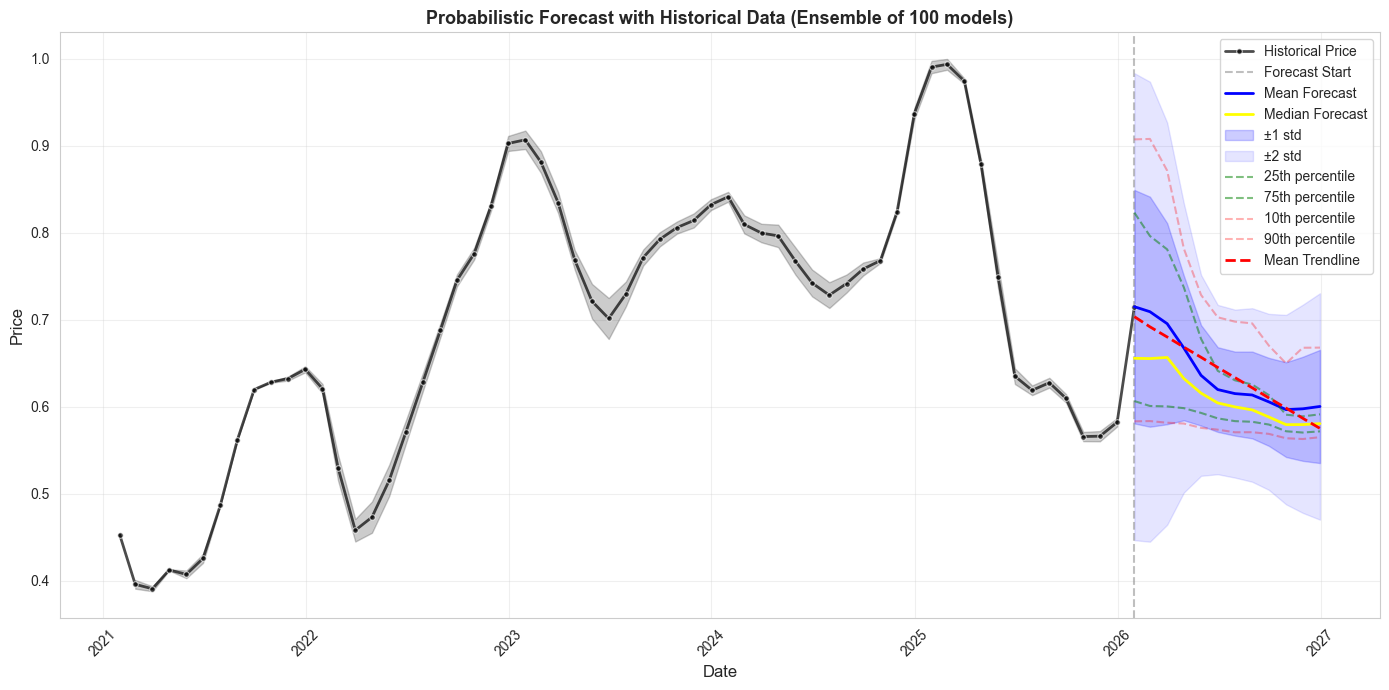

In [14]:
# Example: Grid Search with Probabilistic Forecasting

# Define expanded custom grid for statistically robust ensemble (at least 40 models)
# This grid provides significant variation across key hyperparameters

minmax_scaler = MinMaxScalerWrapper()
combined_scaled = minmax_scaler.fit_transform(combined, ["price", "production", "per_capita_consumption"])

custom_grid = {
    "learning_rate": [0.005, 0.01, 0.015, 0.02, 0.025, 0.03, 0.04],  # 7 values - expanded range
    "hidden_size": [64, 128, 256, 512],  # 4 values - includes smaller and larger models
    "attention_head_size": [2, 4, 6, 8],  # 4 values - varied attention mechanisms
    "dropout": [0.05, 0.1, 0.15, 0.2, 0.25],  # 5 values - regularization range
    "hidden_continuous_size": [16, 32, 48, 64],  # 4 values - continuous feature processing
    "batch_size": [32, 64, 128],  # 3 values - different batch sizes
    "max_epochs": [80, 100, 120, 150, 250],  # 5 values - training duration variation
    "gradient_clip_val": [0.05, 0.1, 0.15, 0.2],  # 4 values - gradient clipping
    "reduce_on_plateau_patience": [4, 6, 8],  # 3 values - learning rate scheduling
}

# Calculate total combinations for reference
# Total = 7 * 4 * 4 * 5 * 4 * 3 * 5 * 4 * 3 = 201,600 combinations
# We'll sample at least 40 models for statistical robustness

# Initialize grid search
grid_search = TFTGridSearch(
    data=combined_scaled,
    max_encoder_length=max_encoder_length,
    max_prediction_length=max_prediction_length,
    hyperparameter_grid=custom_grid,
)

# Run grid search with at least 40 models for statistically convincing results
# Using random_sample=True ensures diverse hyperparameter combinations
# This provides better coverage of the hyperparameter space
results = grid_search.search(max_models=100, random_sample=True)


# Get probabilistic forecast from ensemble
probabilistic_forecast = grid_search.get_probabilistic_forecast(quantiles=[0.1, 0.25, 0.5, 0.75, 0.9])

# # Display results
# print(f"\n{'='*60}")
# print(f"Probabilistic Forecast Summary")
# print(f"{'='*60}")
# print(f"Number of models: {probabilistic_forecast.n_models}")
# print(f"Forecast period: {len(probabilistic_forecast.mean)} months")
# print(f"\nMean forecast (first 3 months):")
# for i, (date, mean_val) in enumerate(zip(probabilistic_forecast.dates[:3], probabilistic_forecast.mean[:3])):
#     std_val = probabilistic_forecast.std[i]
#     print(f"  {date}: {mean_val:.4f} ± {std_val:.4f}")

# # Get best single model
# best_model = grid_search.get_best_model(metric="train_loss")
# print(f"\nBest model training loss: {best_model.train_loss:.4f}")

# # Plot probabilistic forecast with historical data
grid_search.plot_forecast_comparison(probabilistic_forecast, historical_data=combined_scaled, historical_window_steps=10 * max_prediction_length)



Inverse Transformed Probabilistic Forecast Summary
Number of models: 100
Forecast period: 12 months

Mean forecast (first 3 months) - Original Scale:
  2026-01-31T00:00:00: 8057.25 ± 1211.75
  2026-02-28T00:00:00: 8016.53 ± 1188.14
  2026-03-31T00:00:00: 7919.59 ± 1027.67


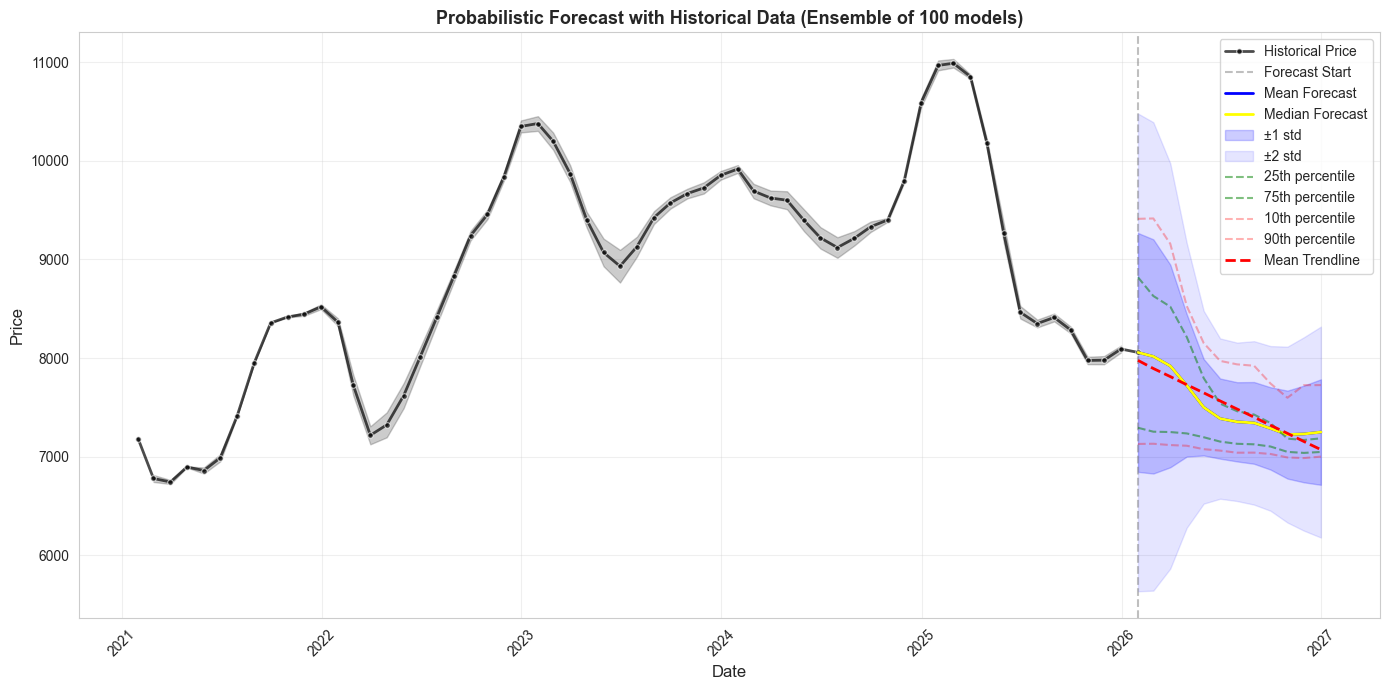

ProbabilisticForecastResult(dates=['2026-01-31T00:00:00', '2026-02-28T00:00:00', '2026-03-31T00:00:00', '2026-04-30T00:00:00', '2026-05-31T00:00:00', '2026-06-30T00:00:00', '2026-07-31T00:00:00', '2026-08-31T00:00:00', '2026-09-30T00:00:00', '2026-10-31T00:00:00', '2026-11-30T00:00:00', '2026-12-31T00:00:00'], mean=[8057.25, 8016.533074692325, 7919.585202192784, 7722.6943956027535, 7500.798782842074, 7385.872702321531, 7353.051534849339, 7342.002143019945, 7286.14951750436, 7223.252028219957, 7229.925443972297, 7248.9654257730235], median=[8057.25, 8016.533074692325, 7919.585202192784, 7722.6943956027535, 7500.798782842074, 7385.872702321531, 7353.051534849339, 7342.002143019945, 7286.14951750436, 7223.252028219957, 7229.925443972297, 7248.9654257730235], std=[1211.751758661165, 1188.138935391871, 1027.6732646098508, 722.5381624925728, 489.07065732416874, 406.6505657106694, 401.85286455575755, 414.58973677114466, 417.7053239584703, 446.13230740270933, 490.55022037014027, 534.9518913071

In [15]:

# Inverse transform the probabilistic forecasts back to original scale

# Create a DataFrame with the forecast values for inverse transformation
forecast_df = pd.DataFrame({
    "price": probabilistic_forecast.mean
})

# Inverse transform the mean forecast
forecast_df_inverse = minmax_scaler.inverse_transform(forecast_df, columns=["price"])
mean_inverse = forecast_df_inverse["price"].tolist()

forecast_df_inverse = pd.DataFrame({
    "price": probabilistic_forecast.median
})

# Inverse transform the median forecast
forecast_df_inverse = minmax_scaler.inverse_transform(forecast_df, columns=["price"])
median_inverse = forecast_df_inverse["price"].tolist()


nearer_to_zero_mean = (combined.iloc[-1]["price"] - mean_inverse[0])
nearer_to_zero_median = (combined.iloc[-1]["price"] - median_inverse[0])

correction = nearer_to_zero_mean if abs(nearer_to_zero_mean) < abs(nearer_to_zero_median) else nearer_to_zero_median

mean_inverse = [x + correction for x in mean_inverse]
median_inverse = [x + correction for x in median_inverse]

# Inverse transform the std (standard deviation scales with the same transformation)
# Note: std should be scaled by the same factor as the mean
# std_df = pd.DataFrame({
#     "price": probabilistic_forecast.std
# })
# std_df_inverse = minmax_scaler.inverse_transform(std_df, columns=["price"])
std_inverse = forecast_df_inverse["price"].values * np.array(probabilistic_forecast.std)

# Inverse transform all quantiles
quantiles_inverse = {}
for quantile_name, quantile_values in probabilistic_forecast.quantiles.items():
    quantile_df = pd.DataFrame({
        "price": quantile_values
    })
    quantile_df_inverse = minmax_scaler.inverse_transform(quantile_df, columns=["price"])
    quantiles_inverse[quantile_name] = (quantile_df_inverse["price"] + correction).tolist()

# Inverse transform individual forecasts
individual_forecasts_inverse = []
for forecast_result in probabilistic_forecast.individual_forecasts:
    individual_df = pd.DataFrame({
        "price": forecast_result.forecast
    })
    individual_df_inverse = minmax_scaler.inverse_transform(individual_df, columns=["price"])
    
    # Create new ForecastResult with inverse transformed values
    forecast_result_inverse = ForecastResult(
        model_name=forecast_result.model_name,
        config=forecast_result.config,
        forecast=(individual_df_inverse["price"] + correction).tolist(),
        dates=forecast_result.dates,
        train_loss=forecast_result.train_loss,
    )
    individual_forecasts_inverse.append(forecast_result_inverse)


# Create new ProbabilisticForecastResult with inverse transformed values
probabilistic_forecast_inverse = ProbabilisticForecastResult(
    dates=probabilistic_forecast.dates,
    mean=mean_inverse,
    median=median_inverse,
    std=std_inverse,
    quantiles=quantiles_inverse,
    individual_forecasts=individual_forecasts_inverse,
    n_models=probabilistic_forecast.n_models,
)

# Display inverse transformed results
print(f"\n{'='*60}")
print(f"Inverse Transformed Probabilistic Forecast Summary")
print(f"{'='*60}")
print(f"Number of models: {probabilistic_forecast_inverse.n_models}")
print(f"Forecast period: {len(probabilistic_forecast_inverse.mean)} months")
print(f"\nMean forecast (first 3 months) - Original Scale:")
for i, (date, mean_val) in enumerate(zip(probabilistic_forecast_inverse.dates[:3], probabilistic_forecast_inverse.mean[:3])):
    std_val = probabilistic_forecast_inverse.std[i]
    print(f"  {date}: {mean_val:.2f} ± {std_val:.2f}")

# Plot inverse transformed forecast with historical data (original scale)
grid_search.plot_forecast_comparison(probabilistic_forecast_inverse, historical_data=combined, historical_window_steps=10 * max_prediction_length)

probabilistic_forecast_inverse



Statistics Comparison:

Historical Prices:
  Mean: 8317.08
  Median: 8477.77
  Std: 1660.09
  Min: 3988.00
  Max: 11034.59

All Forecasts:
  Mean: 7523.82
  Median: 7241.51
  Std: 649.82
  Min: 6745.57
  Max: 10144.77



/var/folders/x_/bhh5_n9161l5y7xp2k8l1crm0000gp/T/ipykernel_51012/3849725689.py:56: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  bp = ax2.boxplot(box_data, labels=box_labels, patch_artist=True, widths=0.6)


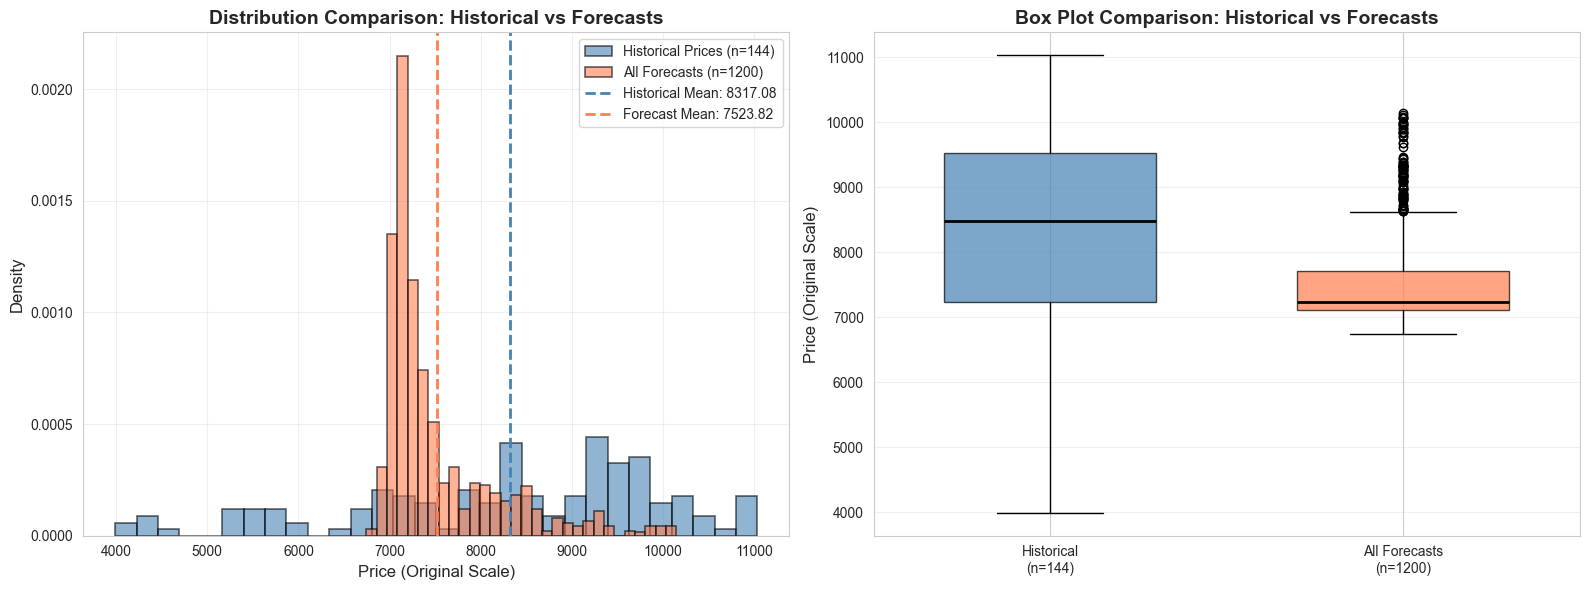

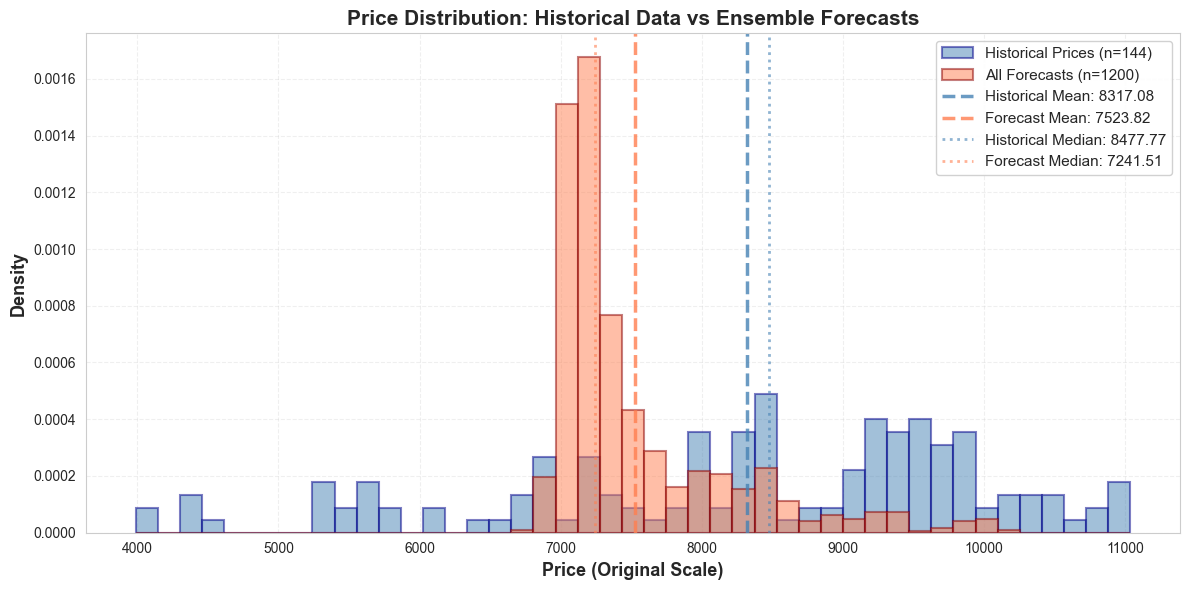

In [16]:
# Histogram comparing forecast distribution vs historical price distribution

import matplotlib.pyplot as plt
import numpy as np

# Collect all forecast values from all individual models (already inverse transformed)
all_forecast_values = []
for forecast_result in probabilistic_forecast_inverse.individual_forecasts:
    all_forecast_values.extend(forecast_result.forecast)

# Get historical price data (original scale, not scaled)
historical_prices = combined["price"].dropna().values

# Create figure with subplots
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Left plot: Overlaid histograms
ax1 = axes[0]
ax1.hist(
    historical_prices, 
    bins=30, 
    alpha=0.6, 
    label=f'Historical Prices (n={len(historical_prices)})', 
    color='steelblue',
    density=True,
    edgecolor='black',
    linewidth=1.2
)
ax1.hist(
    all_forecast_values, 
    bins=30, 
    alpha=0.6, 
    label=f'All Forecasts (n={len(all_forecast_values)})', 
    color='coral',
    density=True,
    edgecolor='black',
    linewidth=1.2
)

# Add vertical lines for means
hist_mean = np.mean(historical_prices)
forecast_mean = np.mean(all_forecast_values)
ax1.axvline(hist_mean, color='steelblue', linestyle='--', linewidth=2, label=f'Historical Mean: {hist_mean:.2f}')
ax1.axvline(forecast_mean, color='coral', linestyle='--', linewidth=2, label=f'Forecast Mean: {forecast_mean:.2f}')

ax1.set_xlabel('Price (Original Scale)', fontsize=12)
ax1.set_ylabel('Density', fontsize=12)
ax1.set_title('Distribution Comparison: Historical vs Forecasts', fontsize=14, fontweight='bold')
ax1.legend(loc='best', fontsize=10)
ax1.grid(True, alpha=0.3)

# Right plot: Side-by-side box plots
ax2 = axes[1]
box_data = [historical_prices, all_forecast_values]
box_labels = [f'Historical\n(n={len(historical_prices)})', f'All Forecasts\n(n={len(all_forecast_values)})']
bp = ax2.boxplot(box_data, labels=box_labels, patch_artist=True, widths=0.6)

# Color the boxes
bp['boxes'][0].set_facecolor('steelblue')
bp['boxes'][0].set_alpha(0.7)
bp['boxes'][1].set_facecolor('coral')
bp['boxes'][1].set_alpha(0.7)

# Color the medians
for median in bp['medians']:
    median.set_color('black')
    median.set_linewidth(2)

ax2.set_ylabel('Price (Original Scale)', fontsize=12)
ax2.set_title('Box Plot Comparison: Historical vs Forecasts', fontsize=14, fontweight='bold')
ax2.grid(True, alpha=0.3, axis='y')

# Add statistics text
stats_text = f"""
Statistics Comparison:

Historical Prices:
  Mean: {np.mean(historical_prices):.2f}
  Median: {np.median(historical_prices):.2f}
  Std: {np.std(historical_prices):.2f}
  Min: {np.min(historical_prices):.2f}
  Max: {np.max(historical_prices):.2f}

All Forecasts:
  Mean: {np.mean(all_forecast_values):.2f}
  Median: {np.median(all_forecast_values):.2f}
  Std: {np.std(all_forecast_values):.2f}
  Min: {np.min(all_forecast_values):.2f}
  Max: {np.max(all_forecast_values):.2f}
"""

print(stats_text)

plt.tight_layout()
plt.show()

# Additional: Create a single combined histogram with better styling
fig2, ax3 = plt.subplots(figsize=(12, 6))

# Create histogram with better binning
n_bins = max(30, int(np.sqrt(len(historical_prices)) + np.sqrt(len(all_forecast_values))))
bins = np.linspace(
    min(np.min(historical_prices), np.min(all_forecast_values)),
    max(np.max(historical_prices), np.max(all_forecast_values)),
    n_bins
)

ax3.hist(
    historical_prices, 
    bins=bins, 
    alpha=0.5, 
    label=f'Historical Prices (n={len(historical_prices)})', 
    color='steelblue',
    density=True,
    edgecolor='darkblue',
    linewidth=1.5
)
ax3.hist(
    all_forecast_values, 
    bins=bins, 
    alpha=0.5, 
    label=f'All Forecasts (n={len(all_forecast_values)})', 
    color='coral',
    density=True,
    edgecolor='darkred',
    linewidth=1.5
)

# Add mean lines
ax3.axvline(hist_mean, color='steelblue', linestyle='--', linewidth=2.5, 
            label=f'Historical Mean: {hist_mean:.2f}', alpha=0.8)
ax3.axvline(forecast_mean, color='coral', linestyle='--', linewidth=2.5, 
            label=f'Forecast Mean: {forecast_mean:.2f}', alpha=0.8)

# Add median lines
hist_median = np.median(historical_prices)
forecast_median = np.median(all_forecast_values)
ax3.axvline(hist_median, color='steelblue', linestyle=':', linewidth=2, 
            label=f'Historical Median: {hist_median:.2f}', alpha=0.6)
ax3.axvline(forecast_median, color='coral', linestyle=':', linewidth=2, 
            label=f'Forecast Median: {forecast_median:.2f}', alpha=0.6)

ax3.set_xlabel('Price (Original Scale)', fontsize=13, fontweight='bold')
ax3.set_ylabel('Density', fontsize=13, fontweight='bold')
ax3.set_title('Price Distribution: Historical Data vs Ensemble Forecasts', fontsize=15, fontweight='bold')
ax3.legend(loc='best', fontsize=11, framealpha=0.9)
ax3.grid(True, alpha=0.3, linestyle='--')

plt.tight_layout()
plt.show()
